# Density of Map Spectra

In [4]:
import sys
sys.path.insert(0, '../../src/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import multiprocessing as mp
import random

import pickle
from qiskit.quantum_info import DensityMatrix
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
from qiskit.circuit.random import random_circuit
from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info import random_unitary

from cost_functions import *
from optimization import *
from quantum_maps import *
from quantum_tools import *
%matplotlib inline
#np.set_printoptions(threshold=sys.maxsize)

In [5]:
def haar_layer(circuit, n, idx):
    if idx%2 == 0:
        for i in range(n//2):
            random_pair = random_unitary(4)
            circuit.append(random_pair, [2*i, 2*i+1])   
    else:      
        for i in range(n//2-1+n%2):
            random_pair = random_unitary(4)
            circuit.append(random_pair, [2*i+1, 2*(i+1)])
    
    return circuit
            

def generate_haar_layer_unitary(d, rank, depth, verbose = False): 
    backend = QasmSimulator()
    backend_options = {'method': 'statevector'}
    
    n_eff = int(np.log2(d*rank))
    random_circ = qk.QuantumCircuit(n_eff)
    for i in range(depth):
        random_circ = haar_layer(random_circ, n_eff, i)
    
    U = np.zeros((rank*d, d), dtype="complex128")
    if verbose:
        dec = tqdm
    else:
        dec = lambda x: x
    
    for i in dec(range(d)):
        prep = qk.QuantumCircuit(n_eff)
        flip_list = numberToBase(i, 2, n_eff)
        for j, flip in enumerate(reversed(flip_list)):
            if flip: prep.x(j)
            
        slice_circuit = prep.compose(random_circ)
        slice_circuit.save_statevector()
        
        job = qk.execute(slice_circuit, backend, backend_options=backend_options)
        U_slice = job.result().get_statevector(slice_circuit).data
        U[:,i] = U_slice
    
    return U


def generate_spectrum_density(n, rank, depth, reps):
    d = 2**n
    n_eff = int(np.log2(d*rank))
    spectrum_total = []
    for i in tqdm(range(reps)):
        U = generate_haar_layer_unitary(d, rank, depth=depth)
        
        kraus_map = KrausMap(d=d, 
                             rank=rank, 
                             generate_map=False)
        
        kraus_map.generate_map(U=U)
        
        choi_map = maps_to_choi([kraus_map])
        spectrum = choi_spectrum(choi_map)
        
        mask = np.logical_and(np.abs(spectrum[0]-1)>1e-5, np.abs(spectrum[1])>1e-5)
        #mask = np.abs(spectrum[0]-1)>1e-8
        
        spectrum = spectrum[:, mask]
        spectrum_total.append(spectrum)
    
    spectrum_total = np.hstack(spectrum_total)
        
    
    return spectrum_total


def generate_spectrum_mixed(U, c, reps):
    d = U.shape[0]
    rank = d**2
    
    spectrum_total = []
    for i in tqdm(range(reps)):
        
        kraus_map = KrausMap(U=U,
                         c=c,
                         d=d, 
                         rank=rank,
                         )
        
        choi_map = maps_to_choi([kraus_map])
        spectrum = choi_spectrum(choi_map)
        
        mask = np.logical_and(np.abs(spectrum[0]-1)>1e-5, np.abs(spectrum[1])>1e-5)
        #mask = np.abs(spectrum[0]-1)>1e-8
        
        spectrum = spectrum[:, mask]
        spectrum_total.append(spectrum)
    
    spectrum_total = np.hstack(spectrum_total)
        
    
    return spectrum_total


def qft(n):
    circuit = qk.QuantumCircuit(n)
    for i in range(n):
        circuit.h(i)
        for j in range(i+1, n):
            circuit.cp(2*np.pi/2**(j-i+1), j, i)
            
    return circuit
    
    
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

## Constant Depth

### Depth 1

In [49]:
n = 2
d = 2**n
rank = d**2
n_eff = int(np.log2(d*rank))

random.seed(42)
np.random.seed(42)

spectrum1 = generate_spectrum_density(n=n, 
                                      rank=rank, 
                                      depth=1, 
                                      reps=100000)

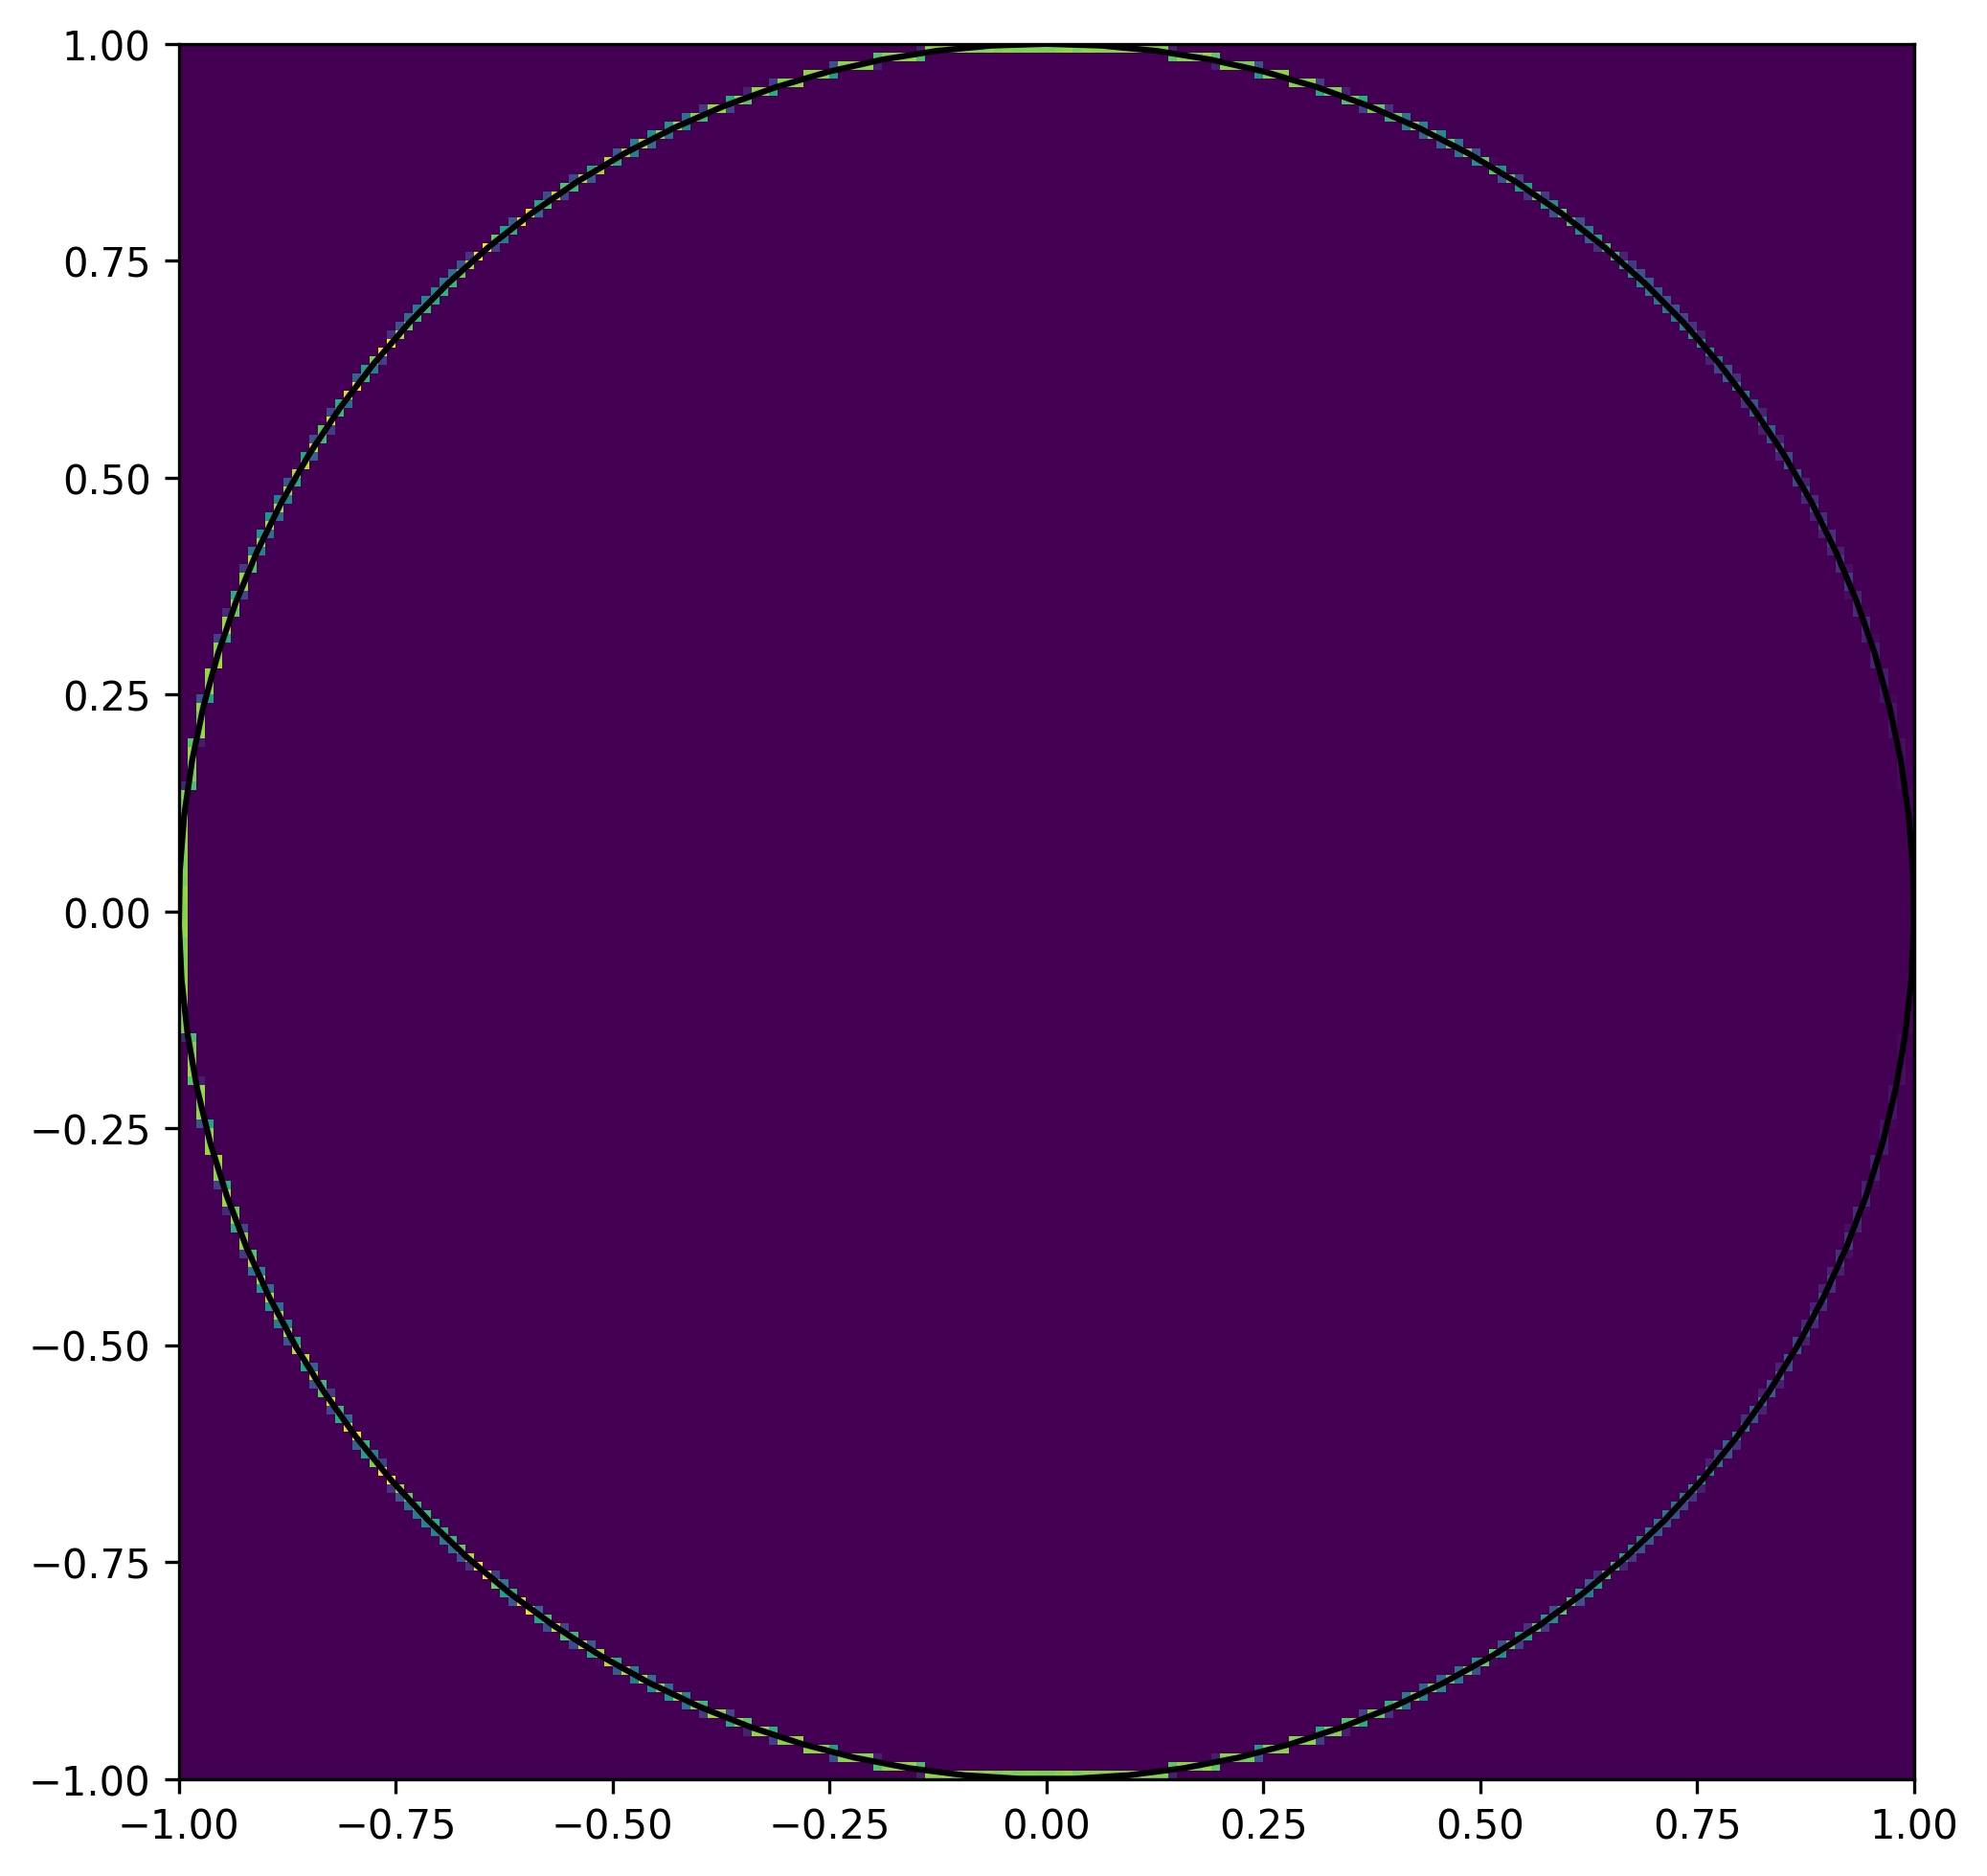

In [50]:
fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
hist, _, _, _ = plt.hist2d(*spectrum1, 
                           range = [[-1, 1], [-1, 1]], 
                           bins = [200, 200],
                          # norm = clr.LogNorm,
                          )

plt.plot(*circle, "k")
fig.savefig("../../latex/figures/twoQubit_constantDepth1_density.pdf")
plt.show()

In [51]:
n = 3
d = 2**n
rank = d**2
n_eff = int(np.log2(d*rank))

random.seed(42)
np.random.seed(42)

spectrum1 = generate_spectrum_density(n=n, 
                                      rank=rank, 
                                      depth=1, 
                                      reps=10000)

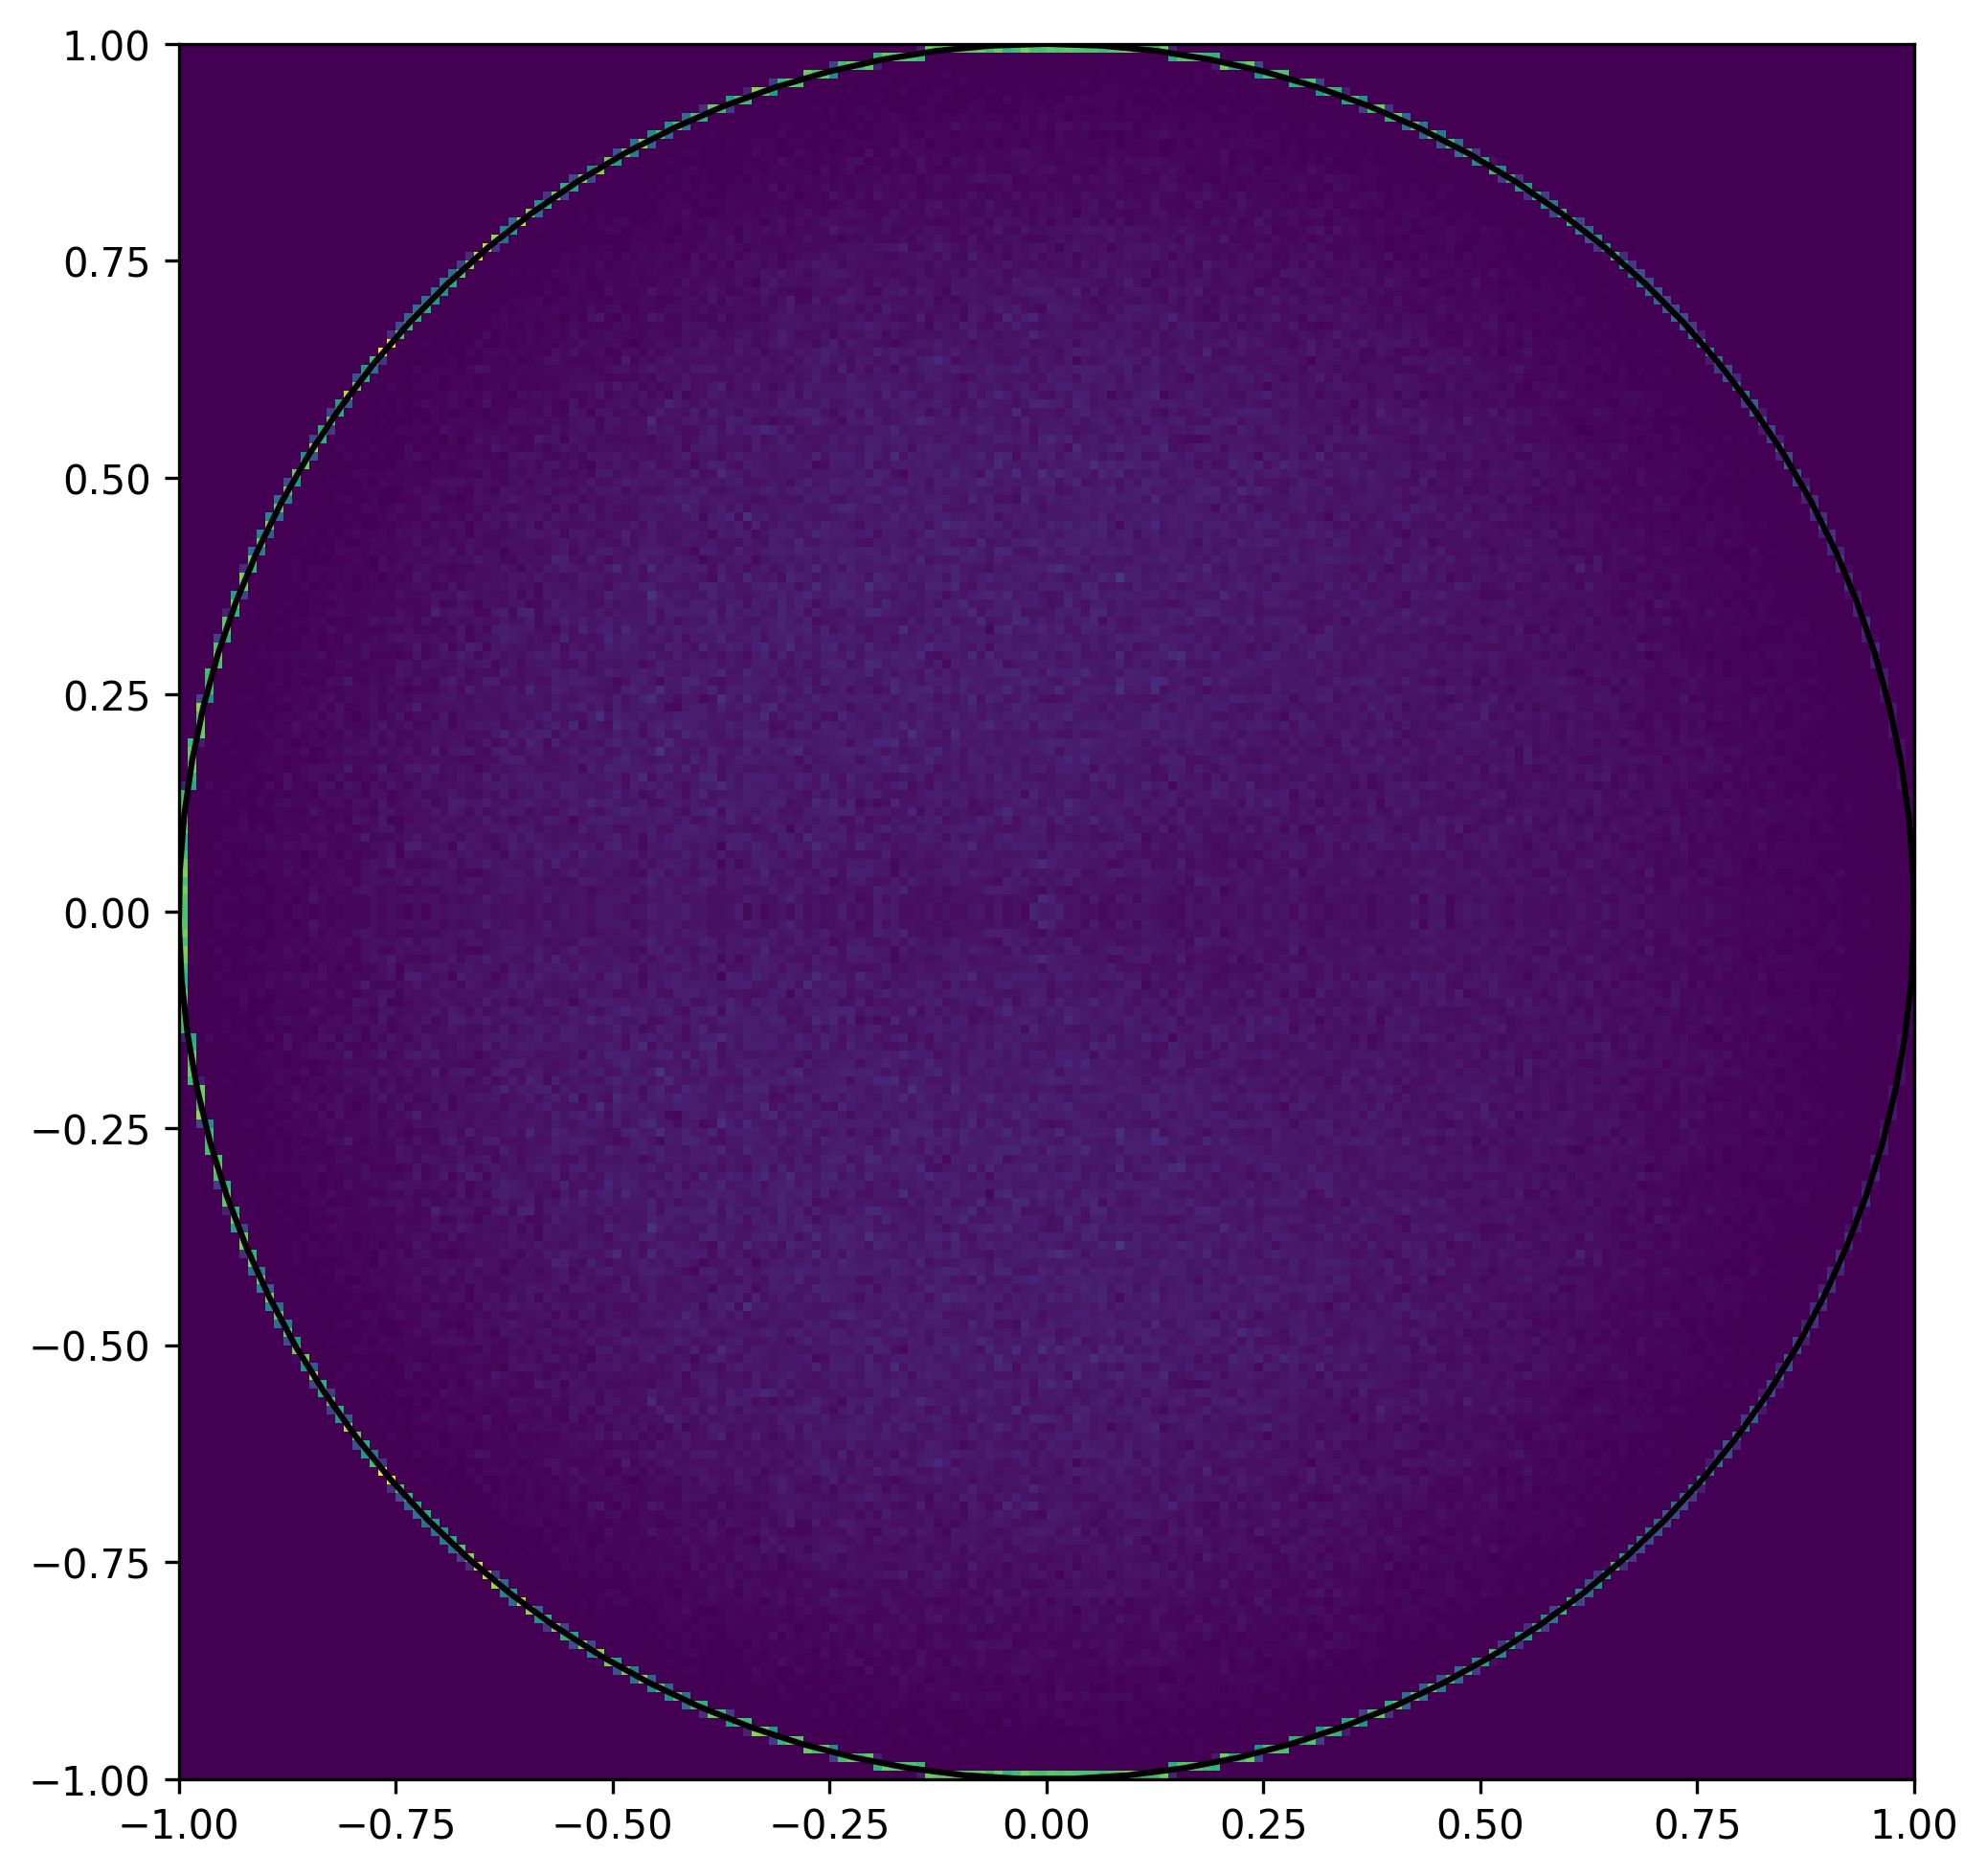

In [52]:
fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
hist, _, _, _ = plt.hist2d(*spectrum1, 
                           range = [[-1, 1], [-1, 1]], 
                           bins = [200, 200],
                          # norm = clr.LogNorm,
                          )

plt.plot(*circle, "k")
fig.savefig("../../latex/figures/threeQubit_constantDepth1_density.pdf")
plt.show()

In [53]:
n = 4
d = 2**n
rank = d**2
n_eff = int(np.log2(d*rank))

random.seed(42)
np.random.seed(42)

spectrum1 = generate_spectrum_density(n=n, 
                                      rank=rank, 
                                      depth=1, 
                                      reps=1000)

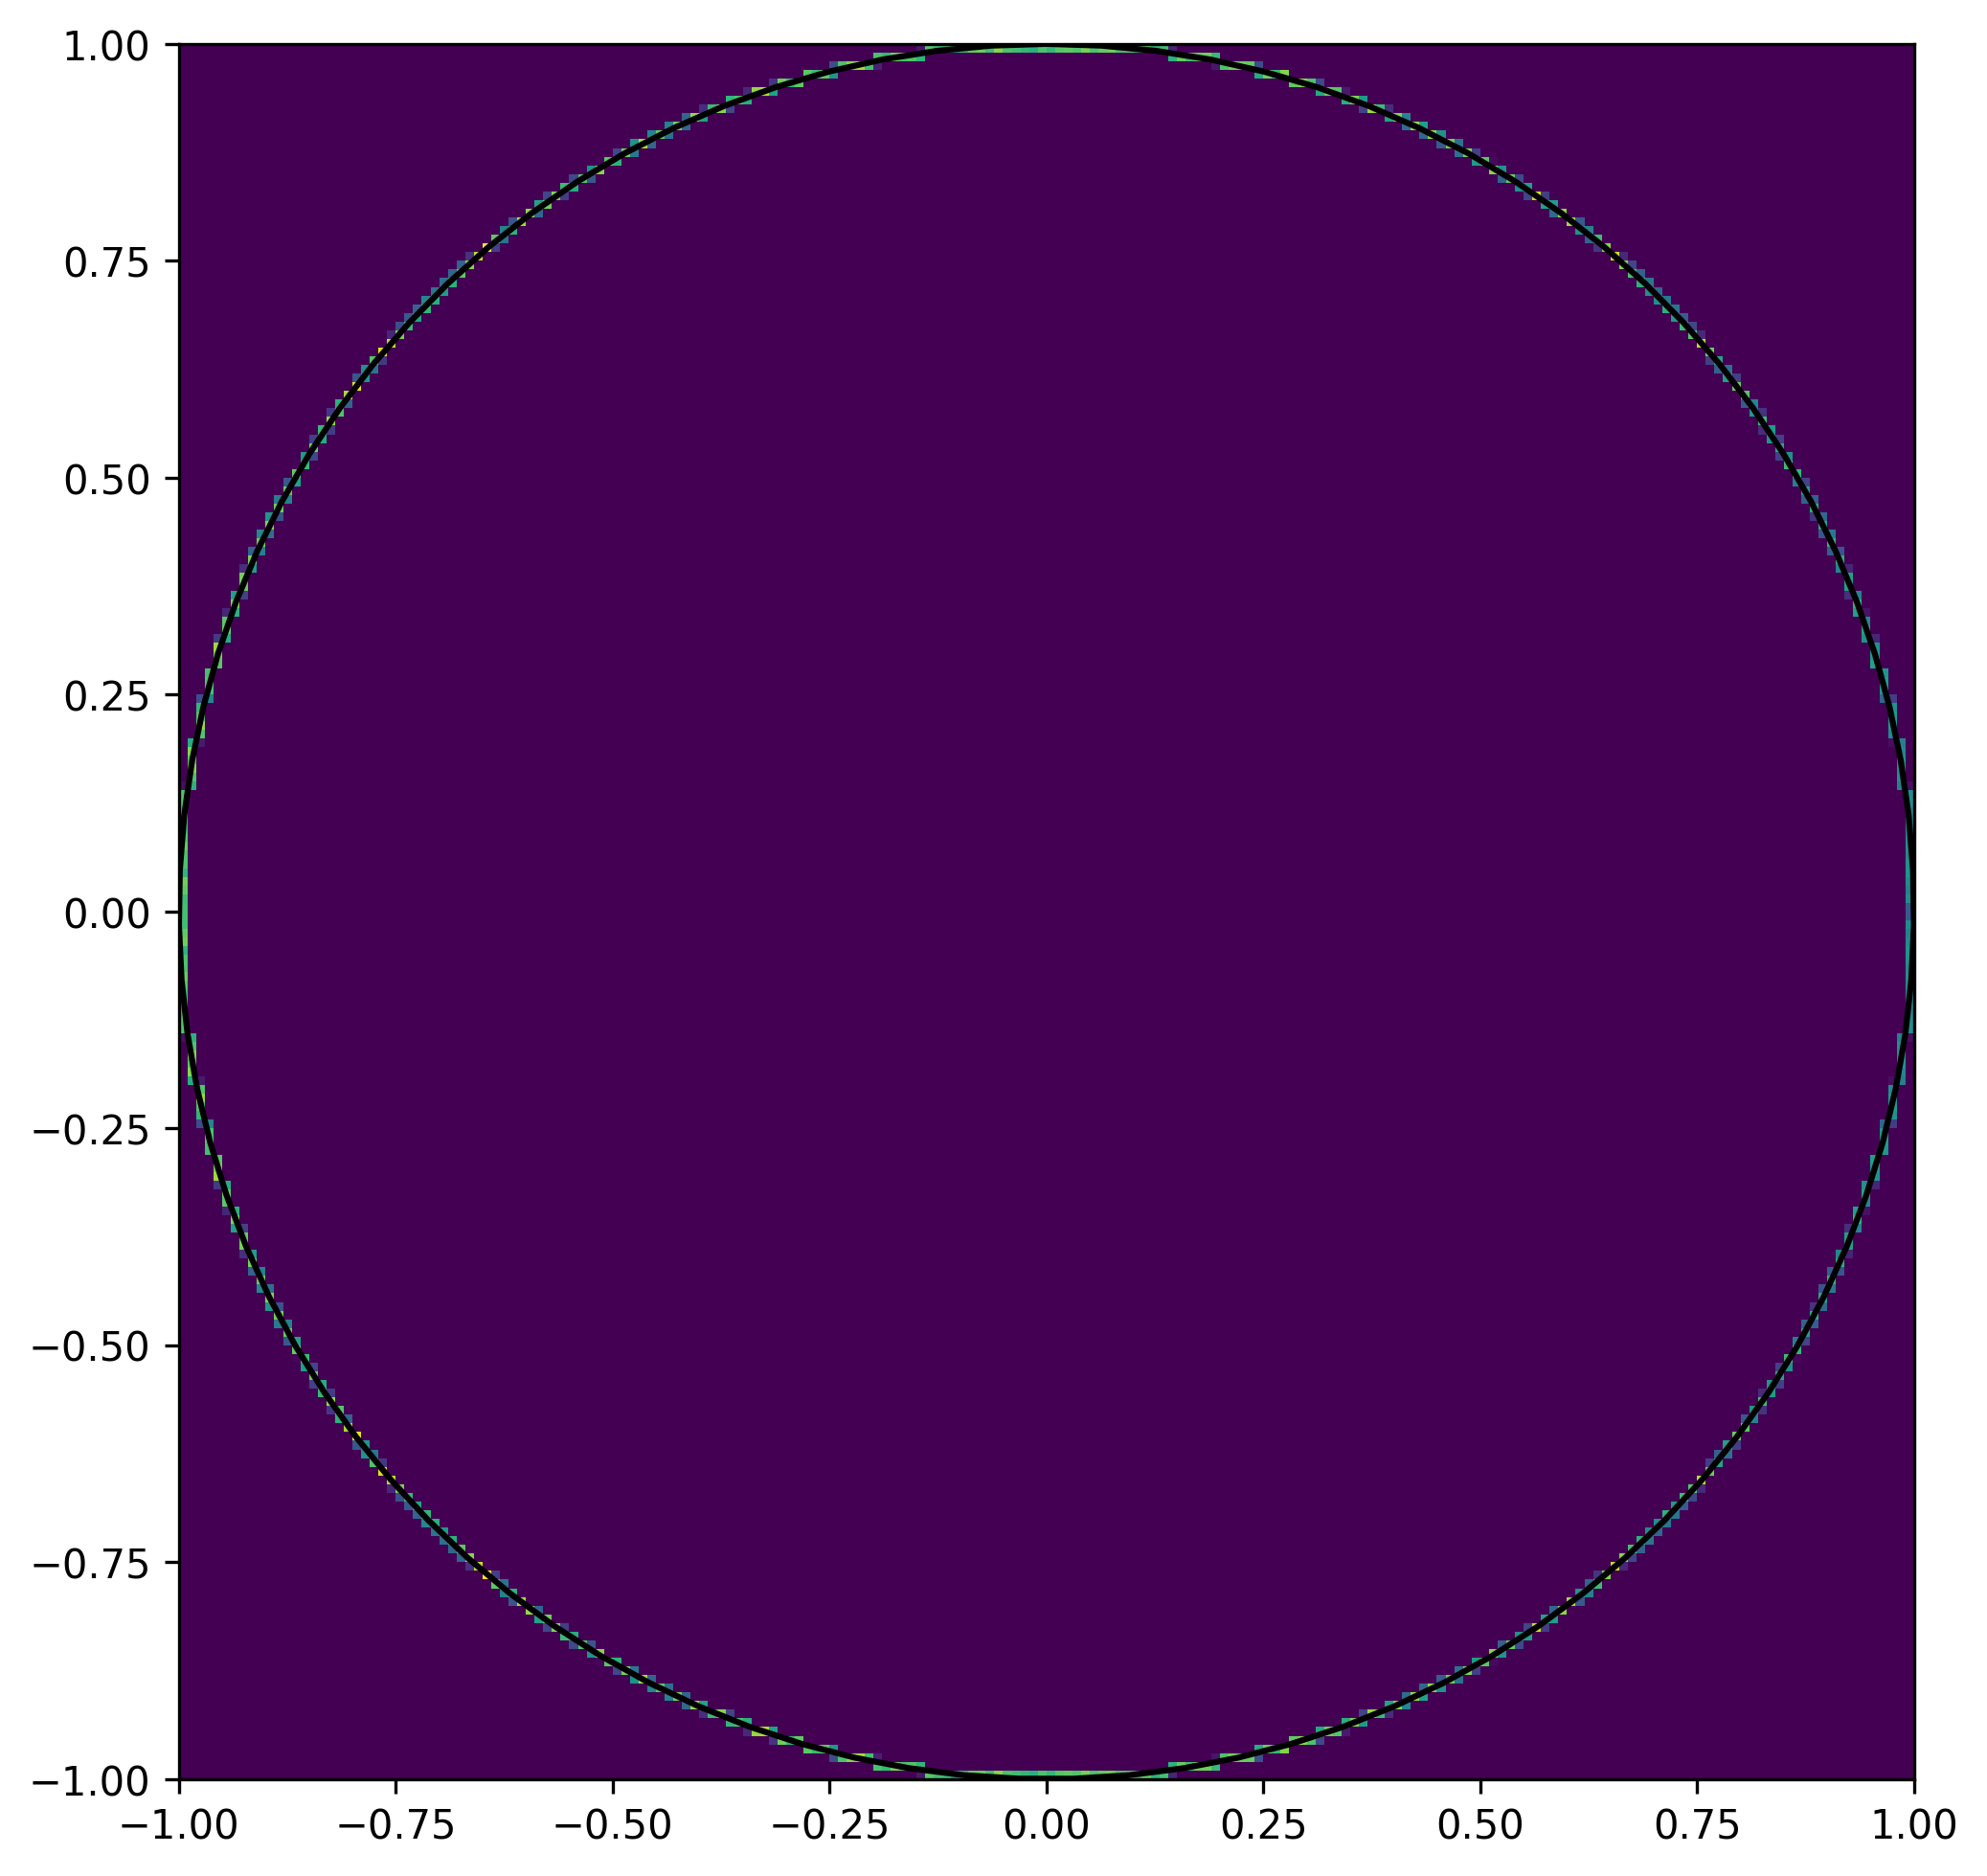

In [54]:
fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
hist, _, _, _ = plt.hist2d(*spectrum1, 
                           range = [[-1, 1], [-1, 1]], 
                           bins = [200, 200],
                          # norm = clr.LogNorm,
                          )

plt.plot(*circle, "k")
fig.savefig("../../latex/figures/fourQubit_constantDepth1_density.pdf")
plt.show()

In [55]:
n = 5
d = 2**n
rank = d**2
n_eff = int(np.log2(d*rank))

random.seed(42)
np.random.seed(42)

spectrum1 = generate_spectrum_density(n=n, 
                                      rank=rank, 
                                      depth=1, 
                                      reps=100)

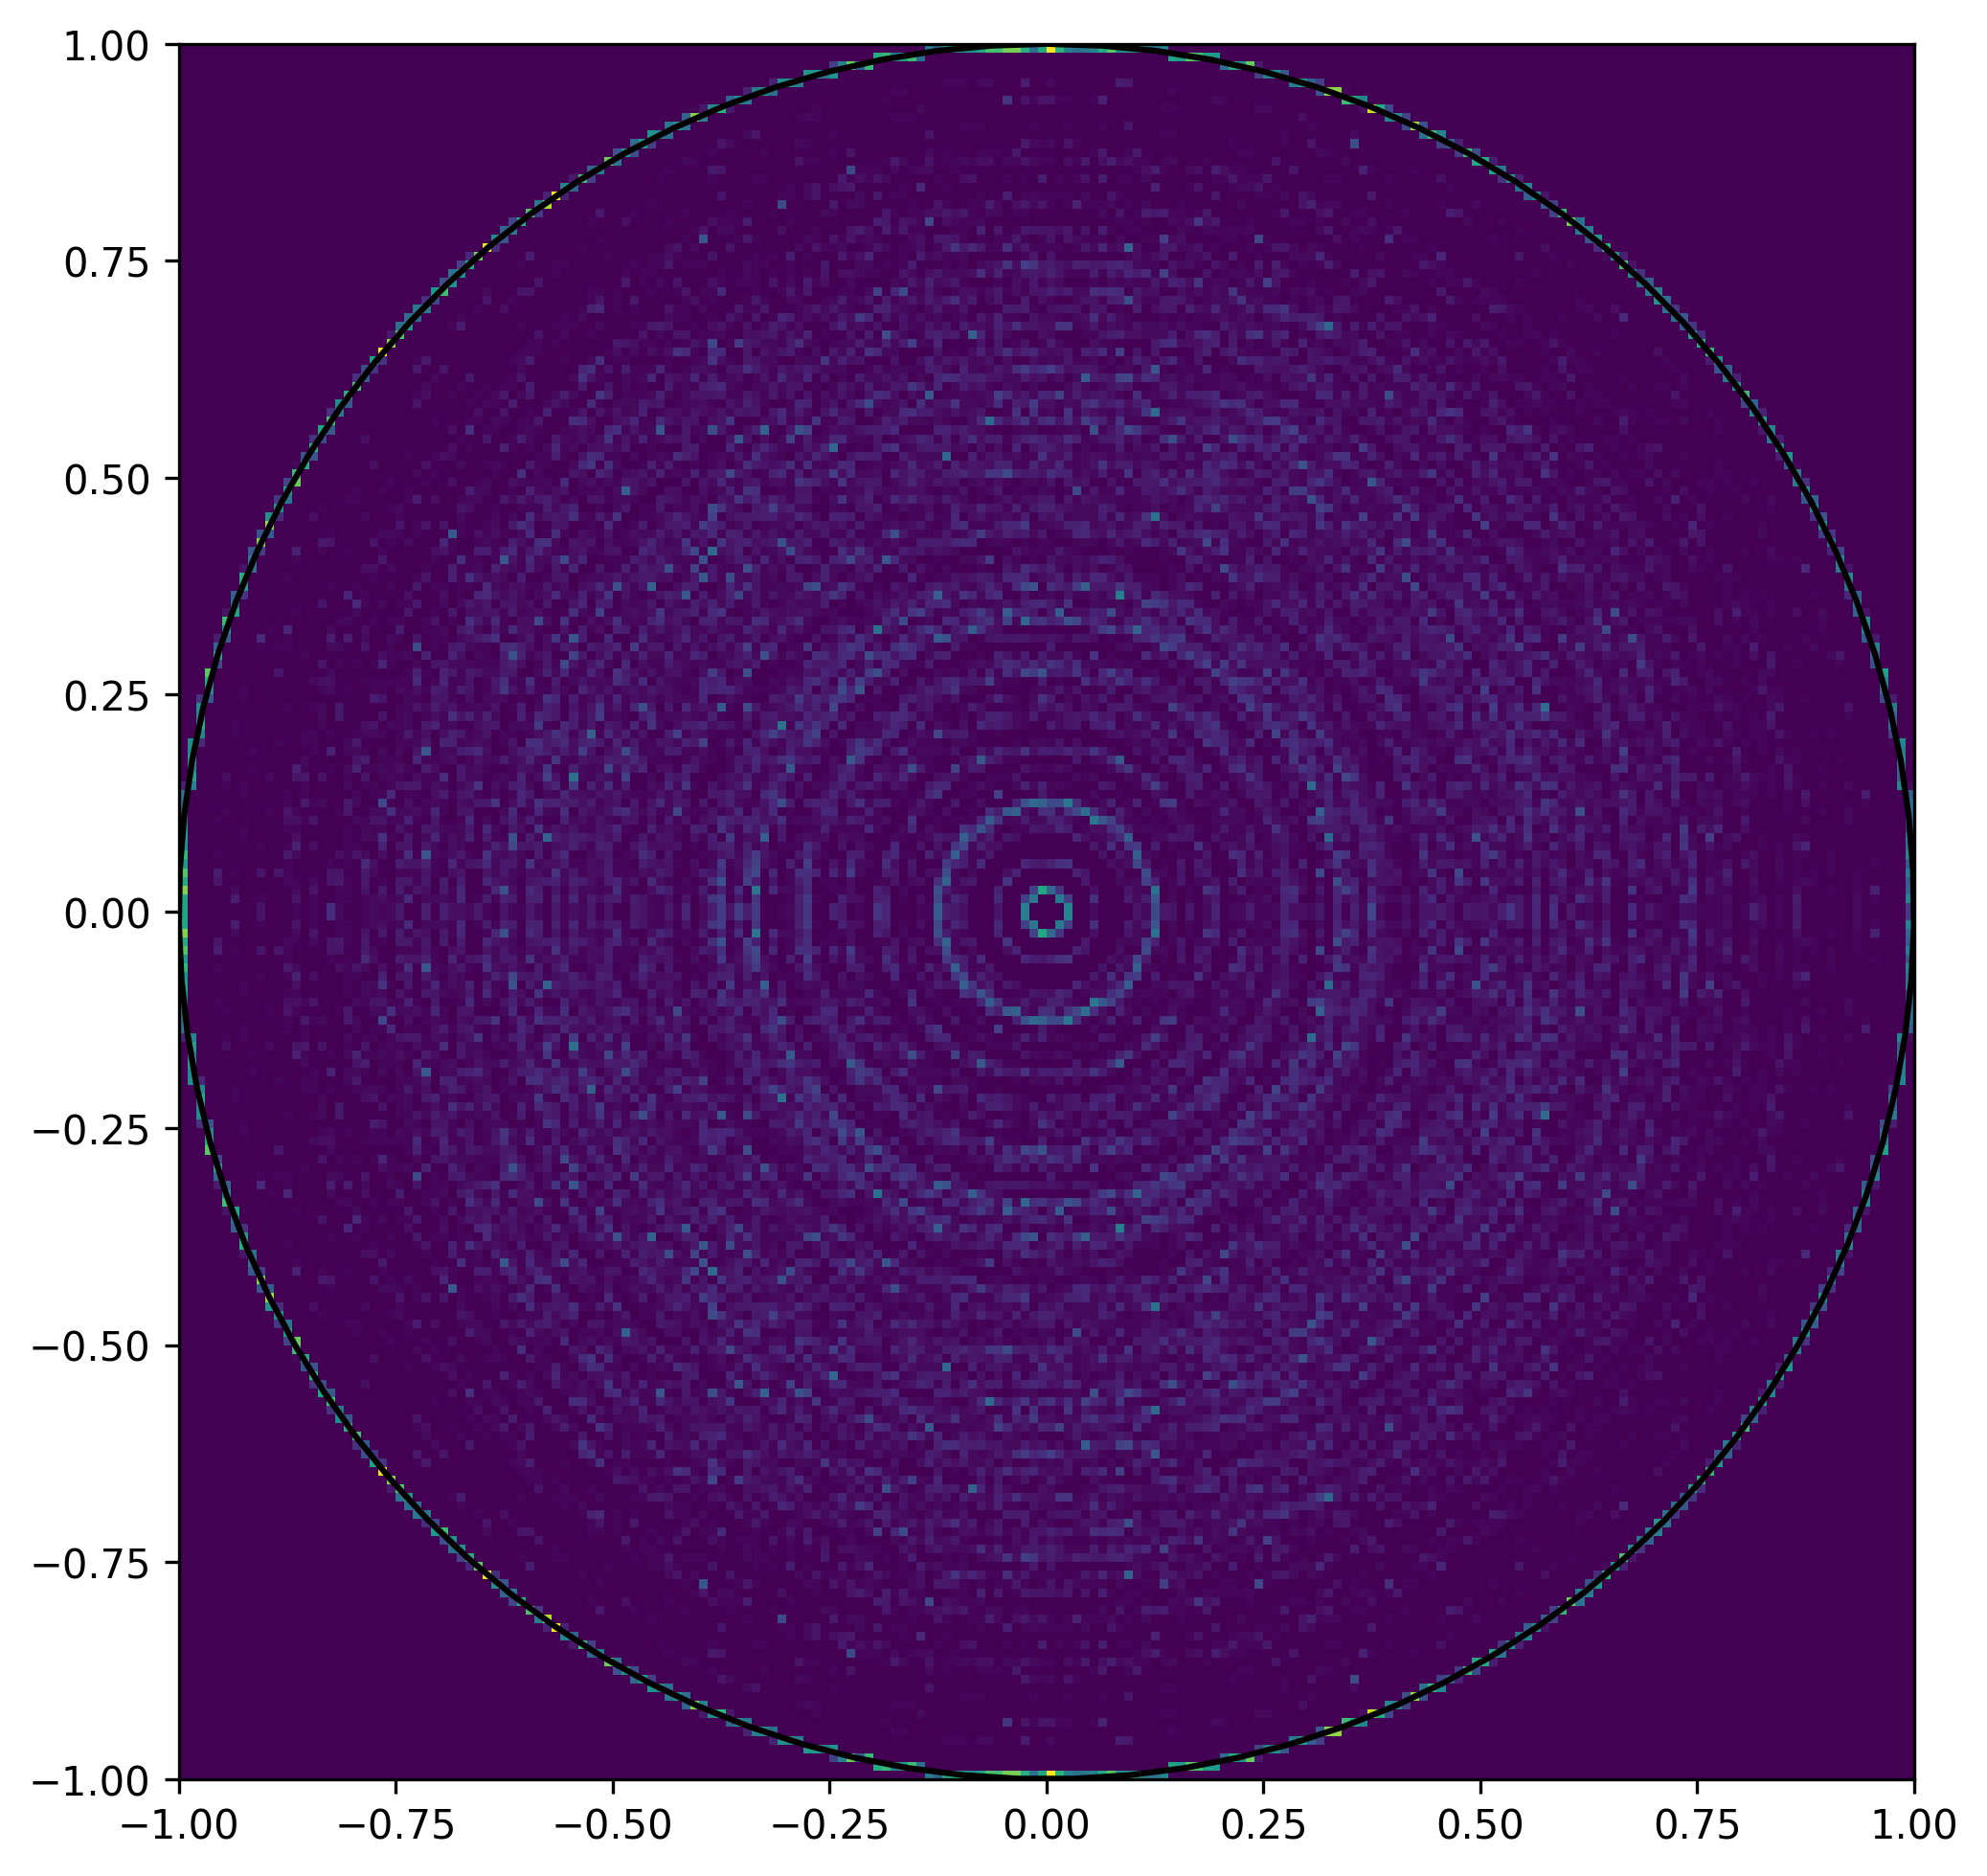

In [56]:
fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
hist, _, _, _ = plt.hist2d(*spectrum1, 
                           range = [[-1, 1], [-1, 1]], 
                           bins = [200, 200],
                          # norm = clr.LogNorm,
                          )

plt.plot(*circle, "k")
fig.savefig("../../latex/figures/fiveQubit_constantDepth1_density.pdf")
plt.show()

### Depth Two

In [26]:
n = 2
d = 2**n
rank = d**2
n_eff = int(np.log2(d*rank))

random.seed(42)
np.random.seed(42)

spectrum1 = generate_spectrum_density(n=n, 
                                      rank=rank, 
                                      depth=2, 
                                      reps=100000)

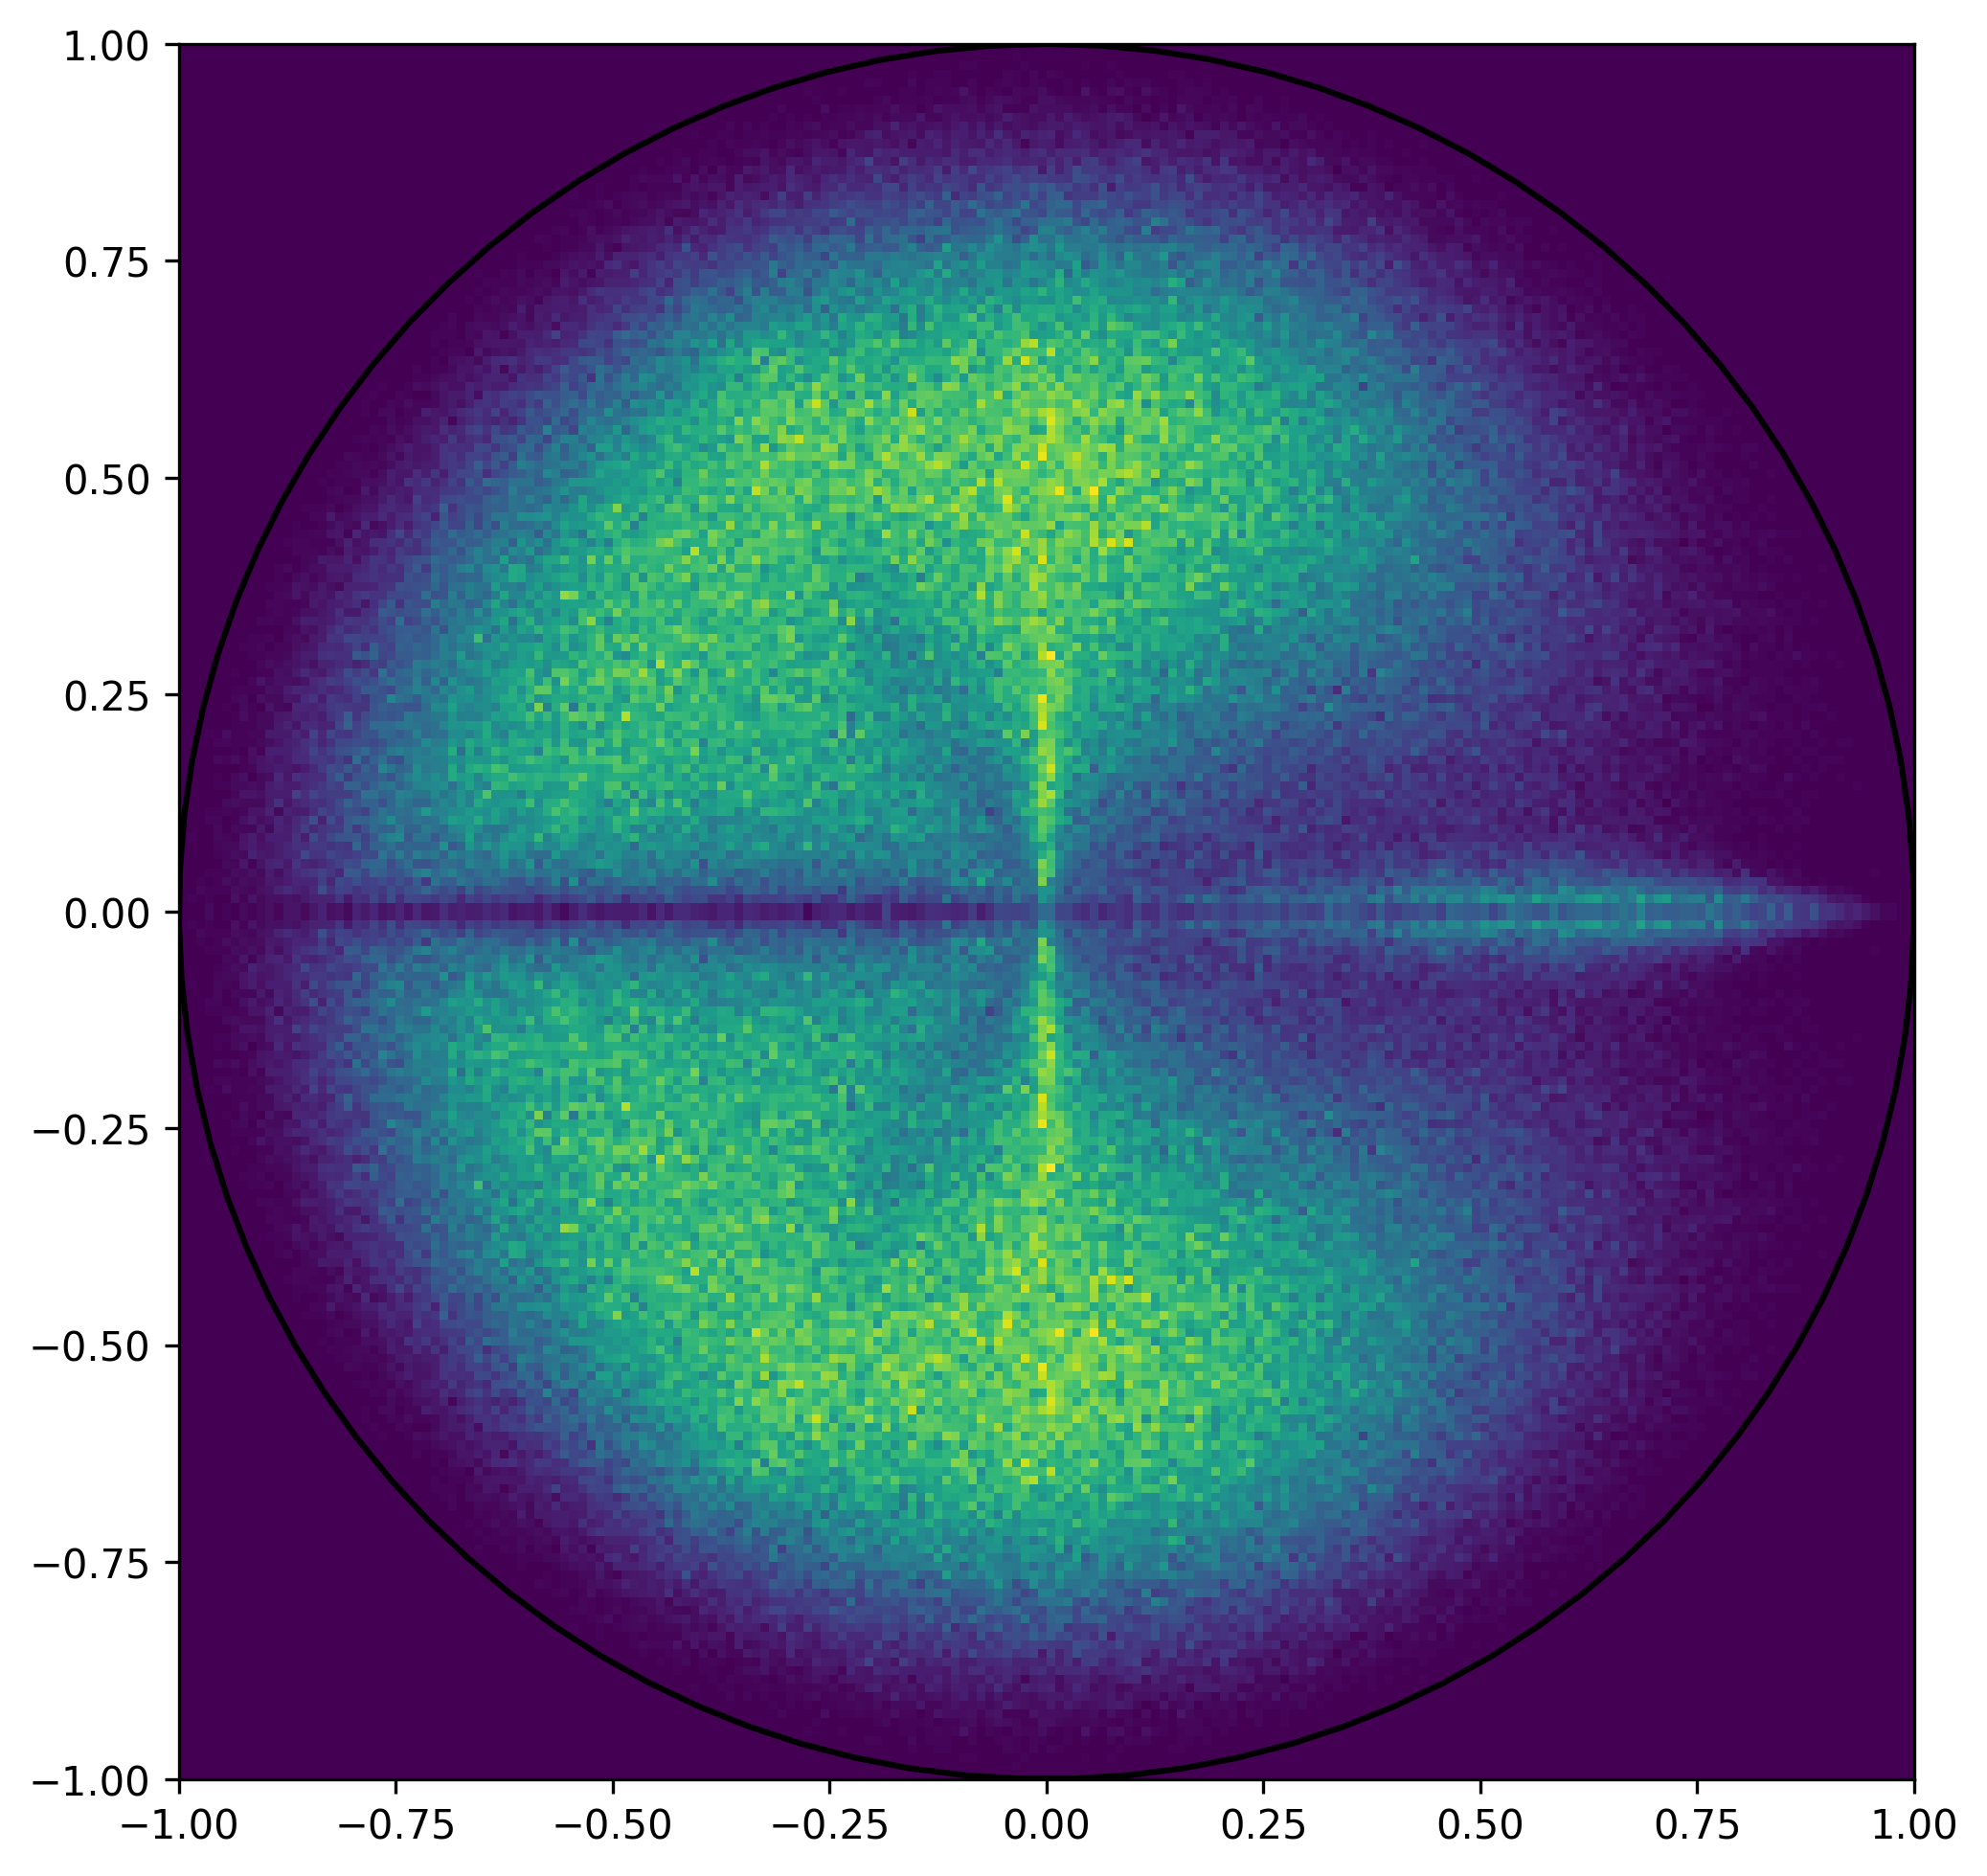

In [27]:
fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
hist, _, _, _ = plt.hist2d(*spectrum1, 
                           range = [[-1, 1], [-1, 1]], 
                           bins = [200, 200],
                          # norm = clr.LogNorm,
                          )

plt.plot(*circle, "k")
fig.savefig("../../latex/figures/twoQubit_constantDepth_density.pdf")
plt.show()

In [28]:
n = 3
d = 2**n
rank = d**2
n_eff = int(np.log2(d*rank))

random.seed(42)
np.random.seed(42)

spectrum2 = generate_spectrum_density(n=n, 
                                      rank=rank, 
                                      depth=2, 
                                      reps=10000)

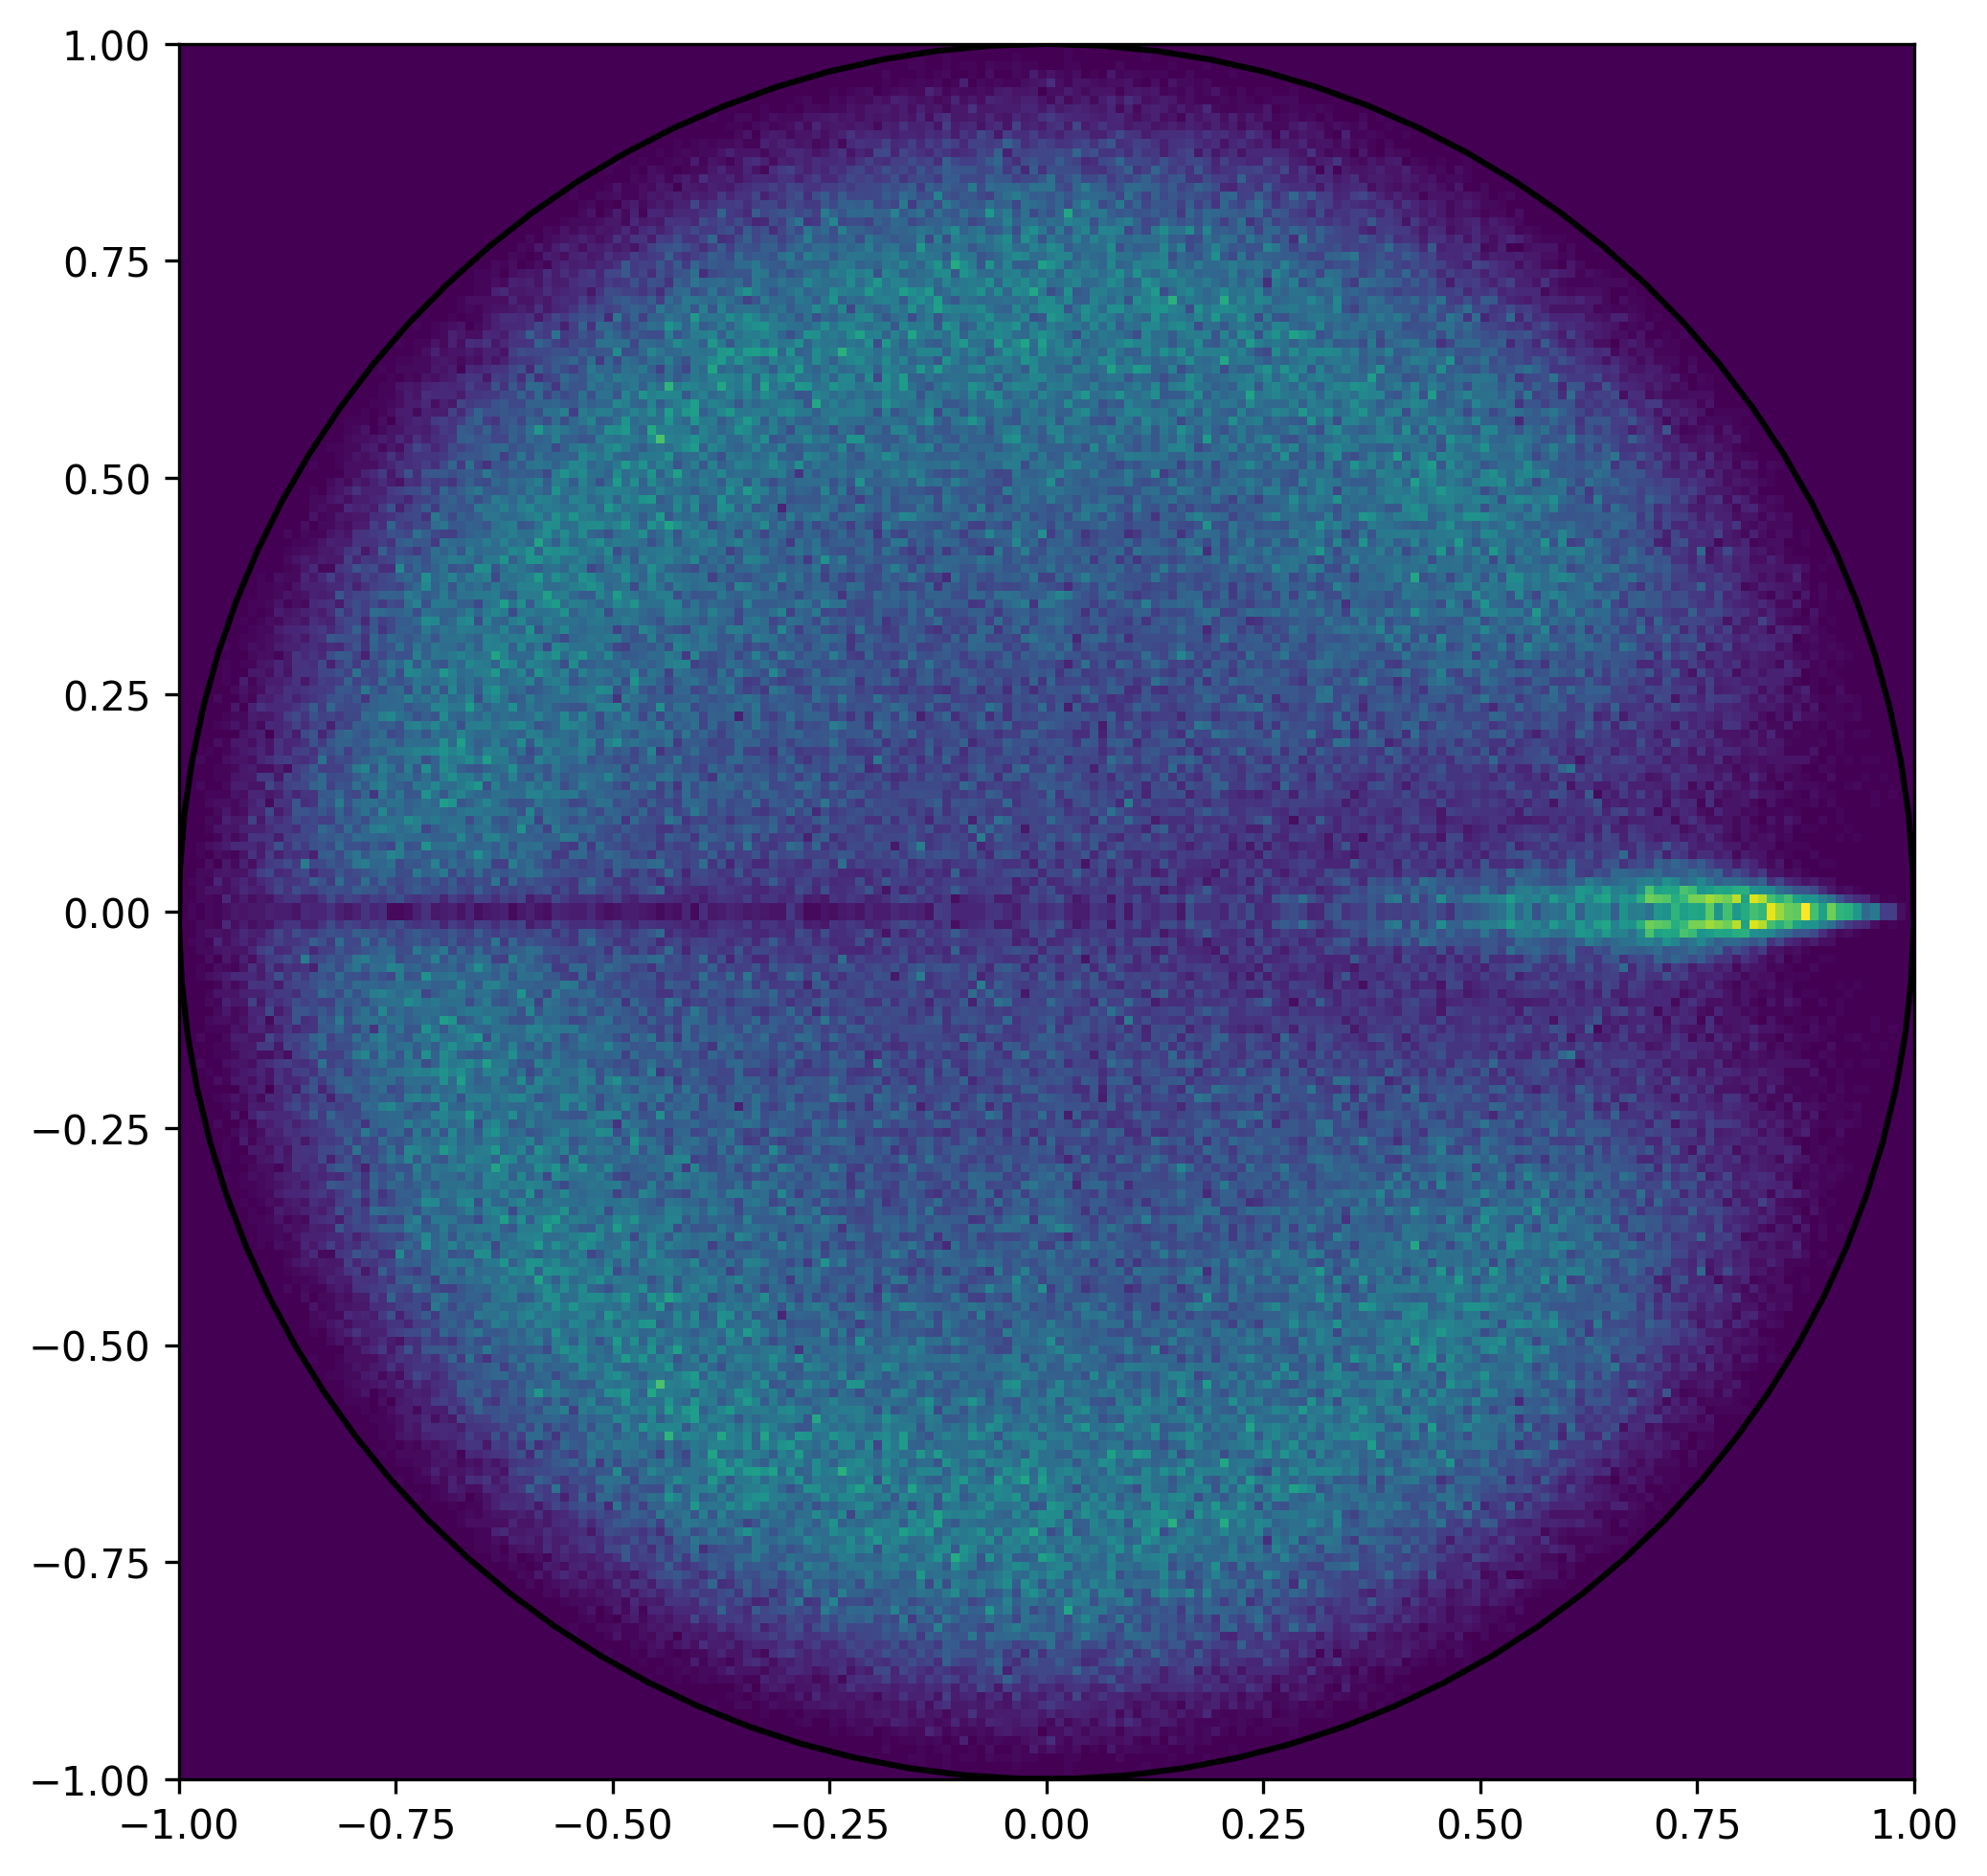

In [29]:
fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
hist, _, _, _ = plt.hist2d(*spectrum2, 
                           range = [[-1, 1], [-1, 1]], 
                           bins = [200, 200],
                          # norm = clr.LogNorm,
                          )

plt.plot(*circle, "k")
fig.savefig("../../latex/figures/threeQubit_constantDepth_density.pdf")
plt.show()

In [30]:
n = 4
d = 2**n
rank = d**2
n_eff = int(np.log2(d*rank))

random.seed(42)
np.random.seed(42)

spectrum3 = generate_spectrum_density(n=n, 
                                      rank=rank, 
                                      depth=2, 
                                      reps=1000)

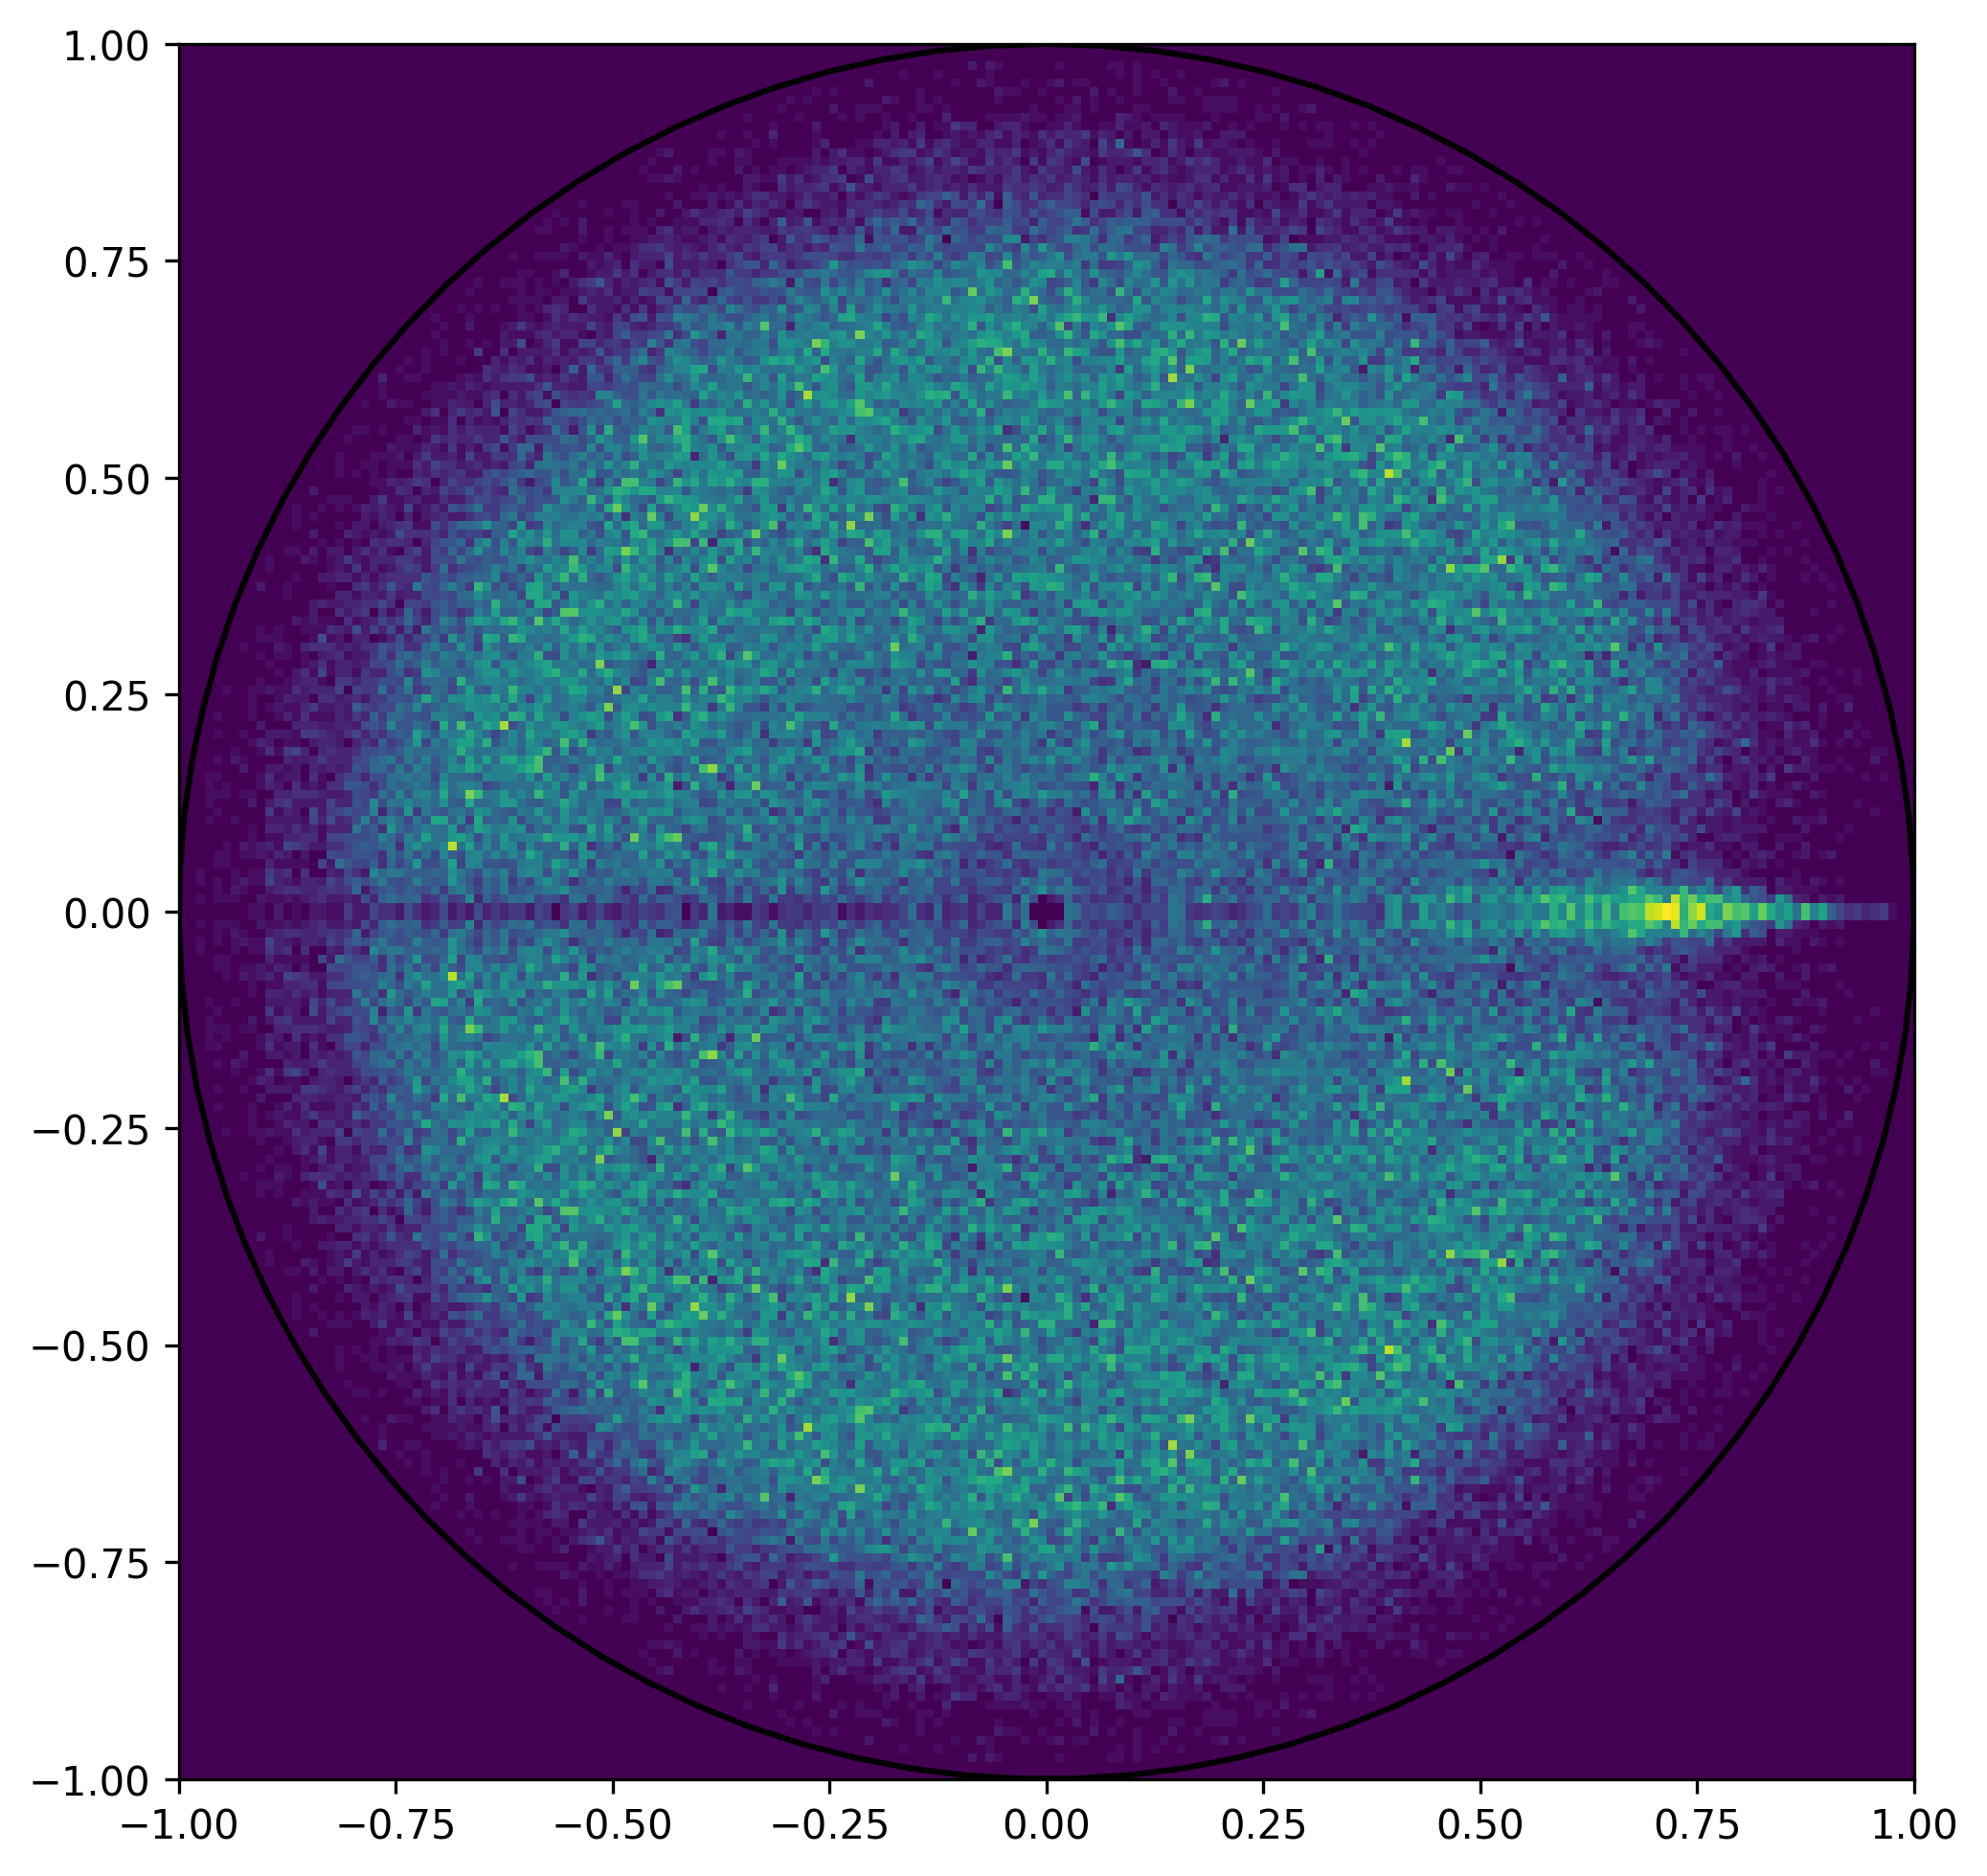

In [31]:
fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
hist, _, _, _ = plt.hist2d(*spectrum3, 
                           range = [[-1, 1], [-1, 1]], 
                           bins = [200, 200],
                          # norm = clr.LogNorm,
                          )

plt.plot(*circle, "k")
fig.savefig("../../latex/figures/fourQubit_constantDepth_density.pdf")
plt.show()

In [32]:
n = 5
d = 2**n
rank = d**2
n_eff = int(np.log2(d*rank))

random.seed(42)
np.random.seed(42)

spectrum4 = generate_spectrum_density(n=n, 
                                      rank=rank, 
                                      depth=2, 
                                      reps=100)

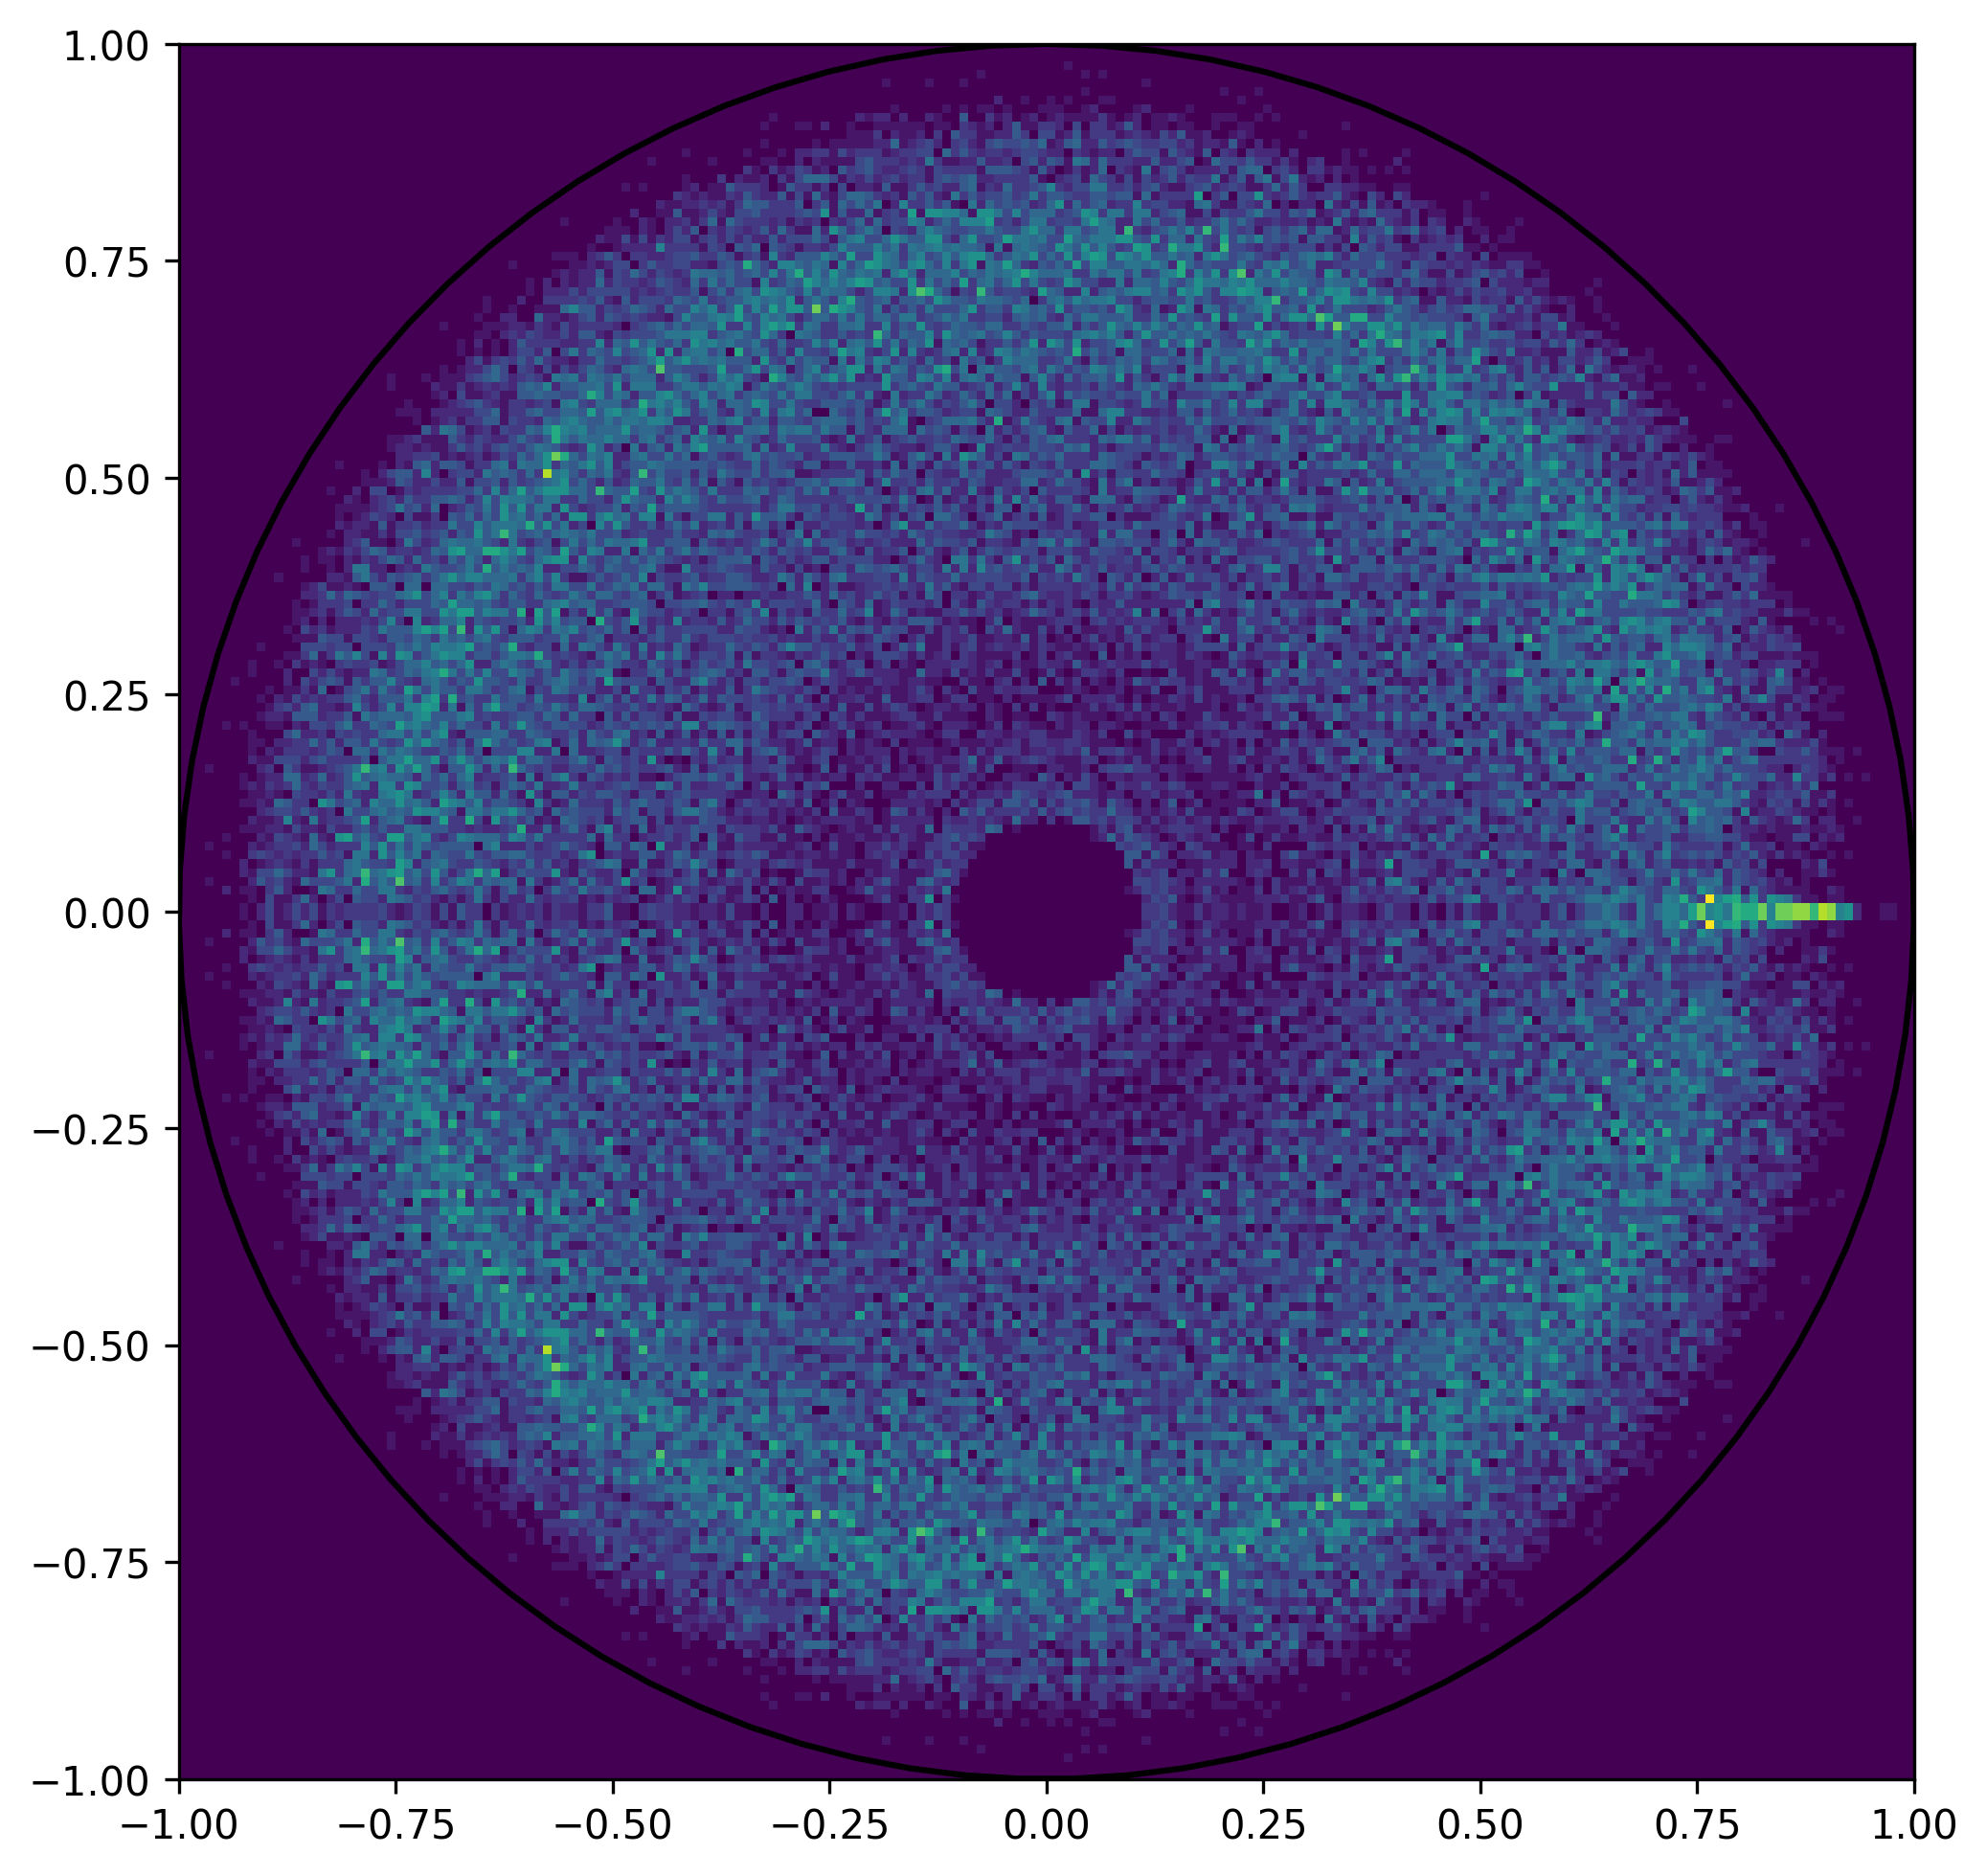

In [33]:
fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
hist, _, _, _ = plt.hist2d(*spectrum4, 
                           range = [[-1, 1], [-1, 1]], 
                           bins = [200, 200],
                          # norm = clr.LogNorm,
                          )

plt.plot(*circle, "k")
fig.savefig("../../latex/figures/fiveQubit_constantDepth_density.pdf")
plt.show()

In [41]:
n = 6
d = 2**n
rank = d**2
n_eff = int(np.log2(d*rank))

random.seed(42)
np.random.seed(42)

spectrum4 = generate_spectrum_density(n=n, 
                                      rank=rank, 
                                      depth=2, 
                                      reps=2)

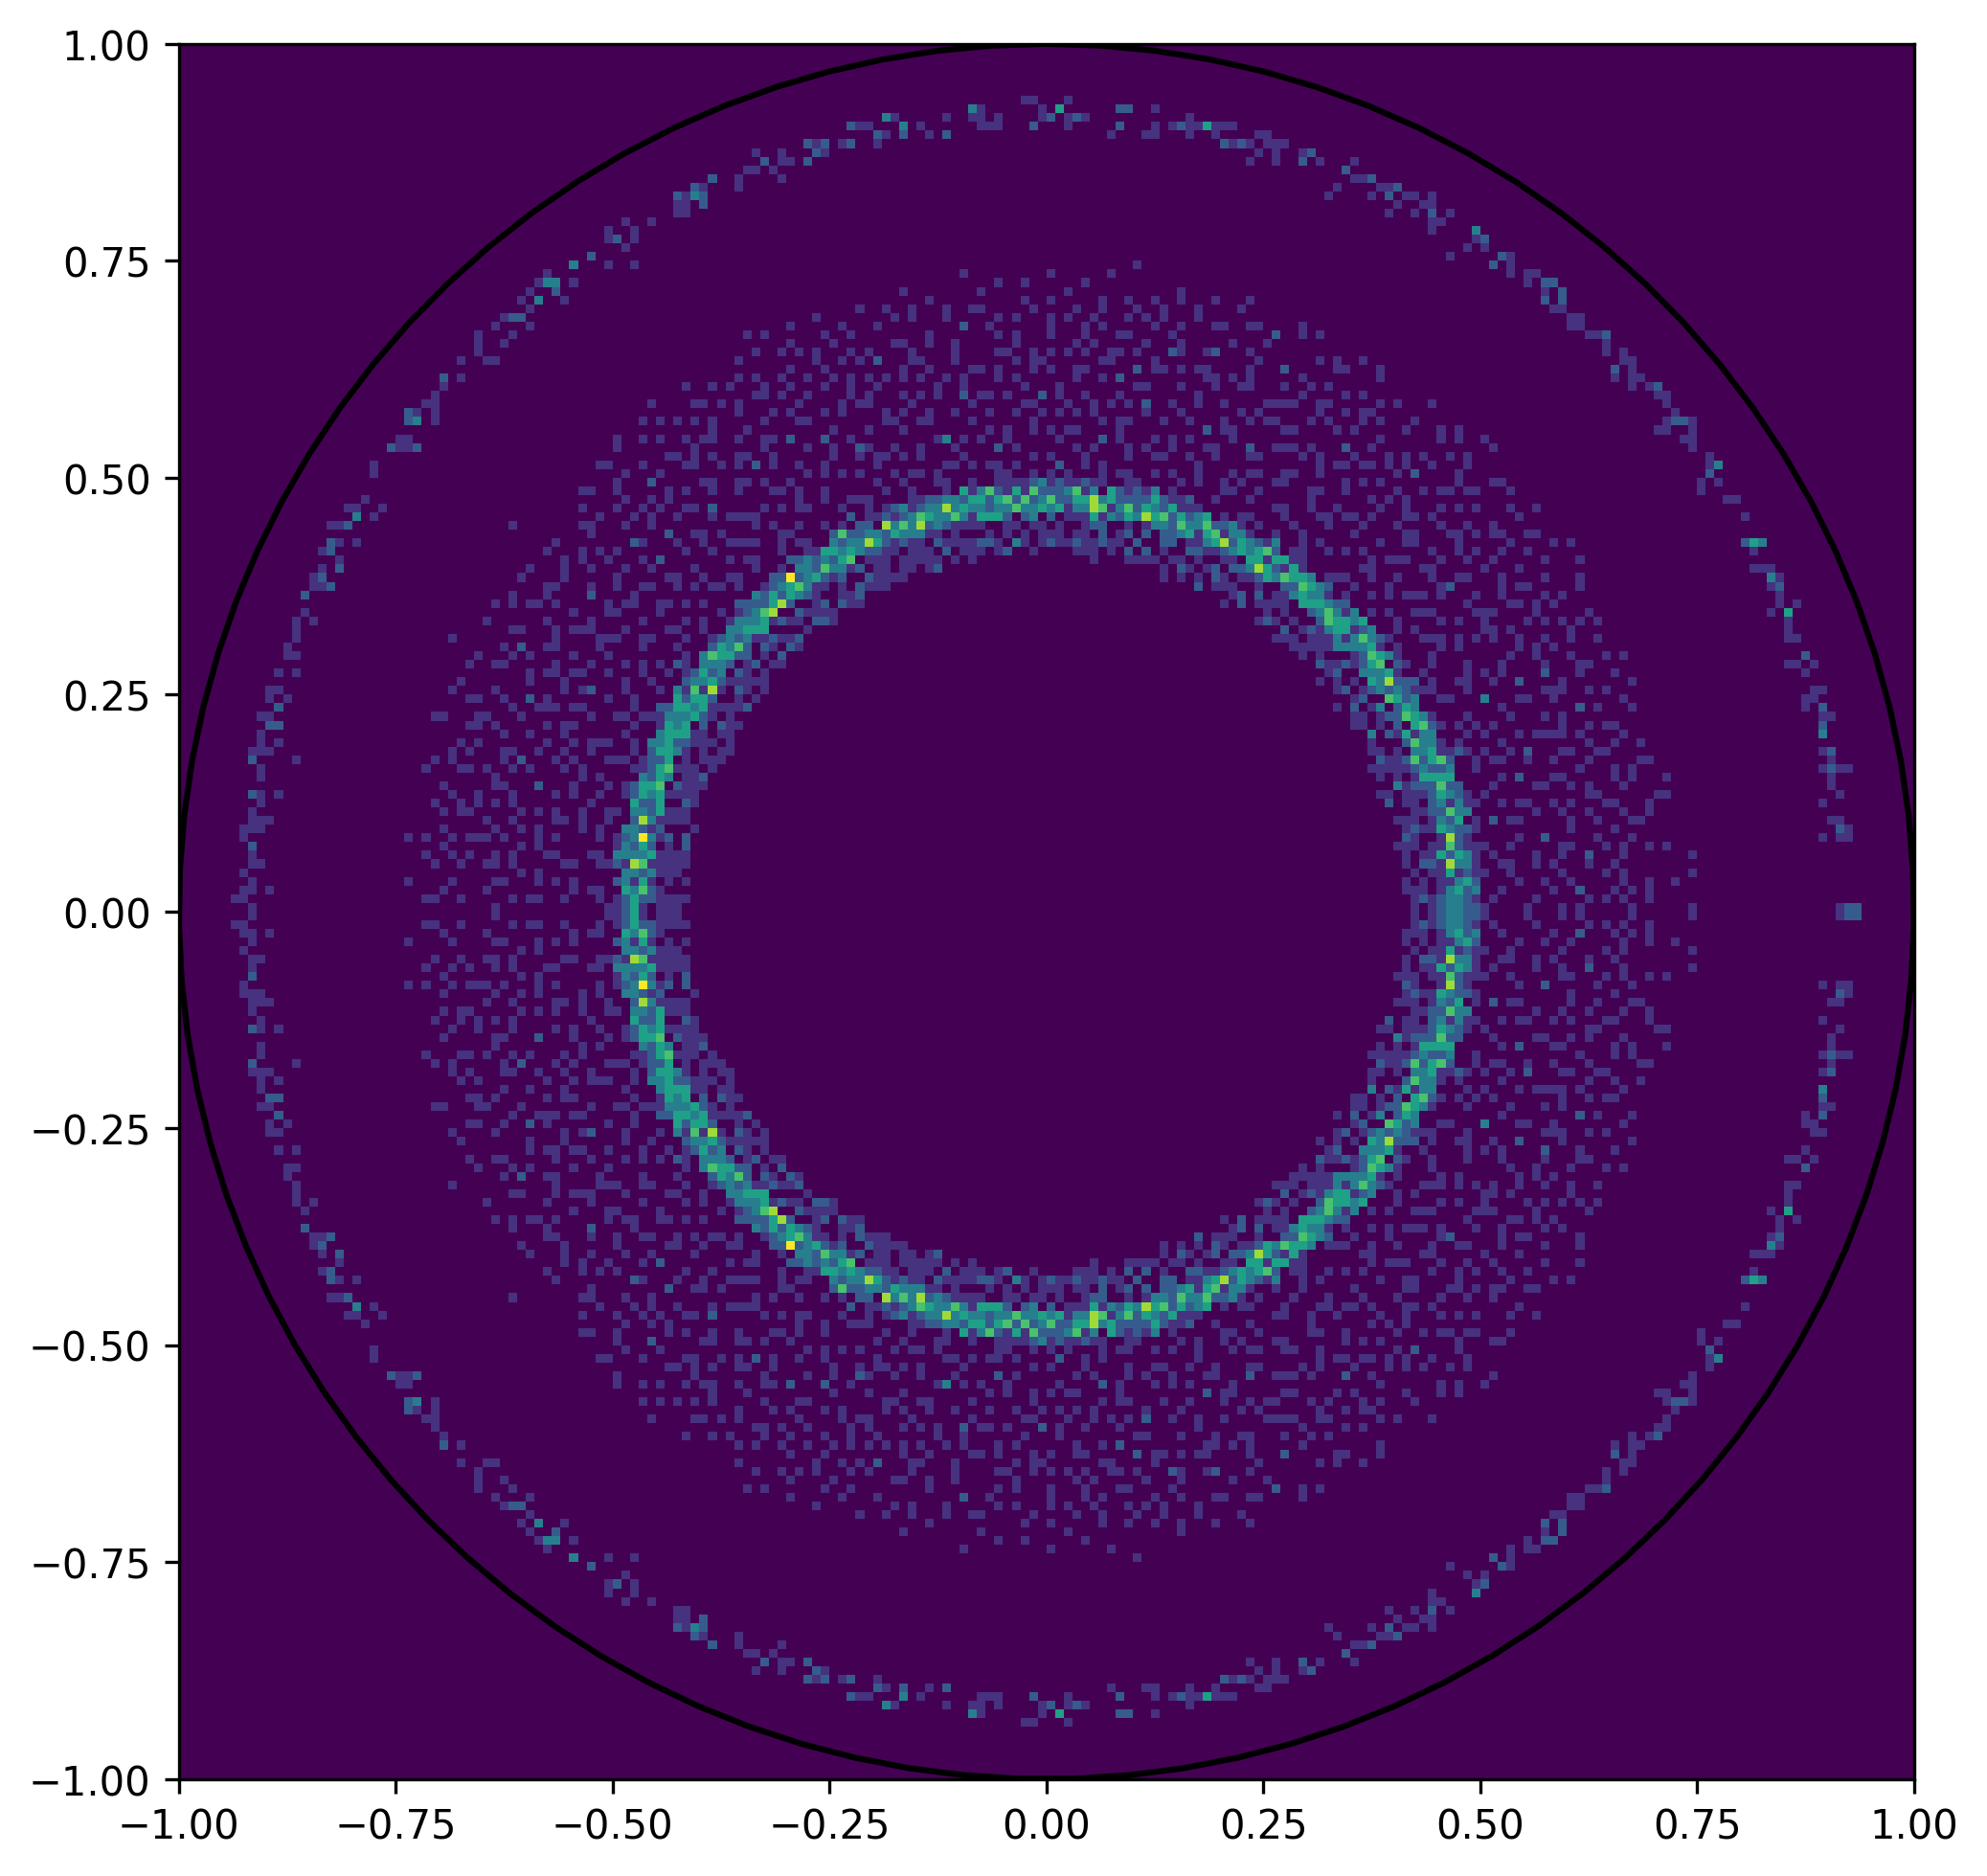

In [42]:
fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
hist, _, _, _ = plt.hist2d(*spectrum4, 
                           range = [[-1, 1], [-1, 1]], 
                           bins = [200, 200],
                          # norm = clr.LogNorm,
                          )

plt.plot(*circle, "k")
fig.savefig("../../latex/figures/sixQubit_constantDepth_density.pdf")
plt.show()

## Linear Depth

In [19]:
n = 2
d = 2**n
rank = d**2
n_eff = int(np.log2(d*rank))

random.seed(42)
np.random.seed(42)

spectrum1 = generate_spectrum_density(n=n, 
                                      rank=rank, 
                                      depth=n_eff, 
                                      reps=10000)

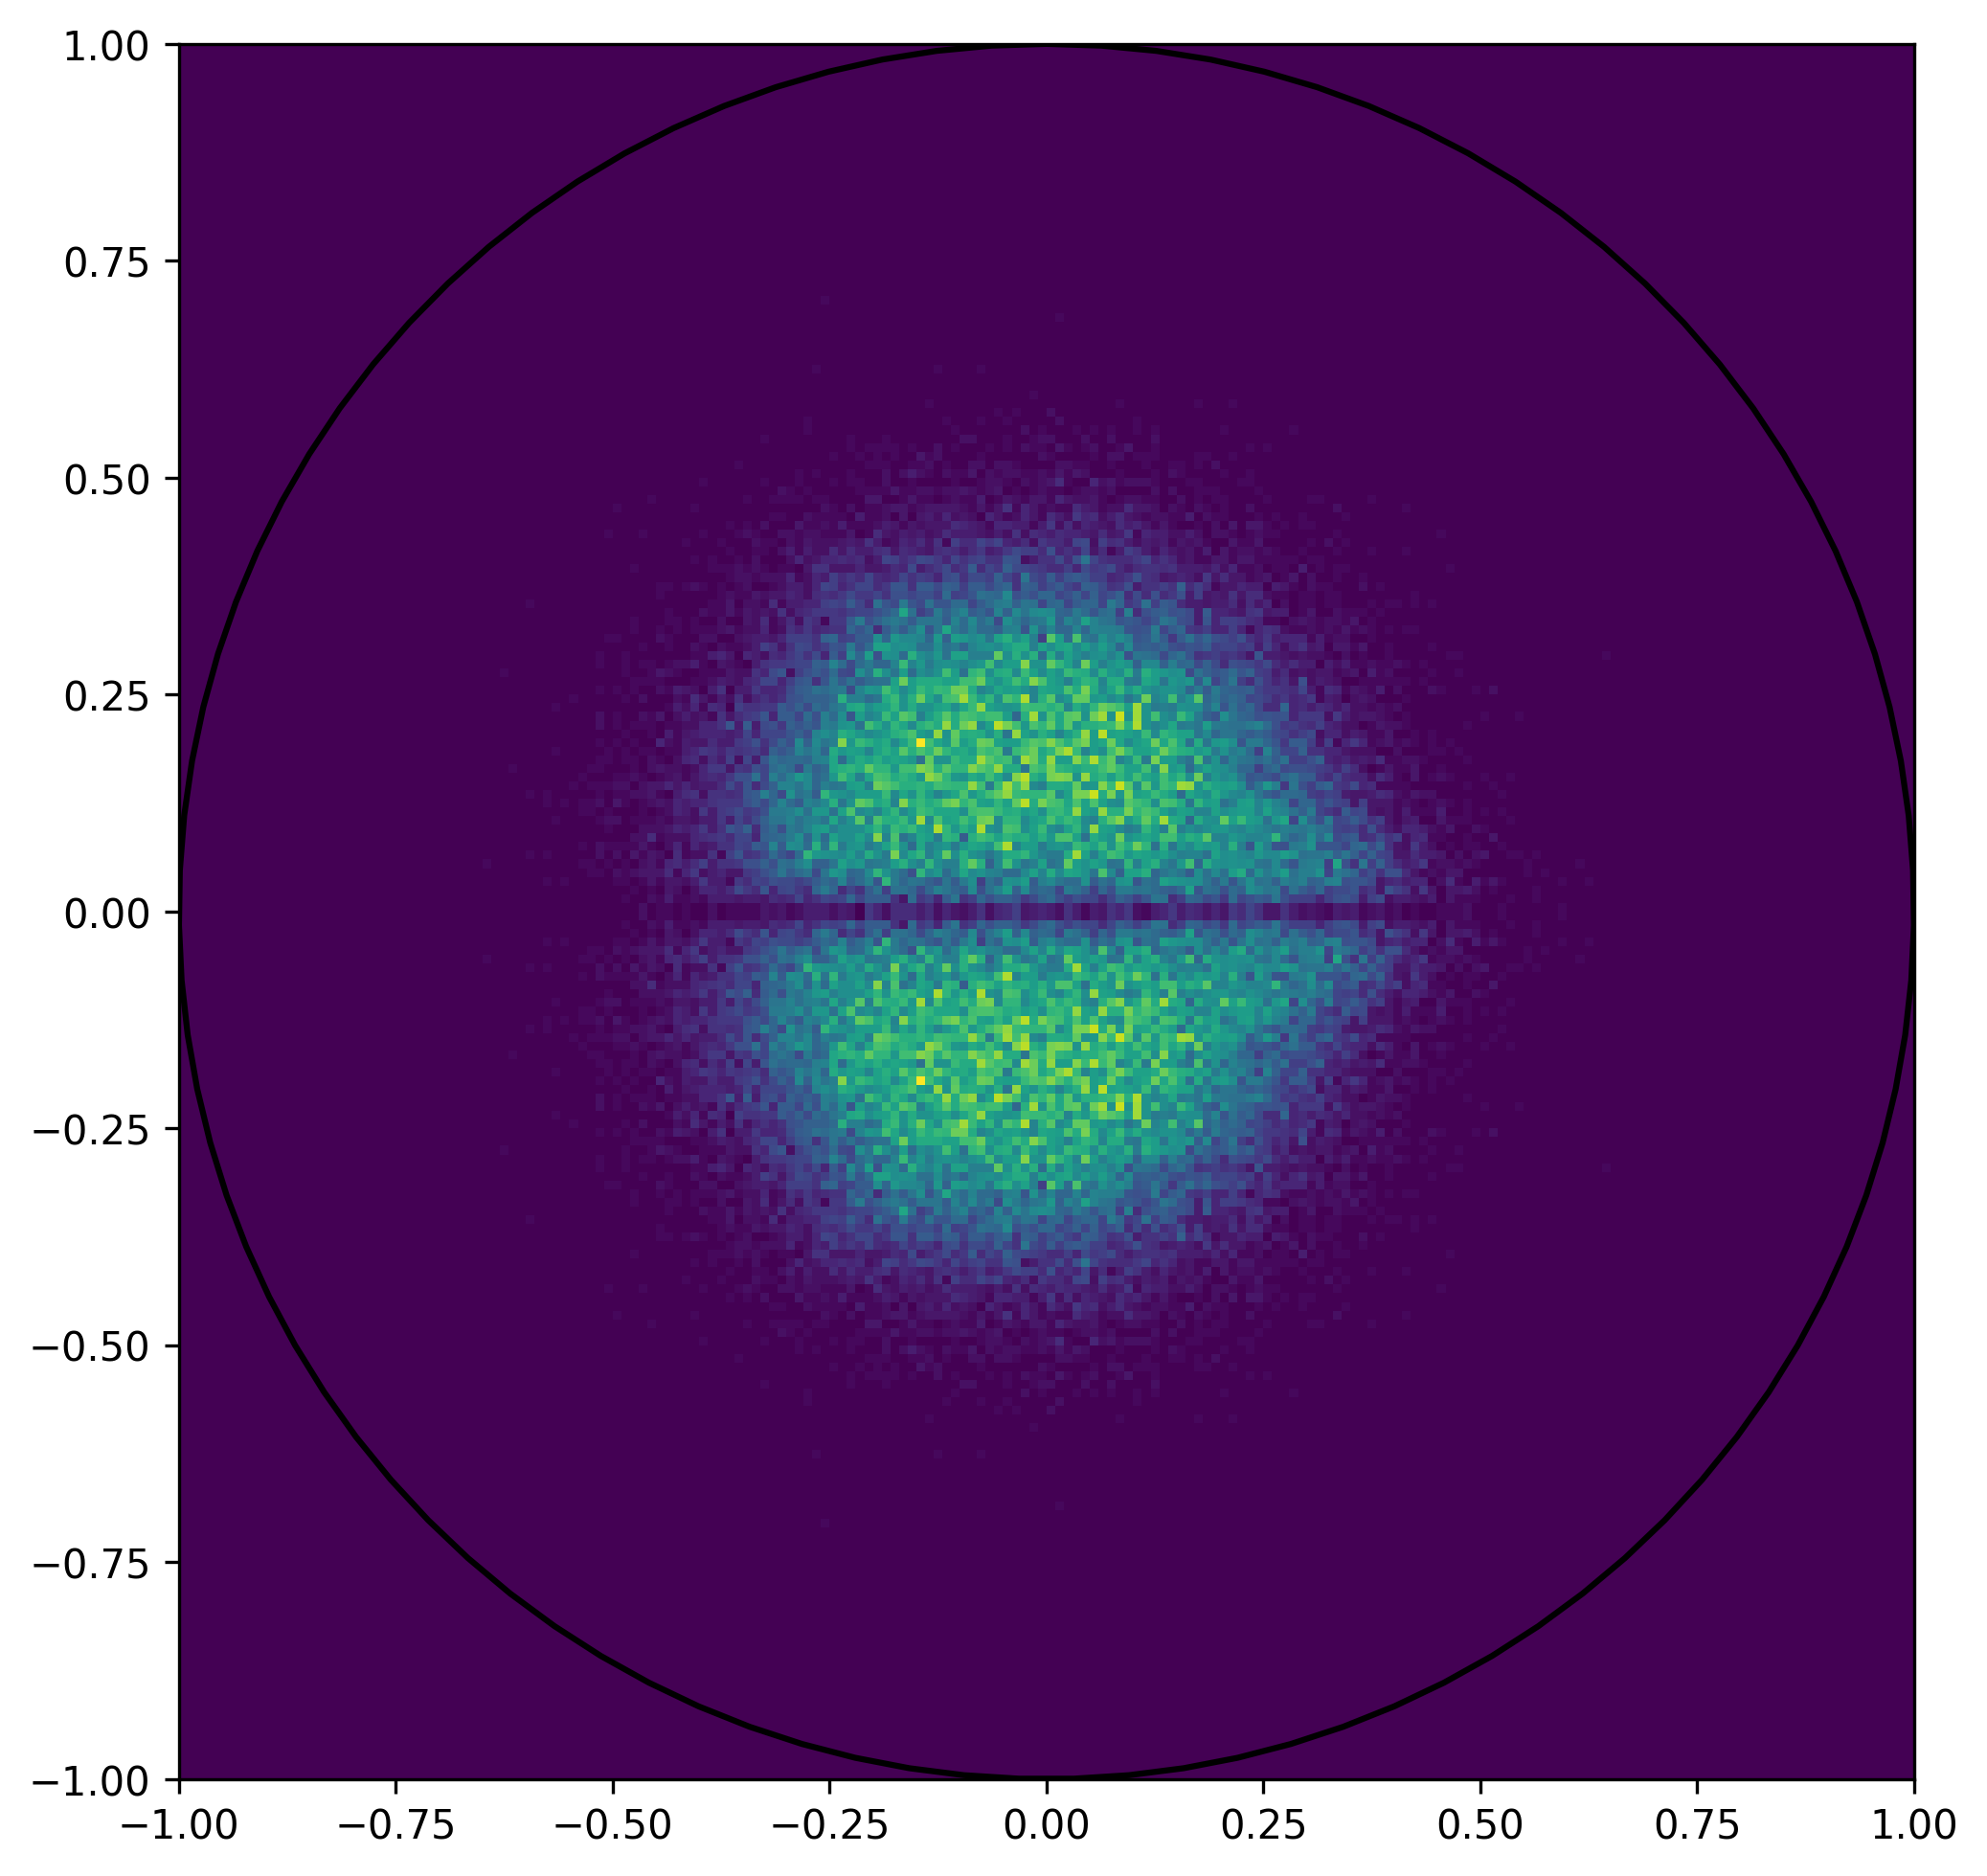

In [20]:
fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
hist, _, _, _ = plt.hist2d(*spectrum1, 
                           range = [[-1, 1], [-1, 1]], 
                           bins = [200, 200],
                          # norm = clr.LogNorm,
                          )

plt.plot(*circle, "k")
plt.show()

In [21]:
n = 3
d = 2**n
rank = d**2
n_eff = int(np.log2(d*rank))

random.seed(42)
np.random.seed(42)

spectrum2 = generate_spectrum_density(n=n, 
                                      rank=rank, 
                                      depth=n_eff, 
                                      reps=1000)

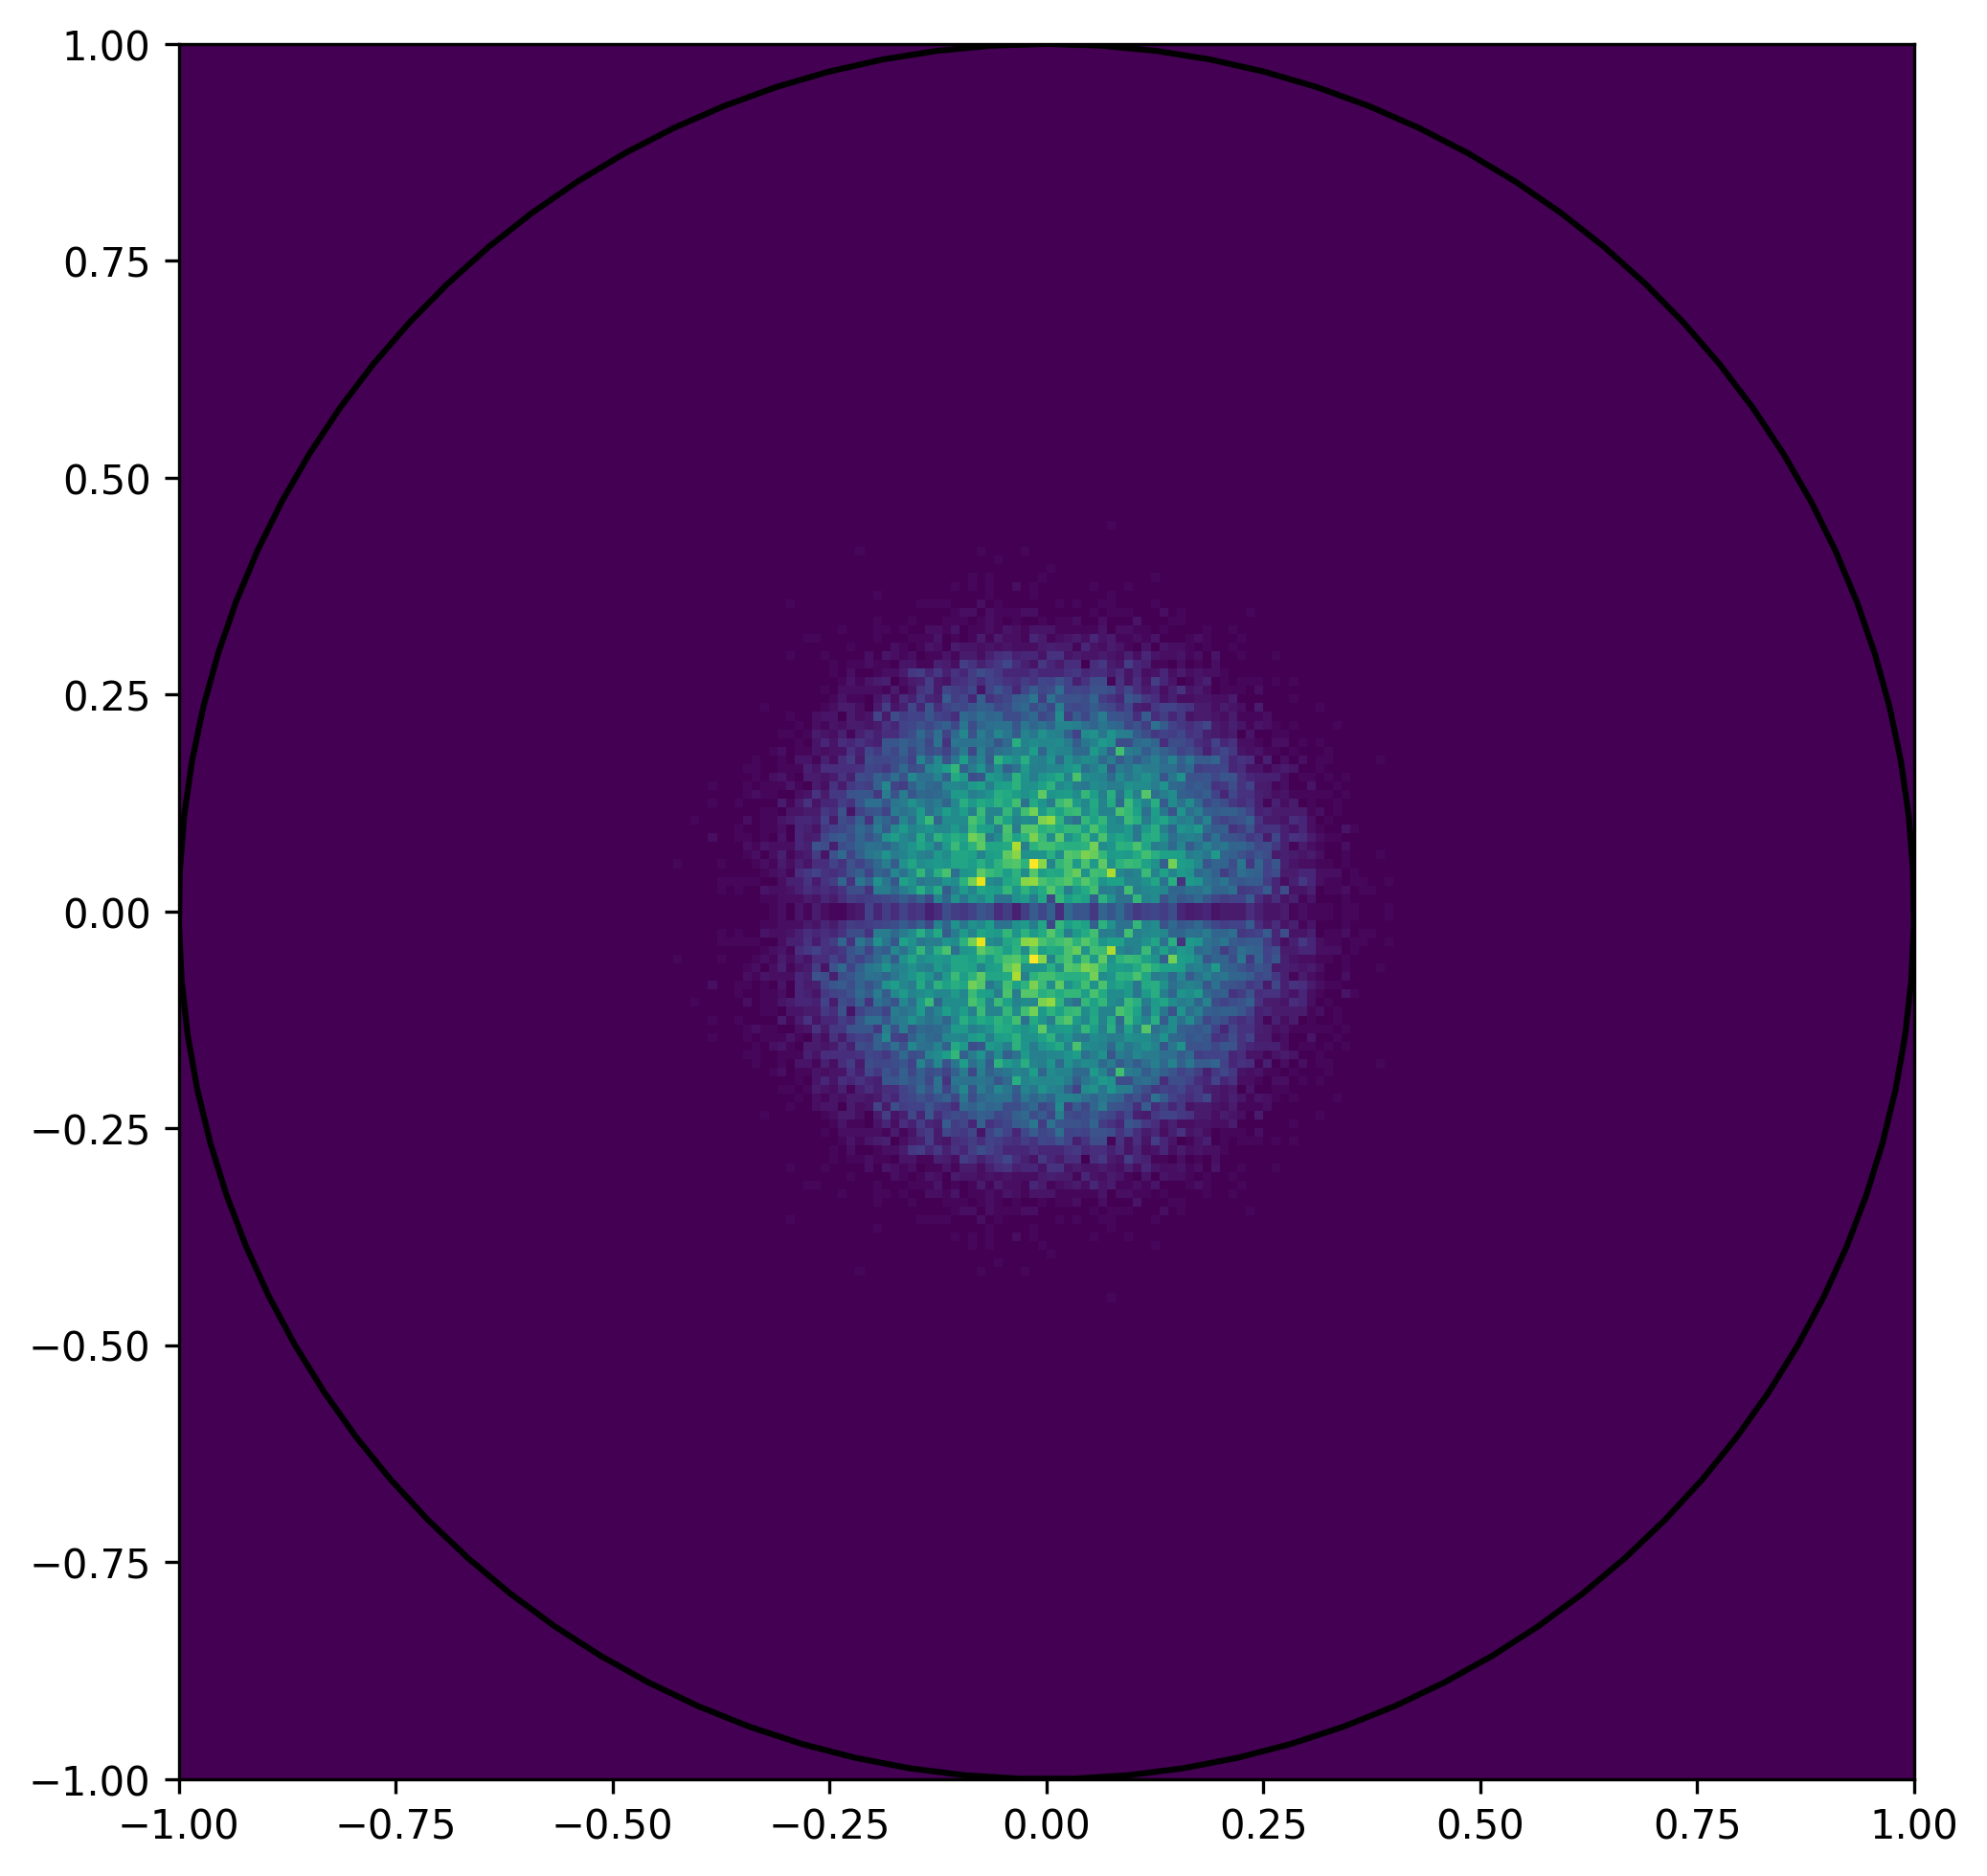

In [22]:
fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
hist, _, _, _ = plt.hist2d(*spectrum2, 
                           range = [[-1, 1], [-1, 1]], 
                           bins = [200, 200],
                          # norm = clr.LogNorm,
                          )

plt.plot(*circle, "k")
plt.show()

In [23]:
n = 4
d = 2**n
rank = d**2
n_eff = int(np.log2(d*rank))

random.seed(42)
np.random.seed(42)

spectrum3 = generate_spectrum_density(n=n, 
                                      rank=rank, 
                                      depth=n_eff, 
                                      reps=100)

KeyboardInterrupt: 

In [ ]:
fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
hist, _, _, _ = plt.hist2d(*spectrum3, 
                           range = [[-1, 1], [-1, 1]], 
                           bins = [200, 200],
                          # norm = clr.LogNorm,
                          )

plt.plot(*circle, "k")
plt.show()

In [ ]:
n = 5
d = 2**n
rank = d**2
n_eff = int(np.log2(d*rank))

random.seed(42)
np.random.seed(42)

spectrum4 = generate_spectrum_density(n=n, 
                                      rank=rank, 
                                      depth=n_eff, 
                                      reps=10)

In [ ]:
fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
hist, _, _, _ = plt.hist2d(*spectrum4, 
                           range = [[-1, 1], [-1, 1]], 
                           bins = [200, 200],
                          # norm = clr.LogNorm,
                          )

plt.plot(*circle, "k")
plt.show()

## Structured Unitary Plus Random Kraus

### Two Qubits

In [36]:
circuit = qft(4)
print(circuit)

     ┌───┐                                                                     
q_0: ┤ H ├─■────────■─────────────■────────────────────────────────────────────
     └───┘ │P(π/2)  │       ┌───┐ │                                            
q_1: ──────■────────┼───────┤ H ├─┼────────■────────■──────────────────────────
                    │P(π/4) └───┘ │        │P(π/2)  │       ┌───┐              
q_2: ───────────────■─────────────┼────────■────────┼───────┤ H ├─■────────────
                                  │P(π/8)           │P(π/4) └───┘ │P(π/2) ┌───┐
q_3: ─────────────────────────────■─────────────────■─────────────■───────┤ H ├
                                                                          └───┘


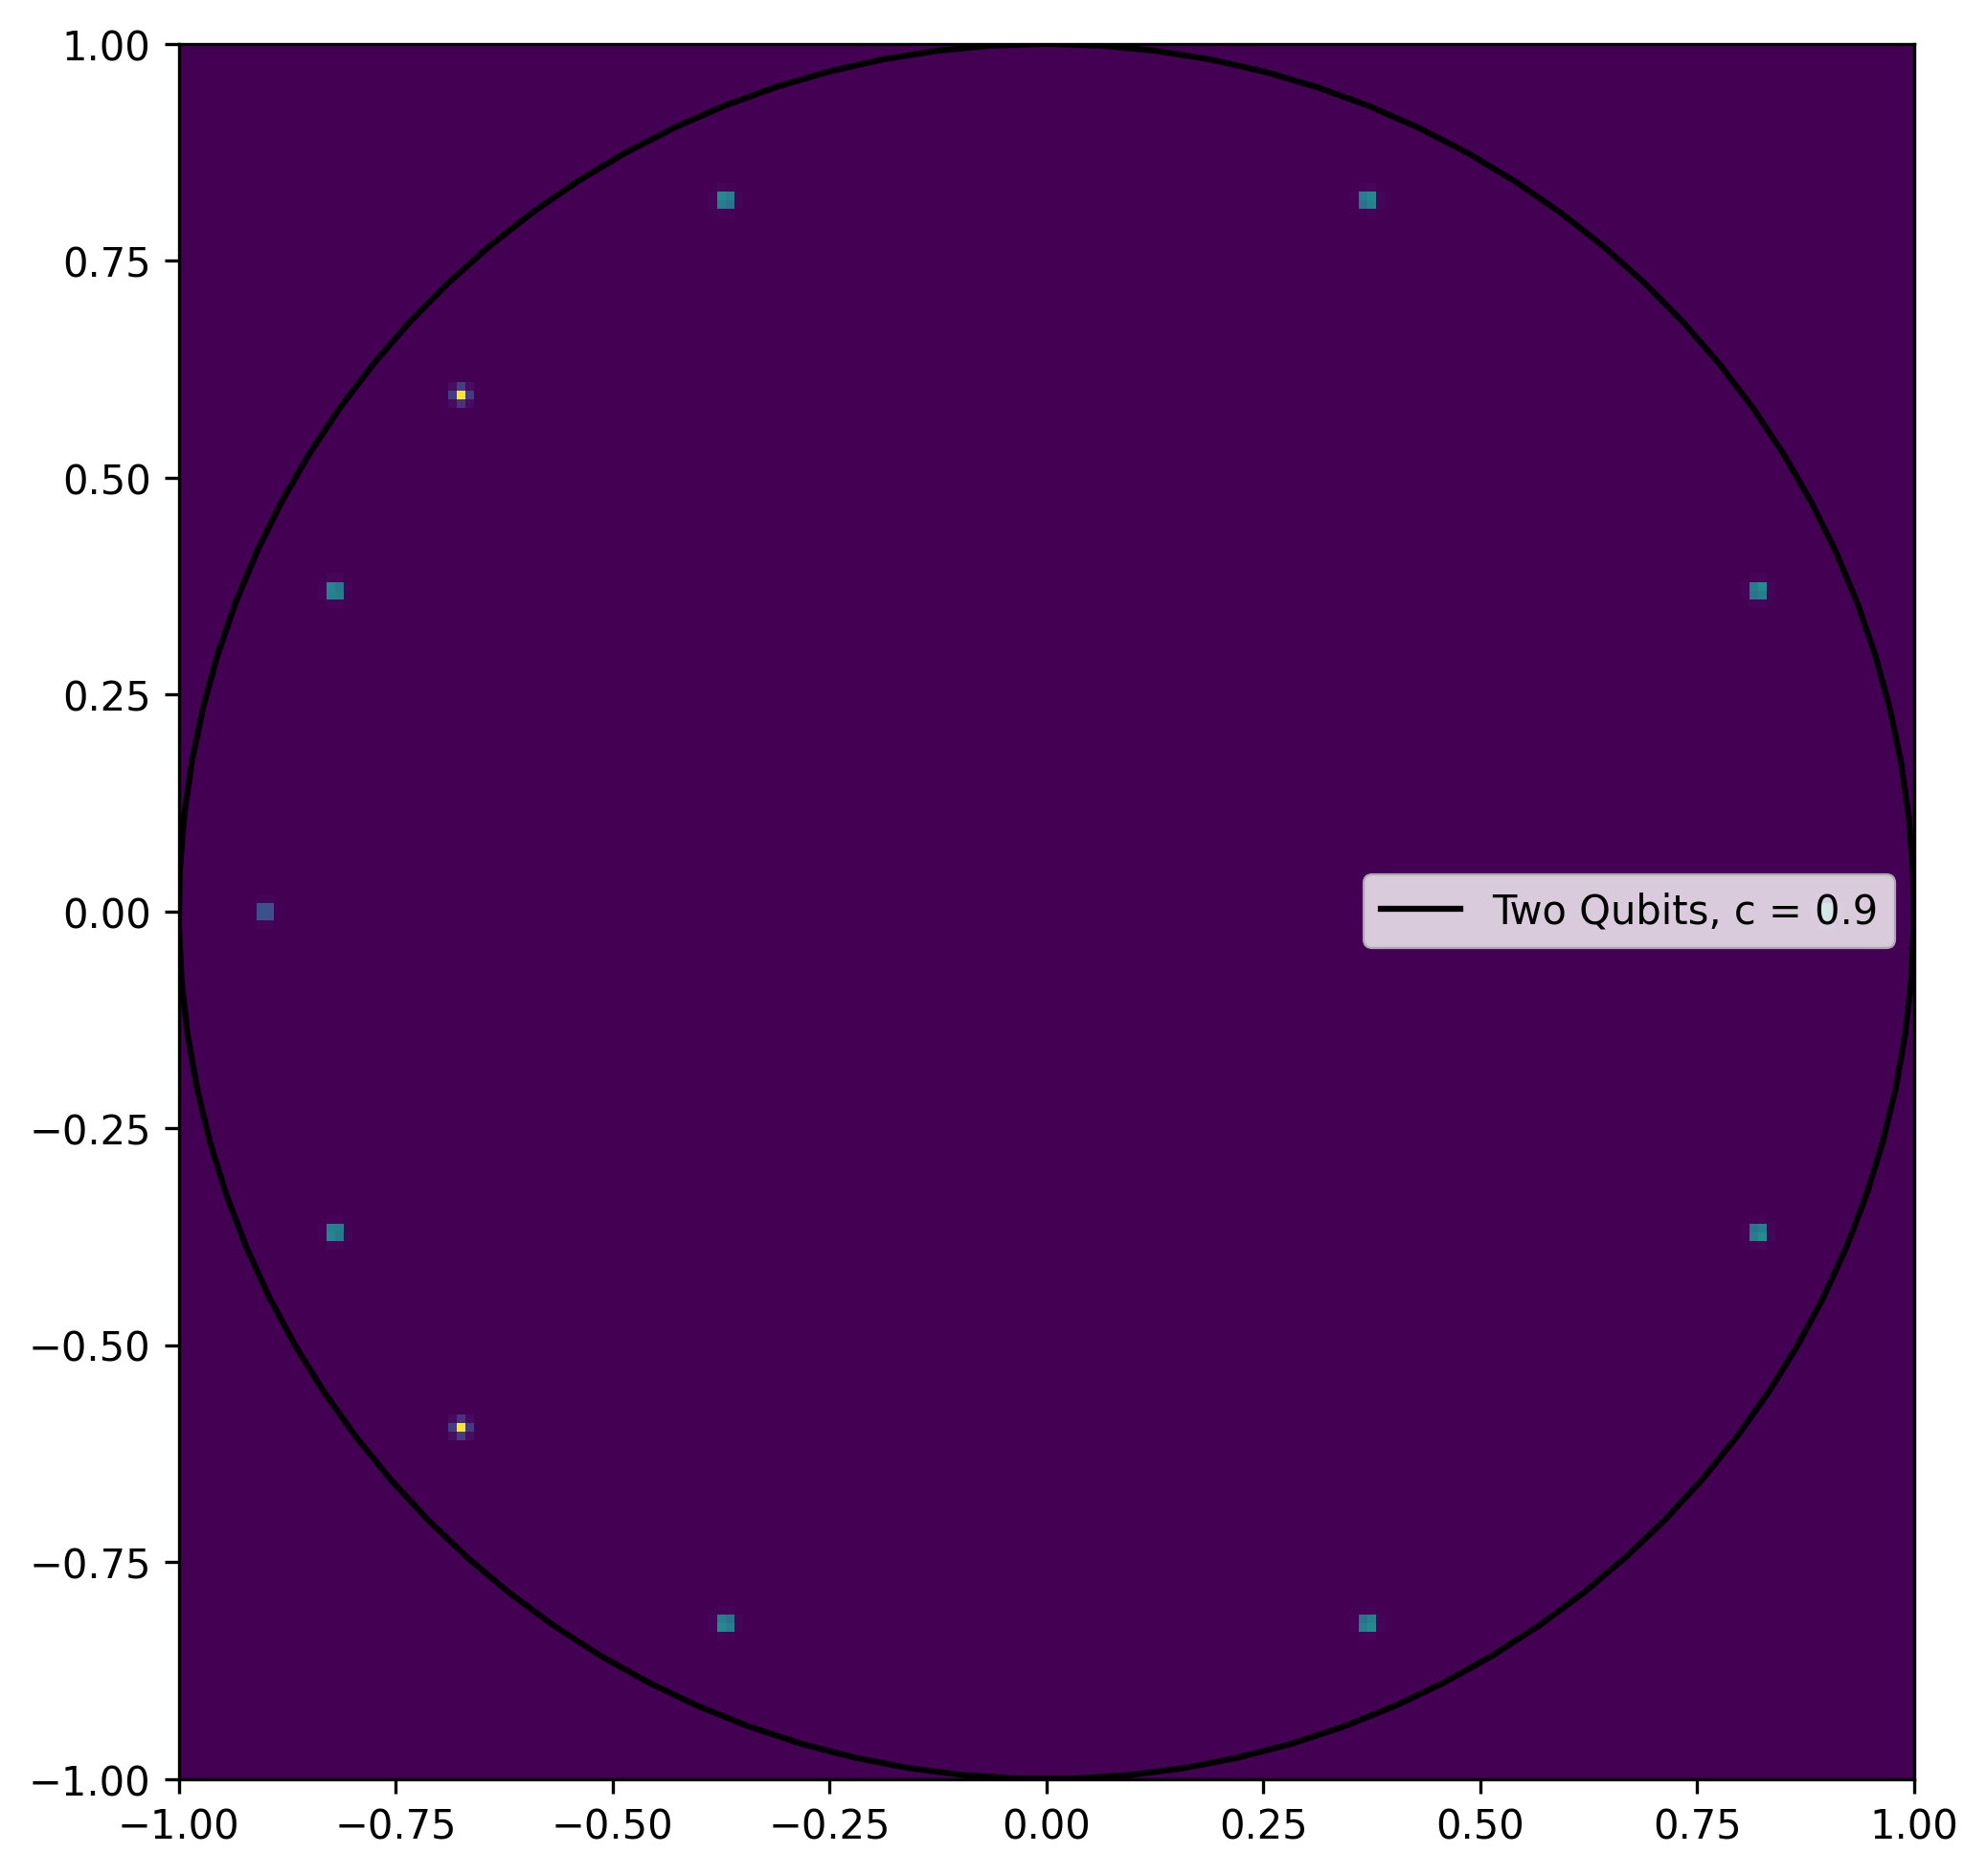

In [19]:
n = 2
circuit = qft(n)

U = Operator(circuit).data
random.seed(42)
np.random.seed(42)
spectrum1 = generate_spectrum_mixed(U = U, 
                                    c = 0.9, 
                                    reps = 10000)

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.hist2d(*spectrum1, 
            range = [[-1, 1], [-1, 1]], 
            bins = [200, 200],
            # norm = clr.LogNorm,
           )

plt.plot(*circle, "k")
plt.legend(["Two Qubits, c = 0.9"])
plt.show()

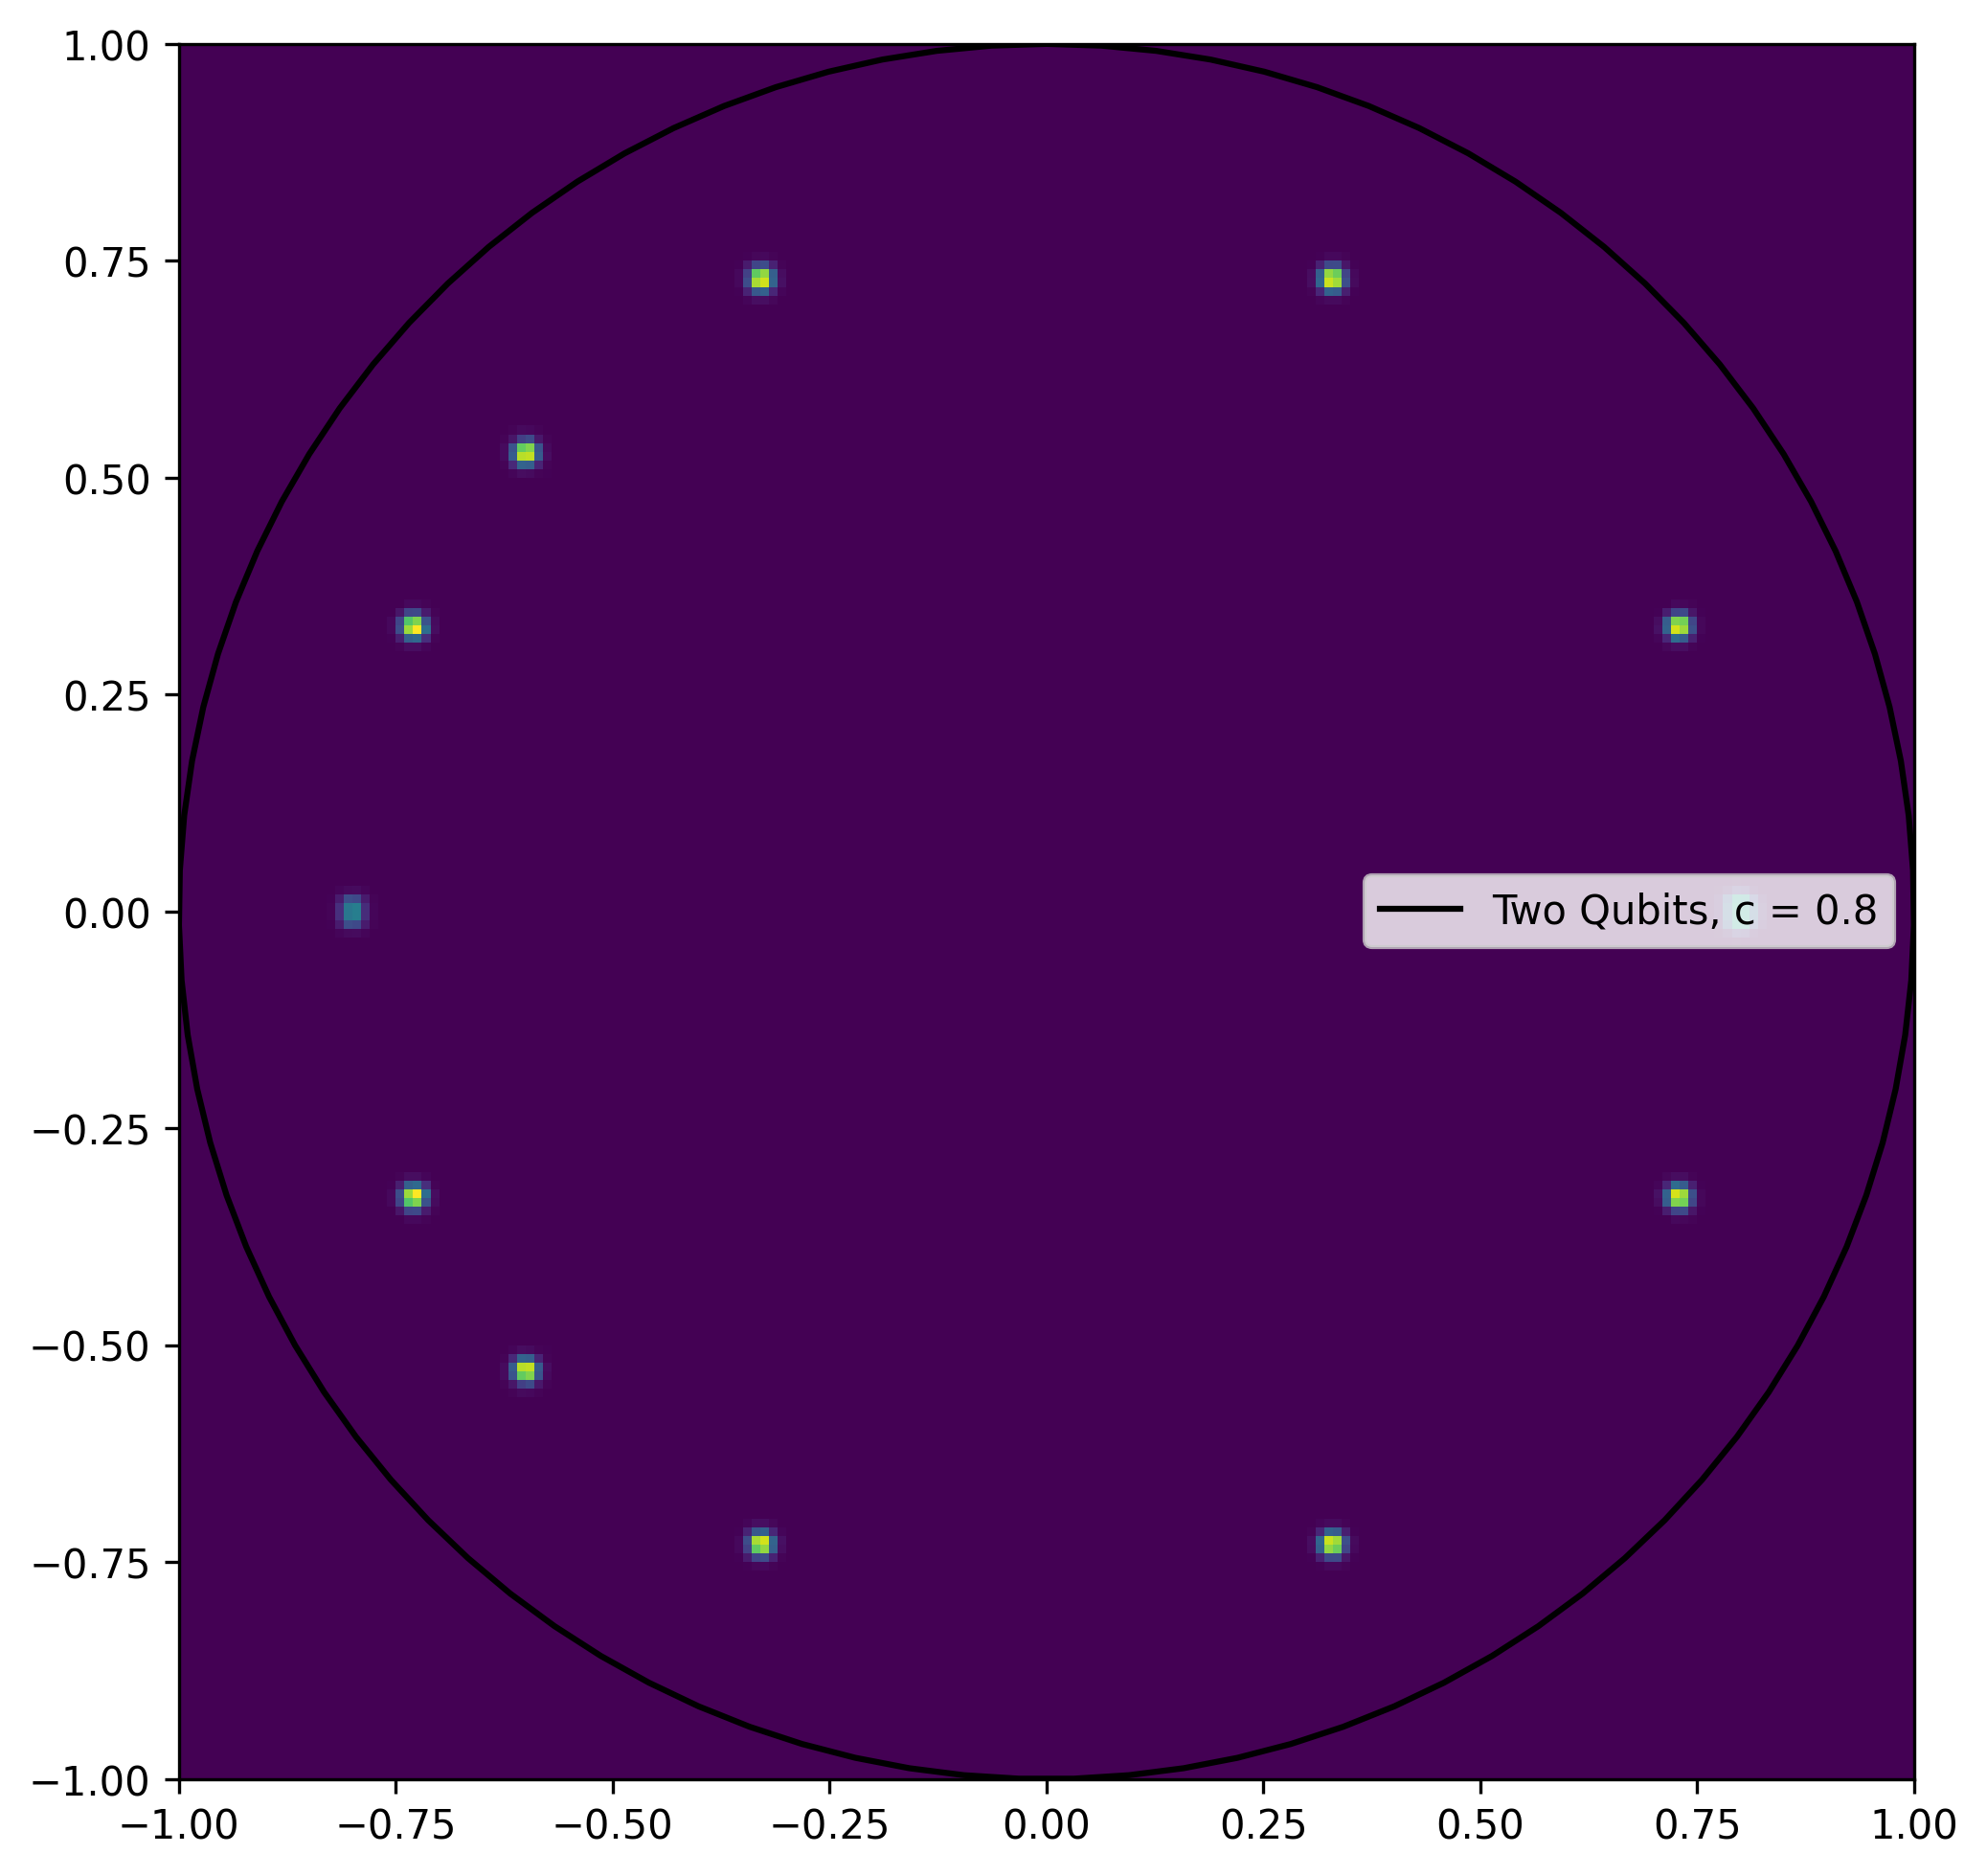

In [20]:
n = 2
circuit = qft(n)

U = Operator(circuit).data
random.seed(42)
np.random.seed(42)
spectrum1 = generate_spectrum_mixed(U = U, 
                                    c = 0.8, 
                                    reps = 10000)

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.hist2d(*spectrum1, 
            range = [[-1, 1], [-1, 1]], 
            bins = [200, 200],
            # norm = clr.LogNorm,
           )

plt.plot(*circle, "k")
plt.legend(["Two Qubits, c = 0.8"])
plt.show()

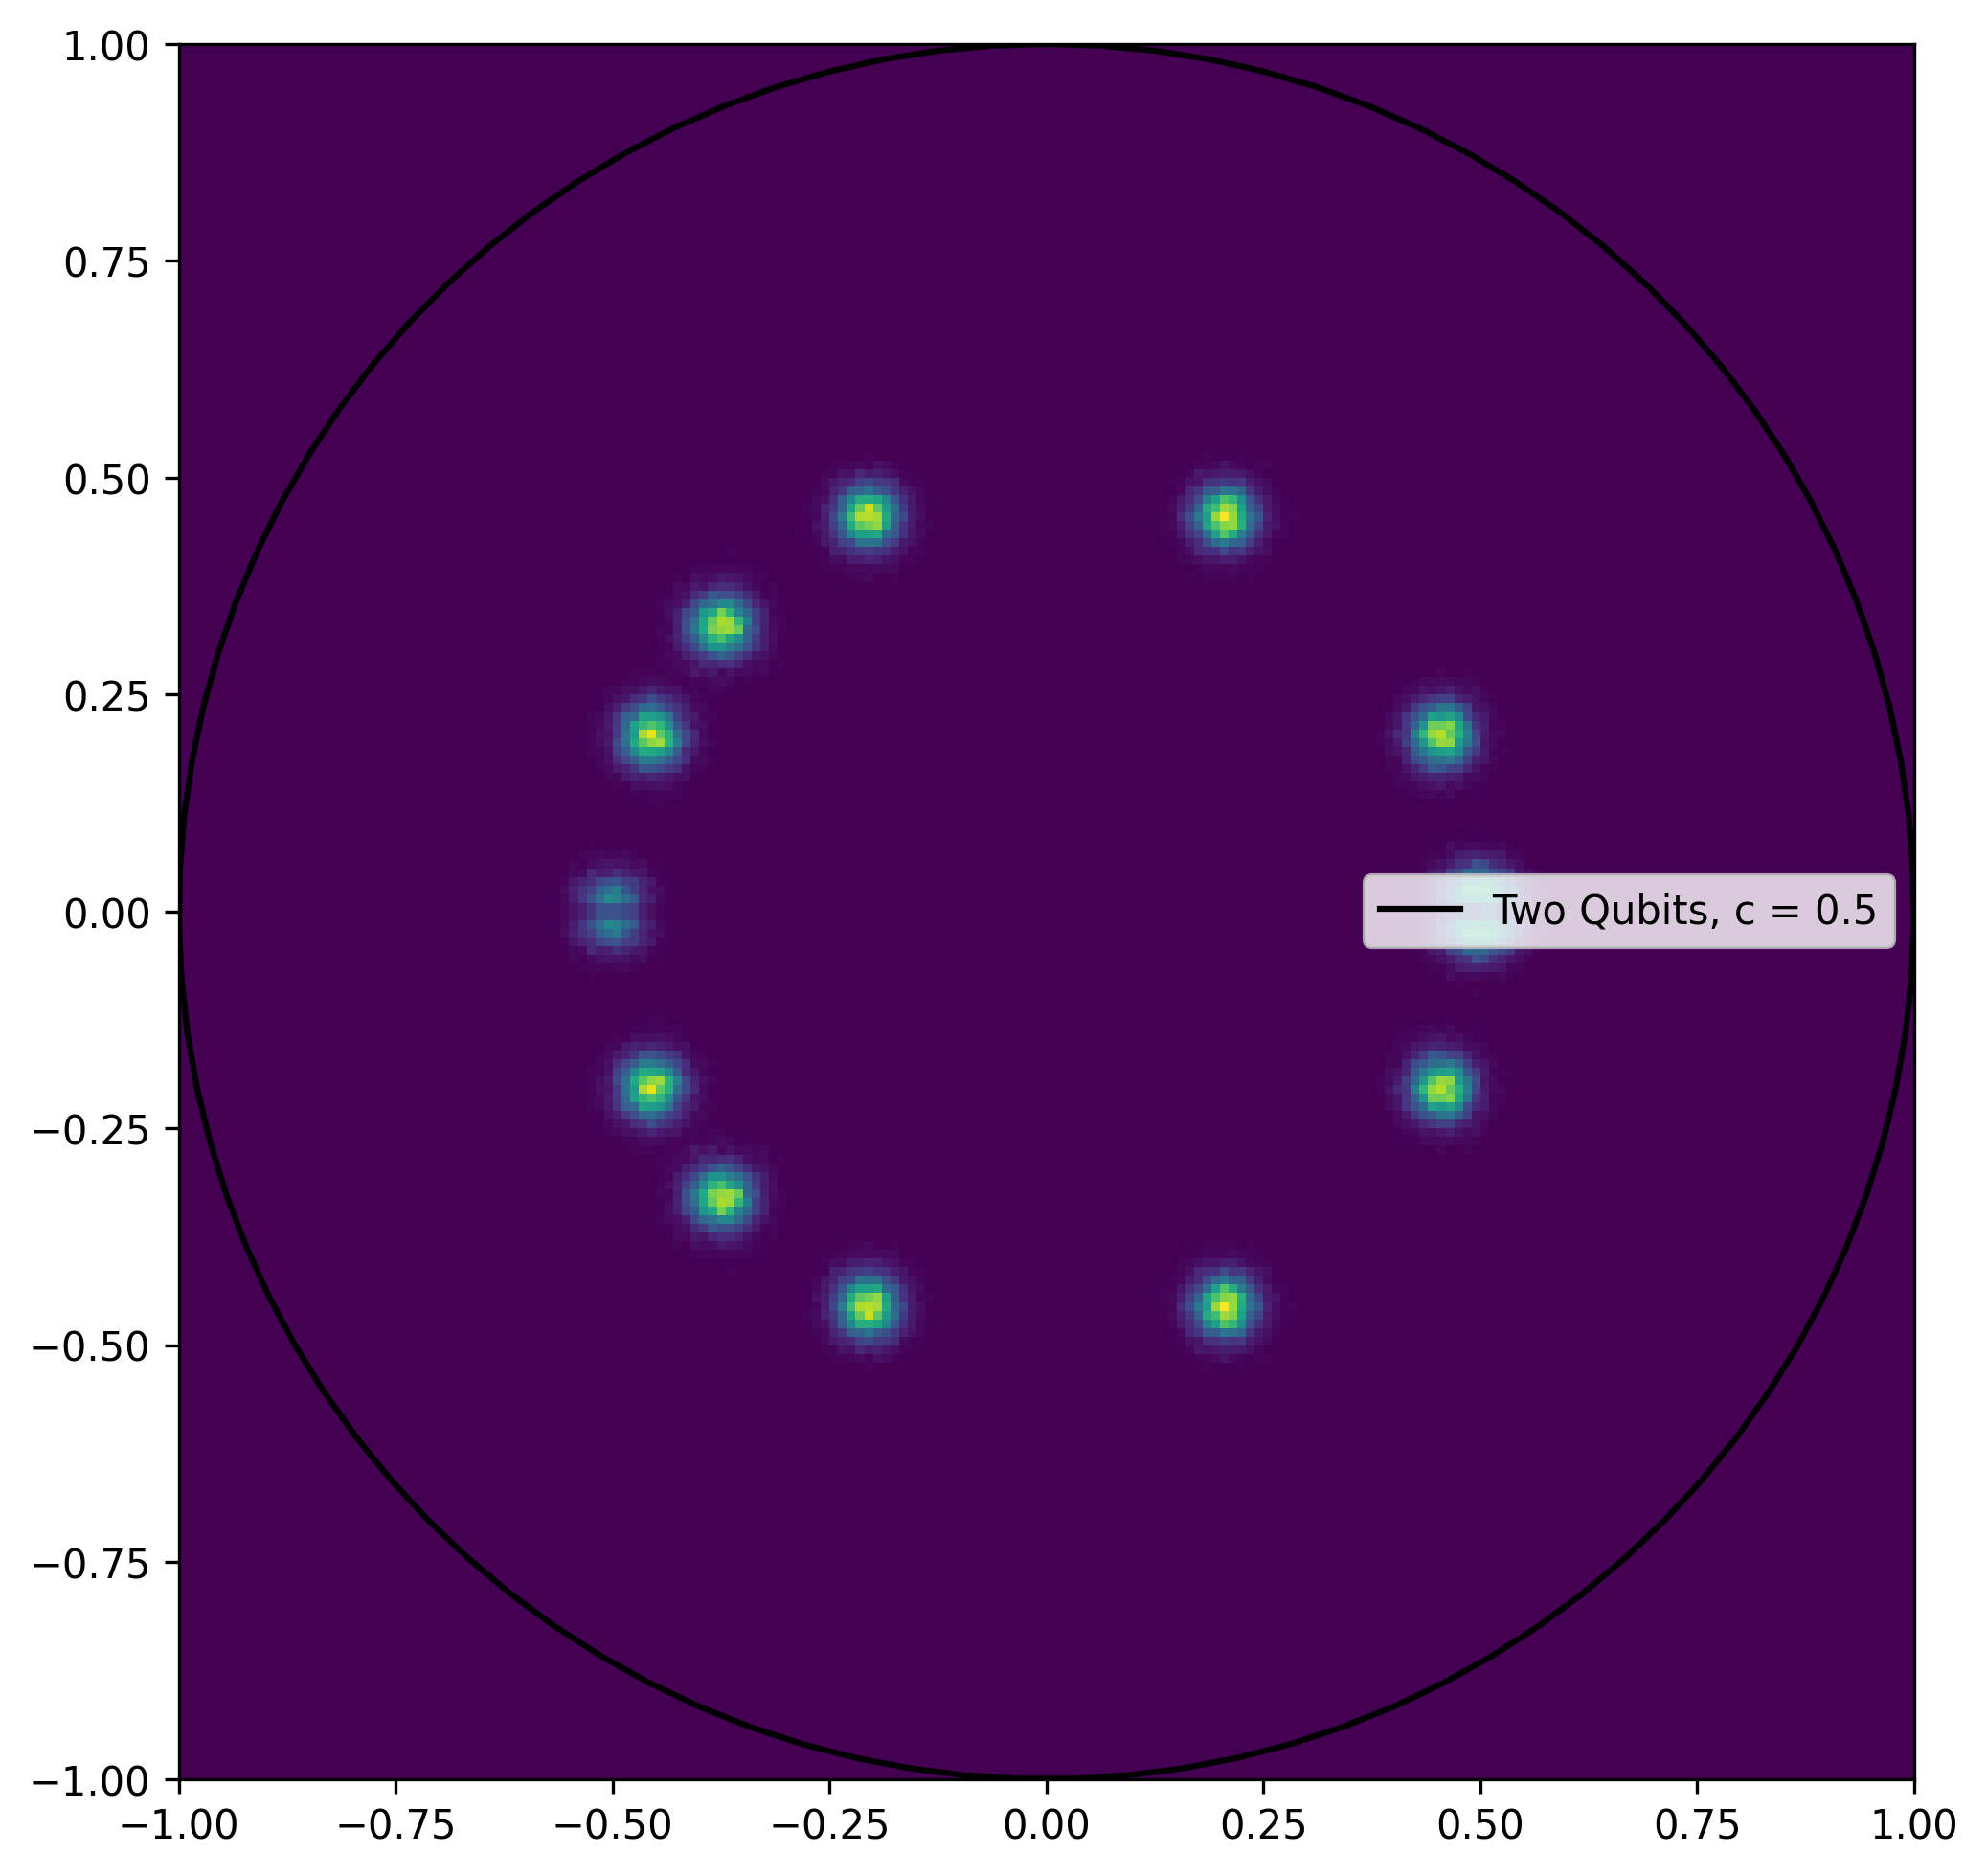

In [21]:
n = 2
circuit = qft(n)

U = Operator(circuit).data
random.seed(42)
np.random.seed(42)
spectrum1 = generate_spectrum_mixed(U = U, 
                                    c = 0.5, 
                                    reps = 10000)

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.hist2d(*spectrum1, 
            range = [[-1, 1], [-1, 1]], 
            bins = [200, 200],
            # norm = clr.LogNorm,
           )

plt.plot(*circle, "k")
plt.legend(["Two Qubits, c = 0.5"])
plt.show()

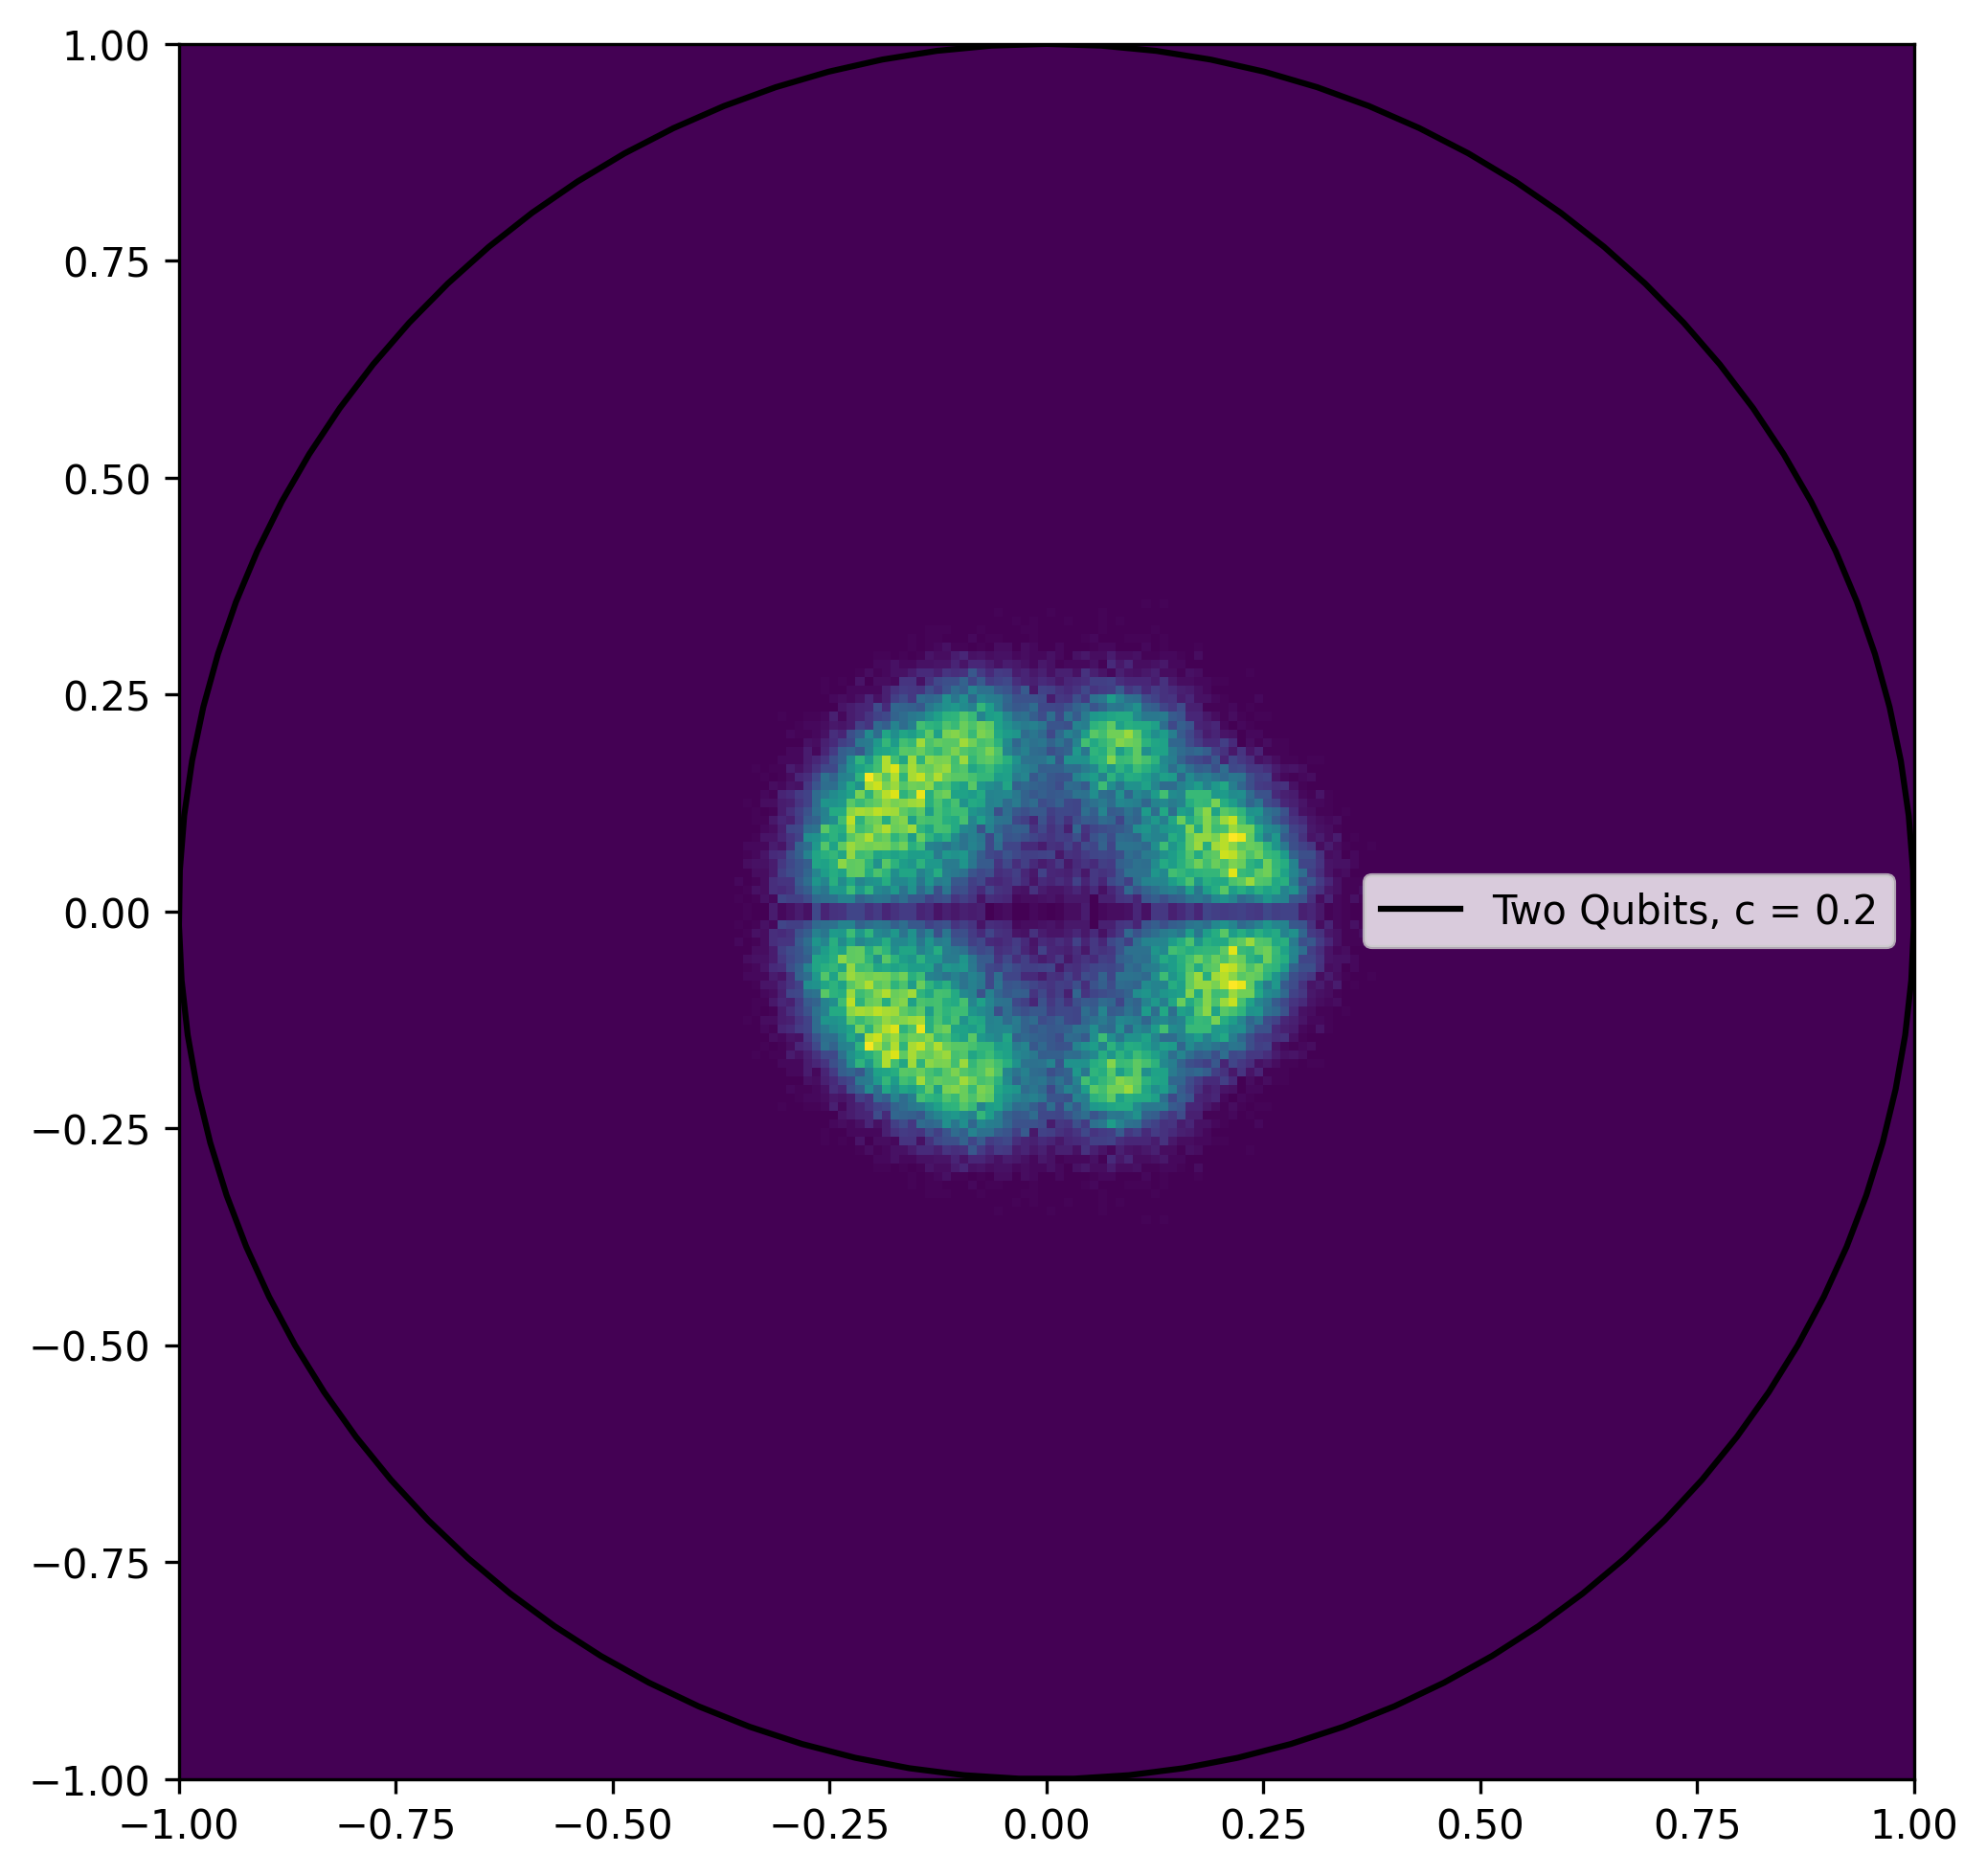

In [22]:
n = 2
circuit = qft(n)

U = Operator(circuit).data
random.seed(42)
np.random.seed(42)
spectrum1 = generate_spectrum_mixed(U = U, 
                                    c = 0.2, 
                                    reps = 10000)

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.hist2d(*spectrum1, 
            range = [[-1, 1], [-1, 1]], 
            bins = [200, 200],
            # norm = clr.LogNorm,
           )

plt.plot(*circle, "k")
plt.legend(["Two Qubits, c = 0.2"])
plt.show()

### Three Qubits

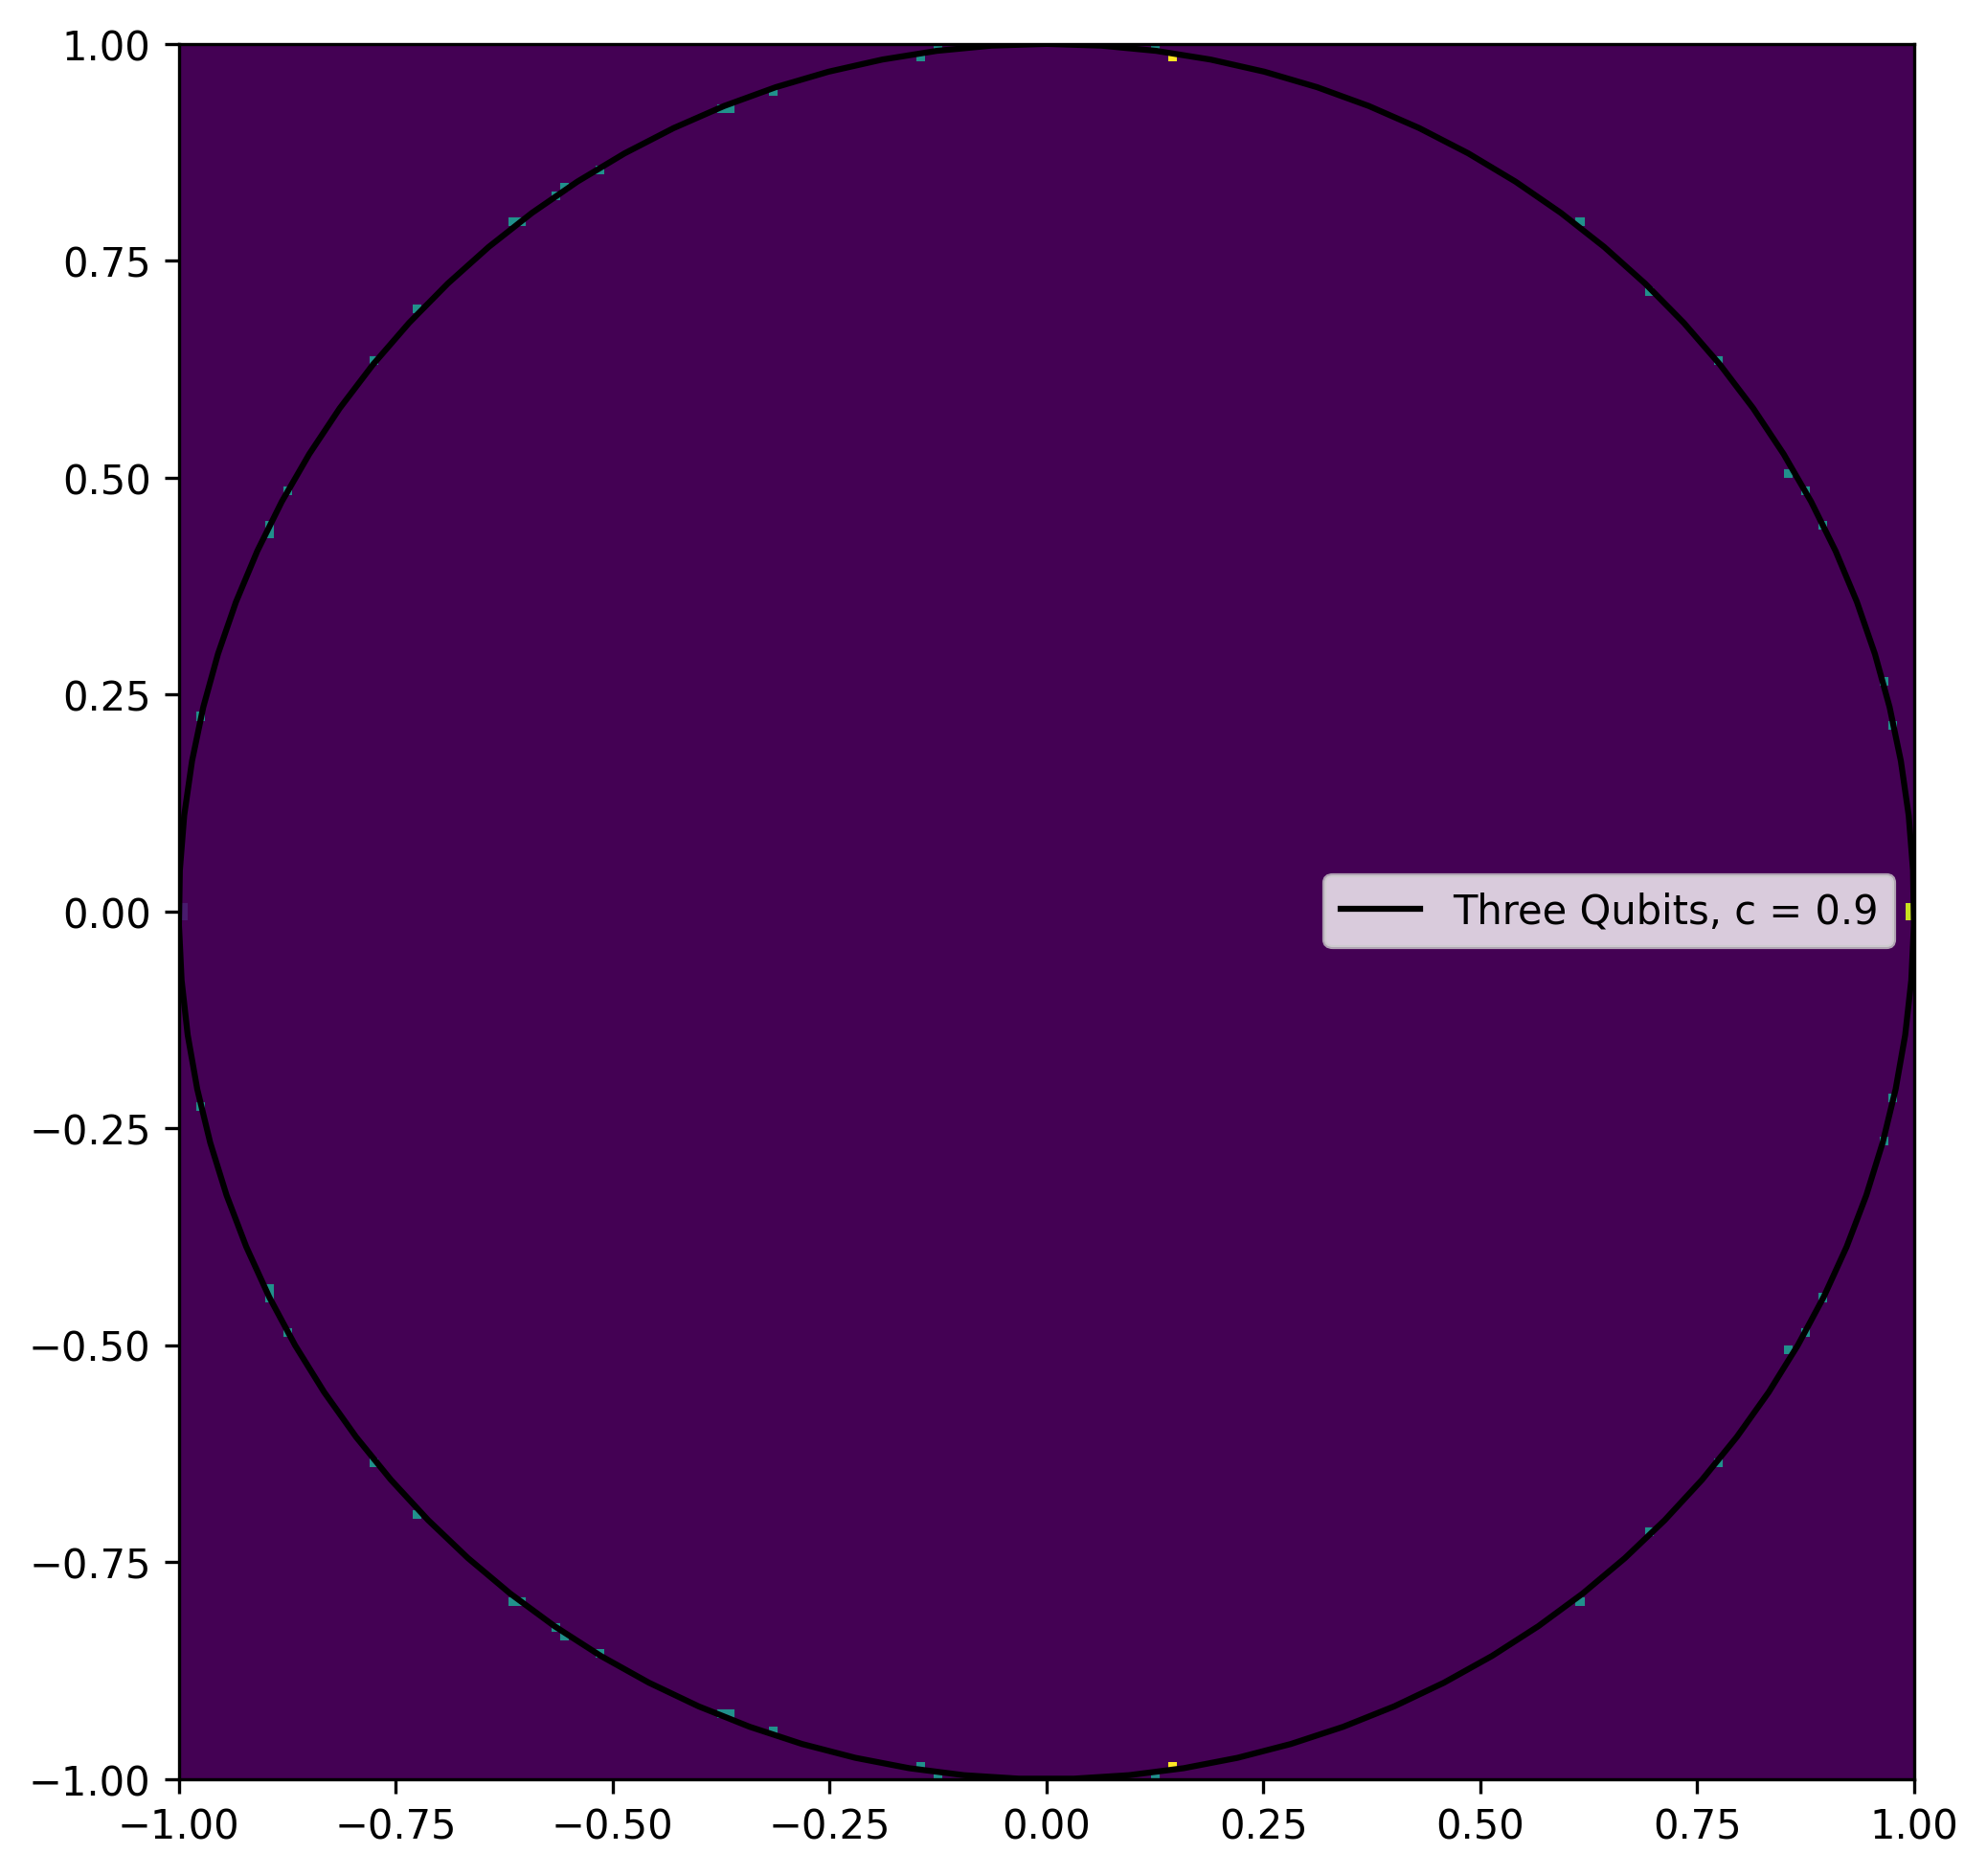

In [38]:
#n = 3
#circuit = qft(n)

#U = Operator(circuit).data
#random.seed(42)
#np.random.seed(42)
#spectrum1 = generate_spectrum_mixed(U = U, 
#                                    c = 0.999, 
#                                    reps = 1000)

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")
plt.hist2d(*spectrum1, 
            range = [[-1, 1], [-1, 1]], 
            bins = [200, 200],
            # norm = clr.LogNorm,
           )


plt.legend(["Three Qubits, c = 0.9"])
plt.show()

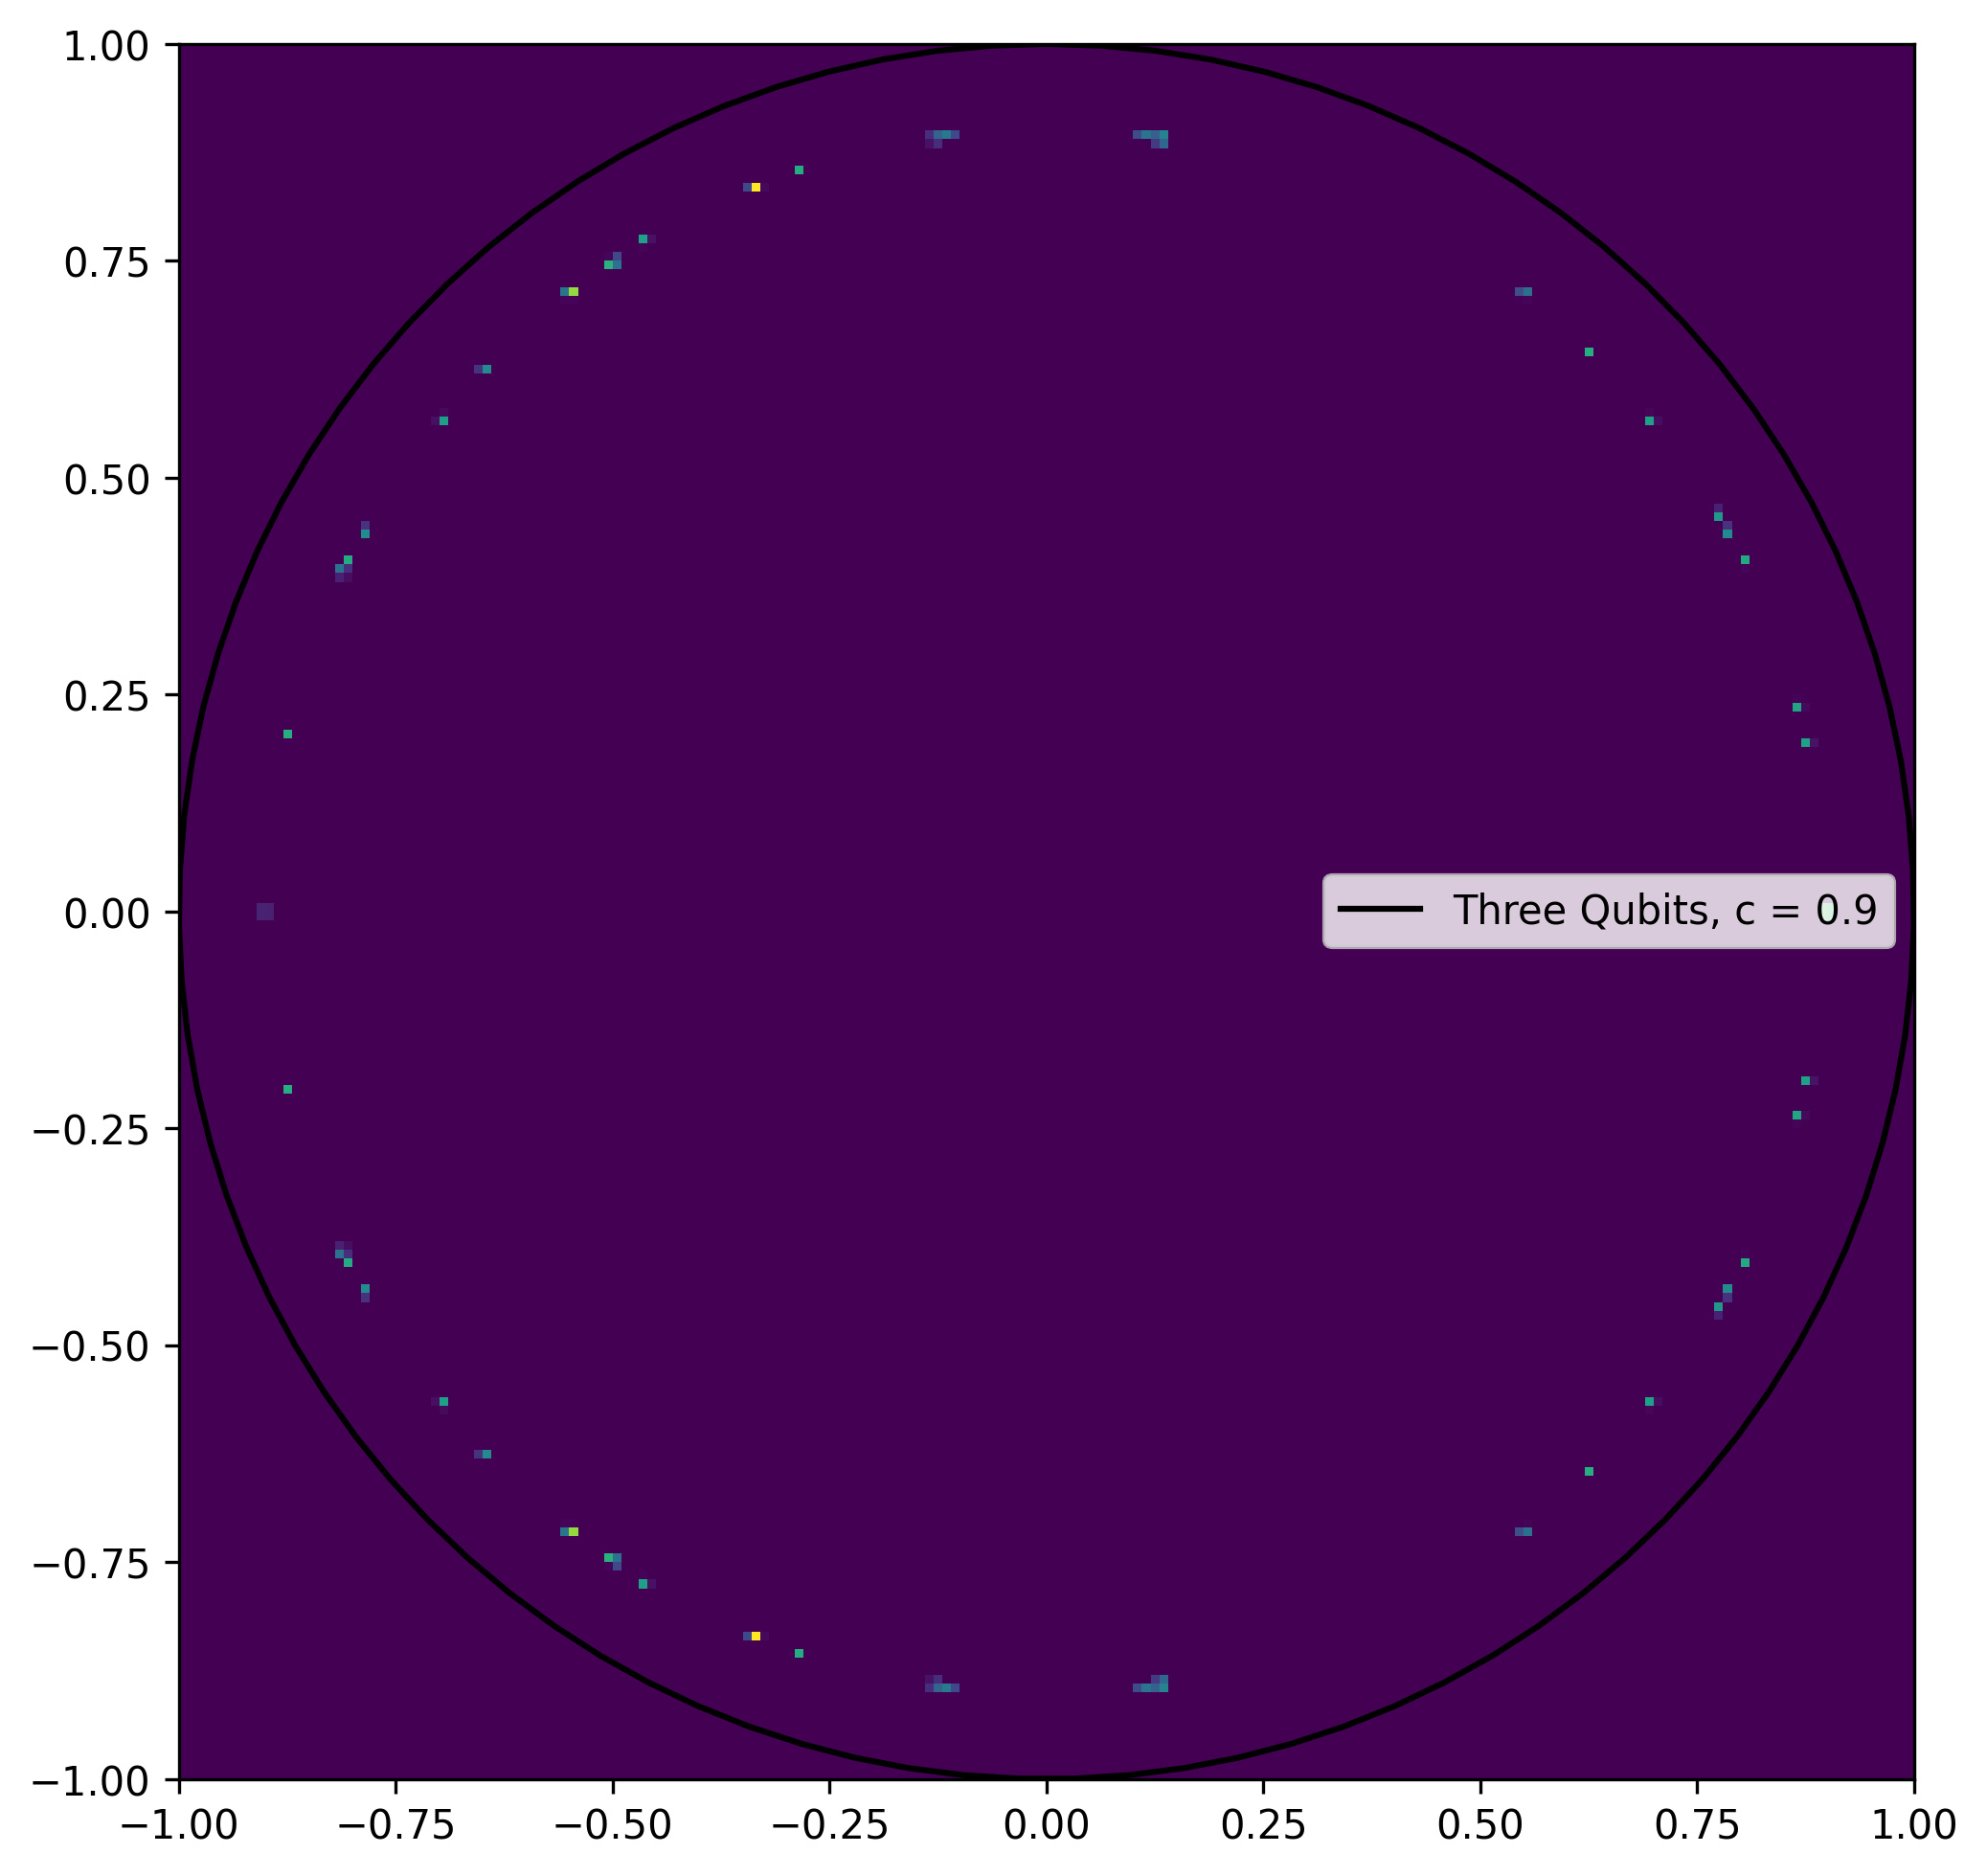

In [23]:
n = 3
circuit = qft(n)

U = Operator(circuit).data
random.seed(42)
np.random.seed(42)
spectrum1 = generate_spectrum_mixed(U = U, 
                                    c = 0.9, 
                                    reps = 1000)

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.hist2d(*spectrum1, 
            range = [[-1, 1], [-1, 1]], 
            bins = [200, 200],
            # norm = clr.LogNorm,
           )

plt.plot(*circle, "k")
plt.legend(["Three Qubits, c = 0.9"])
plt.show()

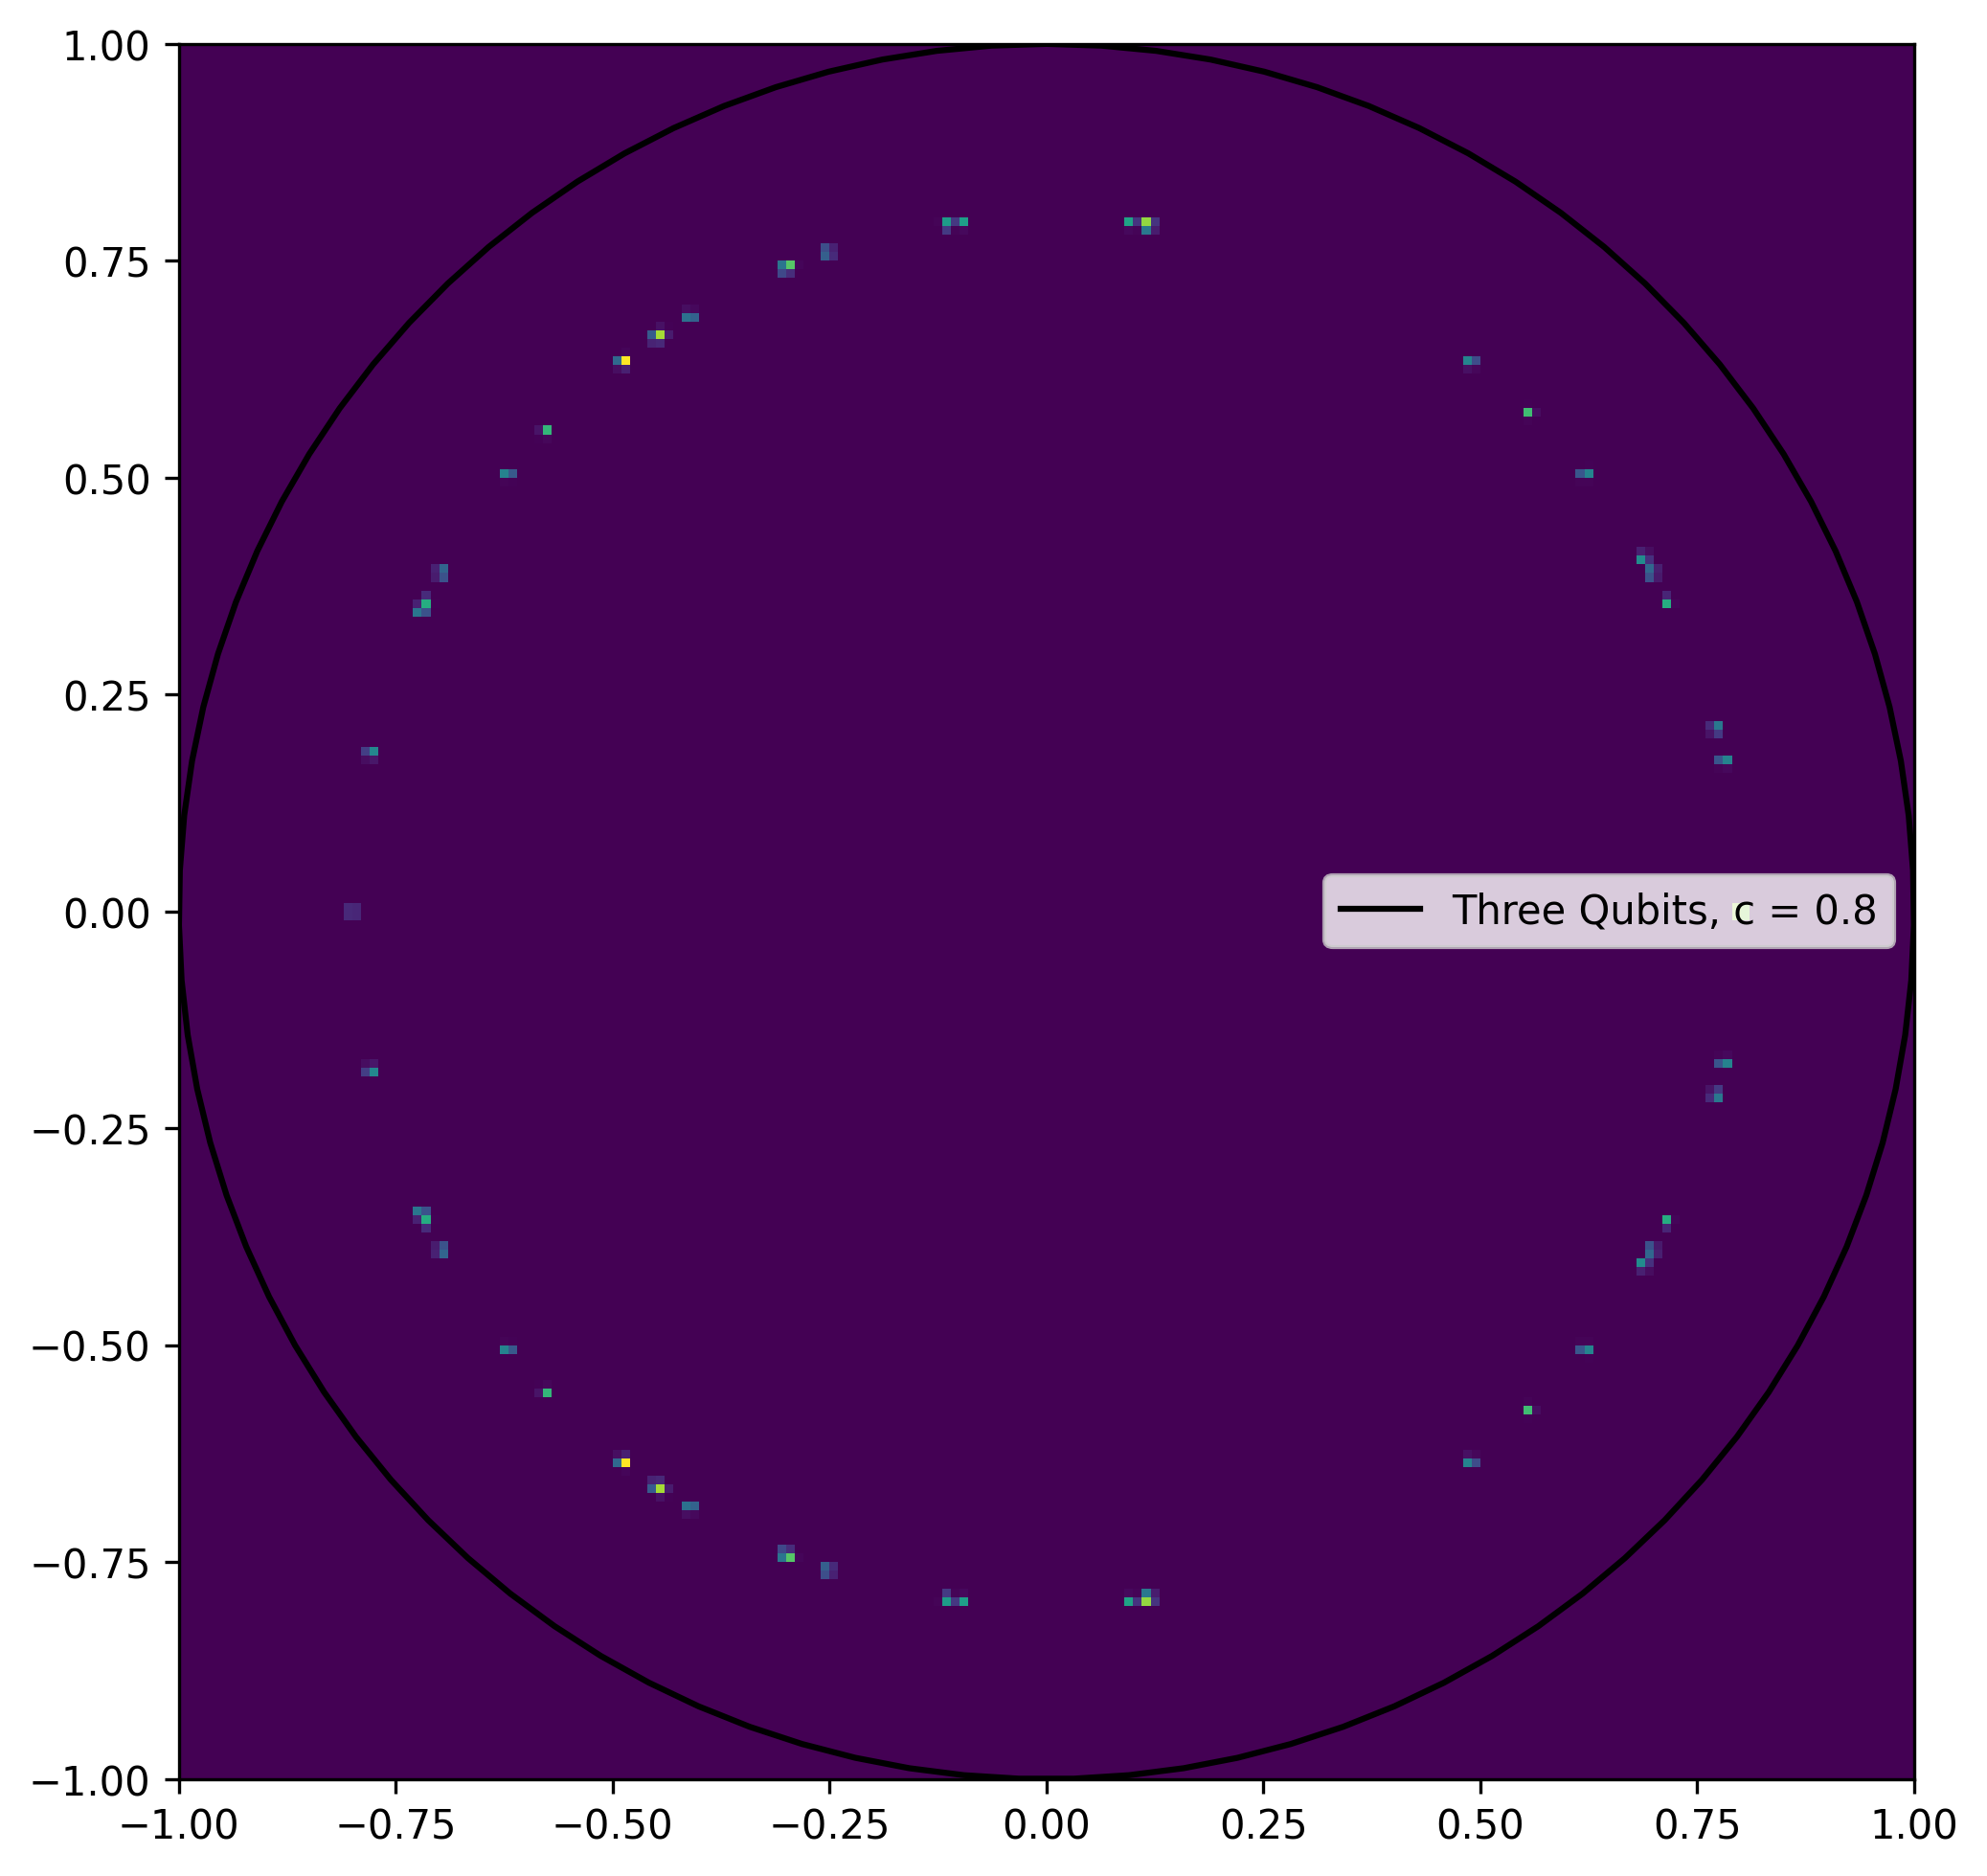

In [24]:
n = 3
circuit = qft(n)

U = Operator(circuit).data
random.seed(42)
np.random.seed(42)
spectrum1 = generate_spectrum_mixed(U = U, 
                                    c = 0.8, 
                                    reps = 1000)

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.hist2d(*spectrum1, 
            range = [[-1, 1], [-1, 1]], 
            bins = [200, 200],
            # norm = clr.LogNorm,
           )

plt.plot(*circle, "k")
plt.legend(["Three Qubits, c = 0.8"])
plt.show()

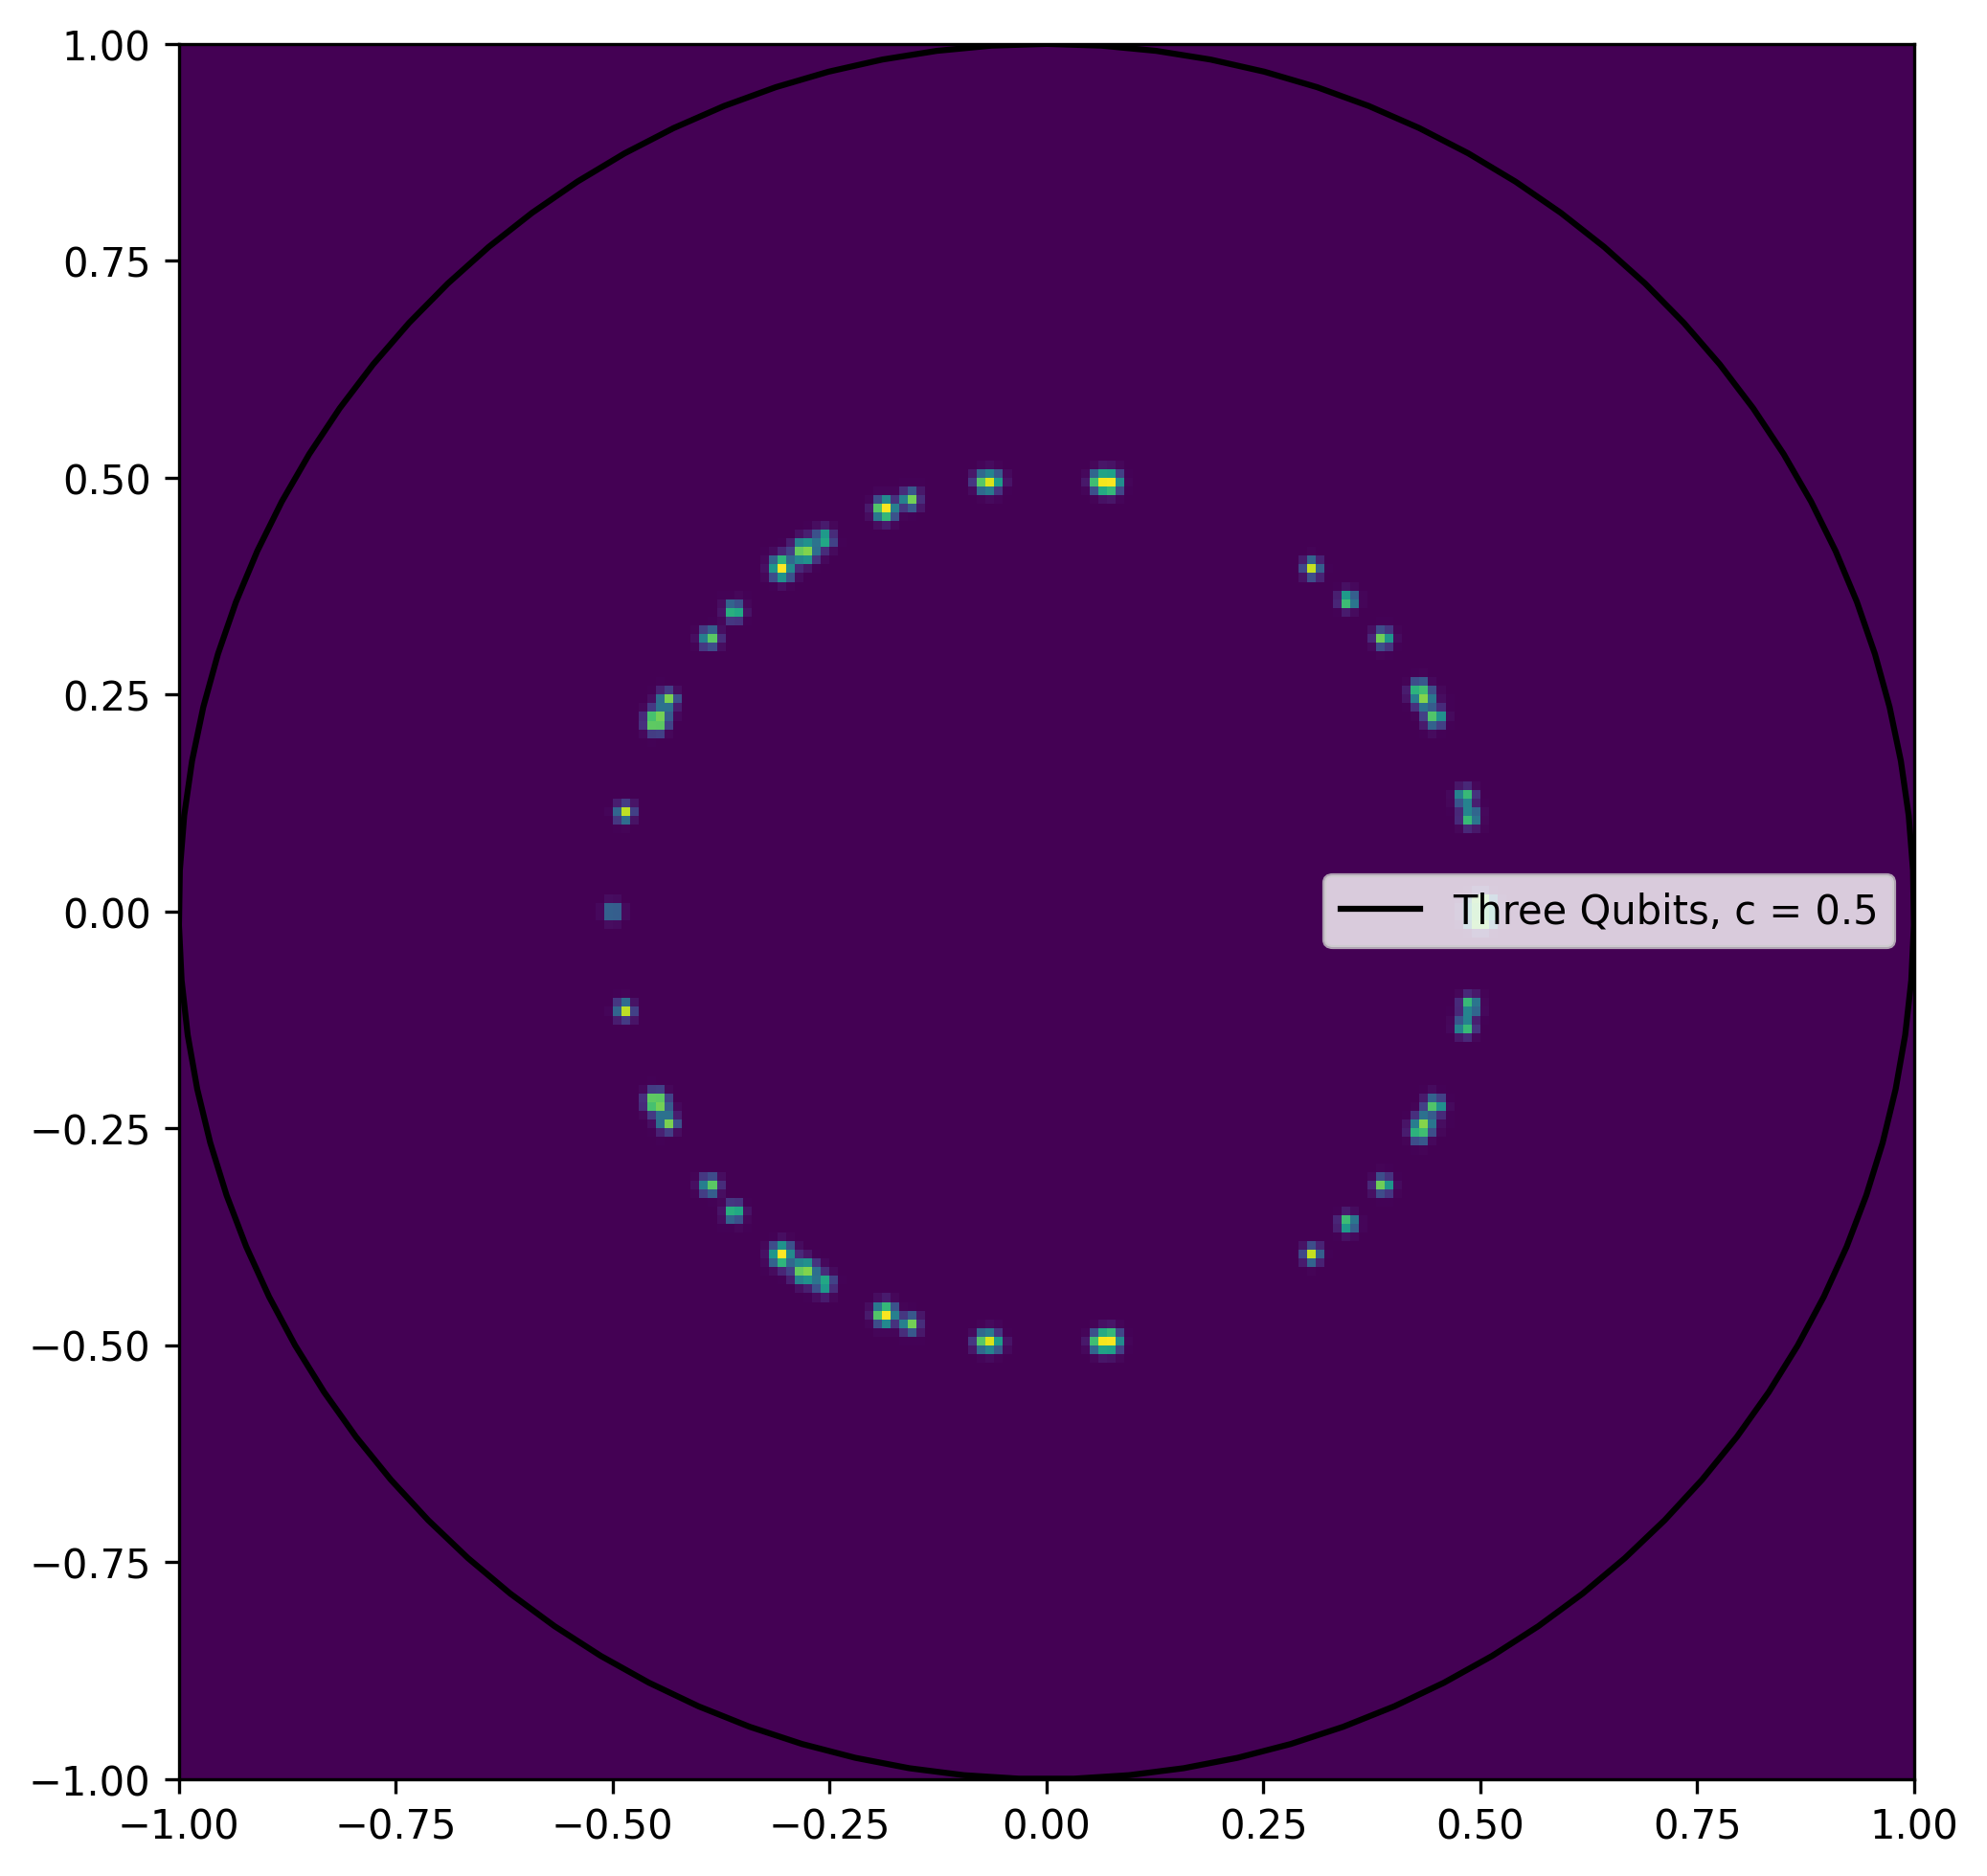

In [25]:
n = 3
circuit = qft(n)

U = Operator(circuit).data
random.seed(42)
np.random.seed(42)
spectrum1 = generate_spectrum_mixed(U = U, 
                                    c = 0.5, 
                                    reps = 1000)

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.hist2d(*spectrum1, 
            range = [[-1, 1], [-1, 1]], 
            bins = [200, 200],
            # norm = clr.LogNorm,
           )

plt.plot(*circle, "k")
plt.legend(["Three Qubits, c = 0.5"])
plt.show()

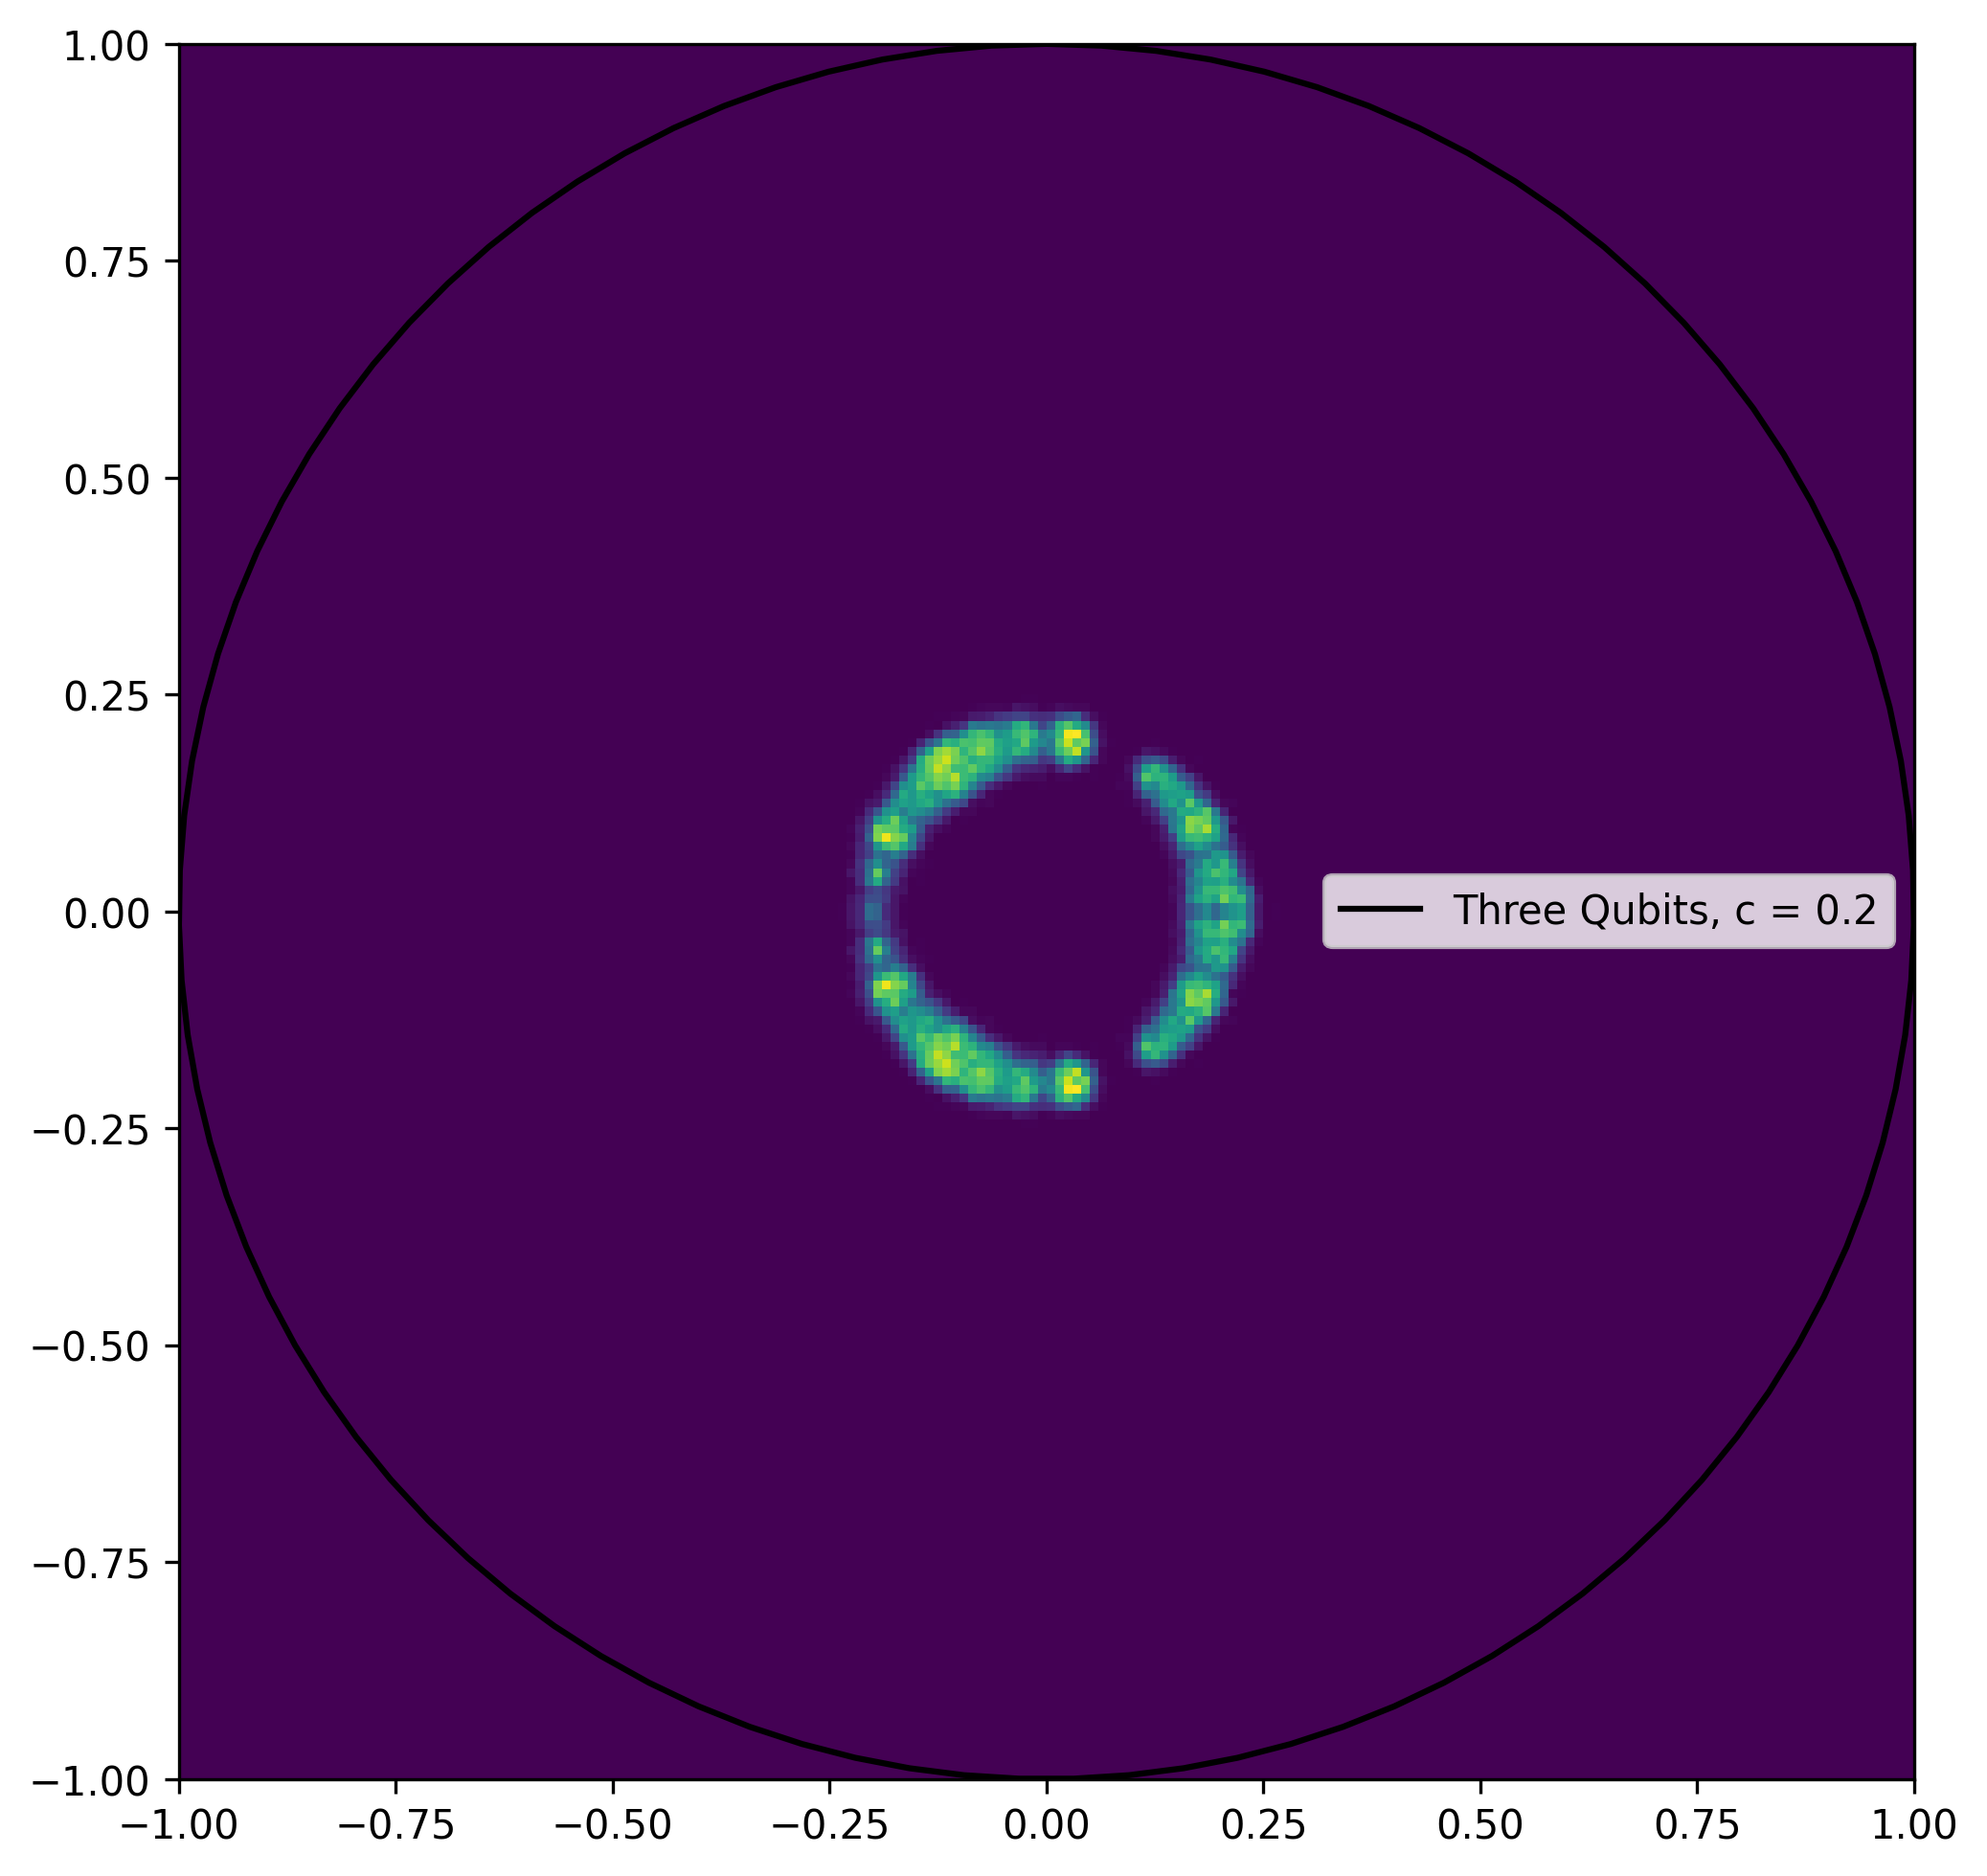

In [26]:
n = 3
circuit = qft(n)

U = Operator(circuit).data
random.seed(42)
np.random.seed(42)
spectrum1 = generate_spectrum_mixed(U = U, 
                                    c = 0.2, 
                                    reps = 1000)

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.hist2d(*spectrum1, 
            range = [[-1, 1], [-1, 1]], 
            bins = [200, 200],
            # norm = clr.LogNorm,
           )

plt.plot(*circle, "k")
plt.legend(["Three Qubits, c = 0.2"])
plt.show()

### Four Qubits

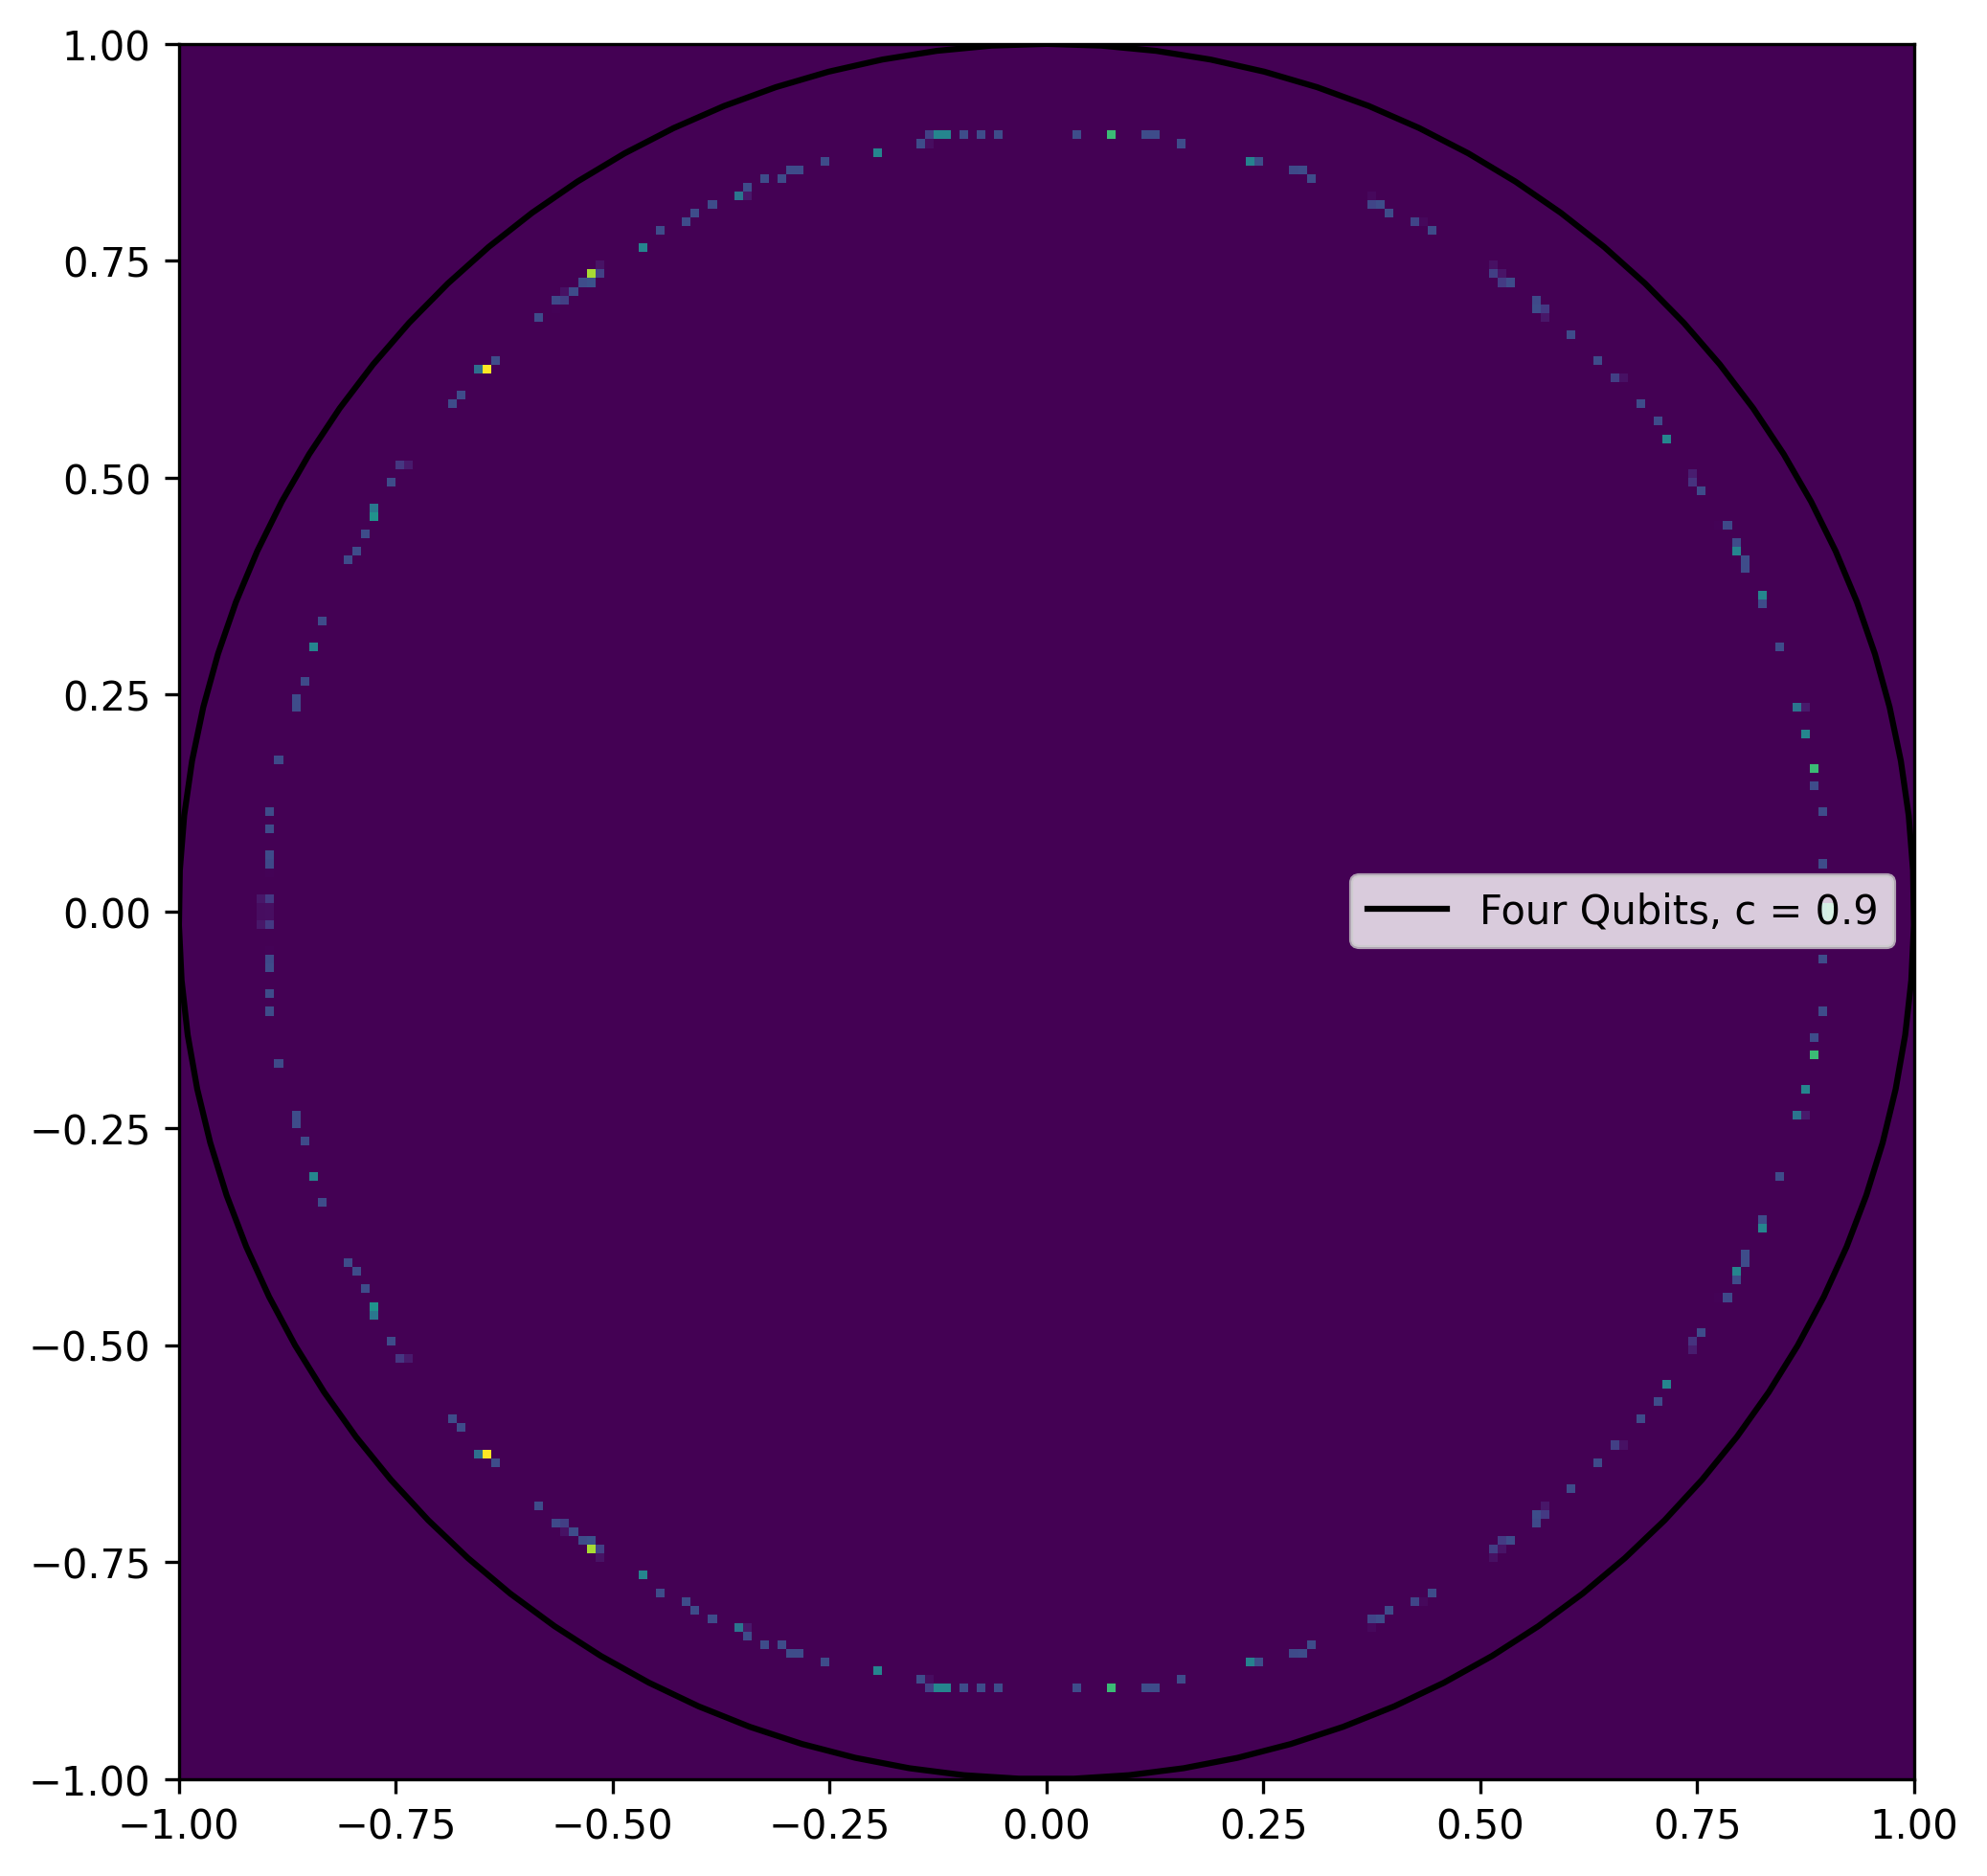

In [27]:
n = 4
circuit = qft(n)

U = Operator(circuit).data
random.seed(42)
np.random.seed(42)
spectrum1 = generate_spectrum_mixed(U = U, 
                                    c = 0.9, 
                                    reps = 100)

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.hist2d(*spectrum1, 
            range = [[-1, 1], [-1, 1]], 
            bins = [200, 200],
            # norm = clr.LogNorm,
           )

plt.plot(*circle, "k")
plt.legend(["Four Qubits, c = 0.9"])
plt.show()

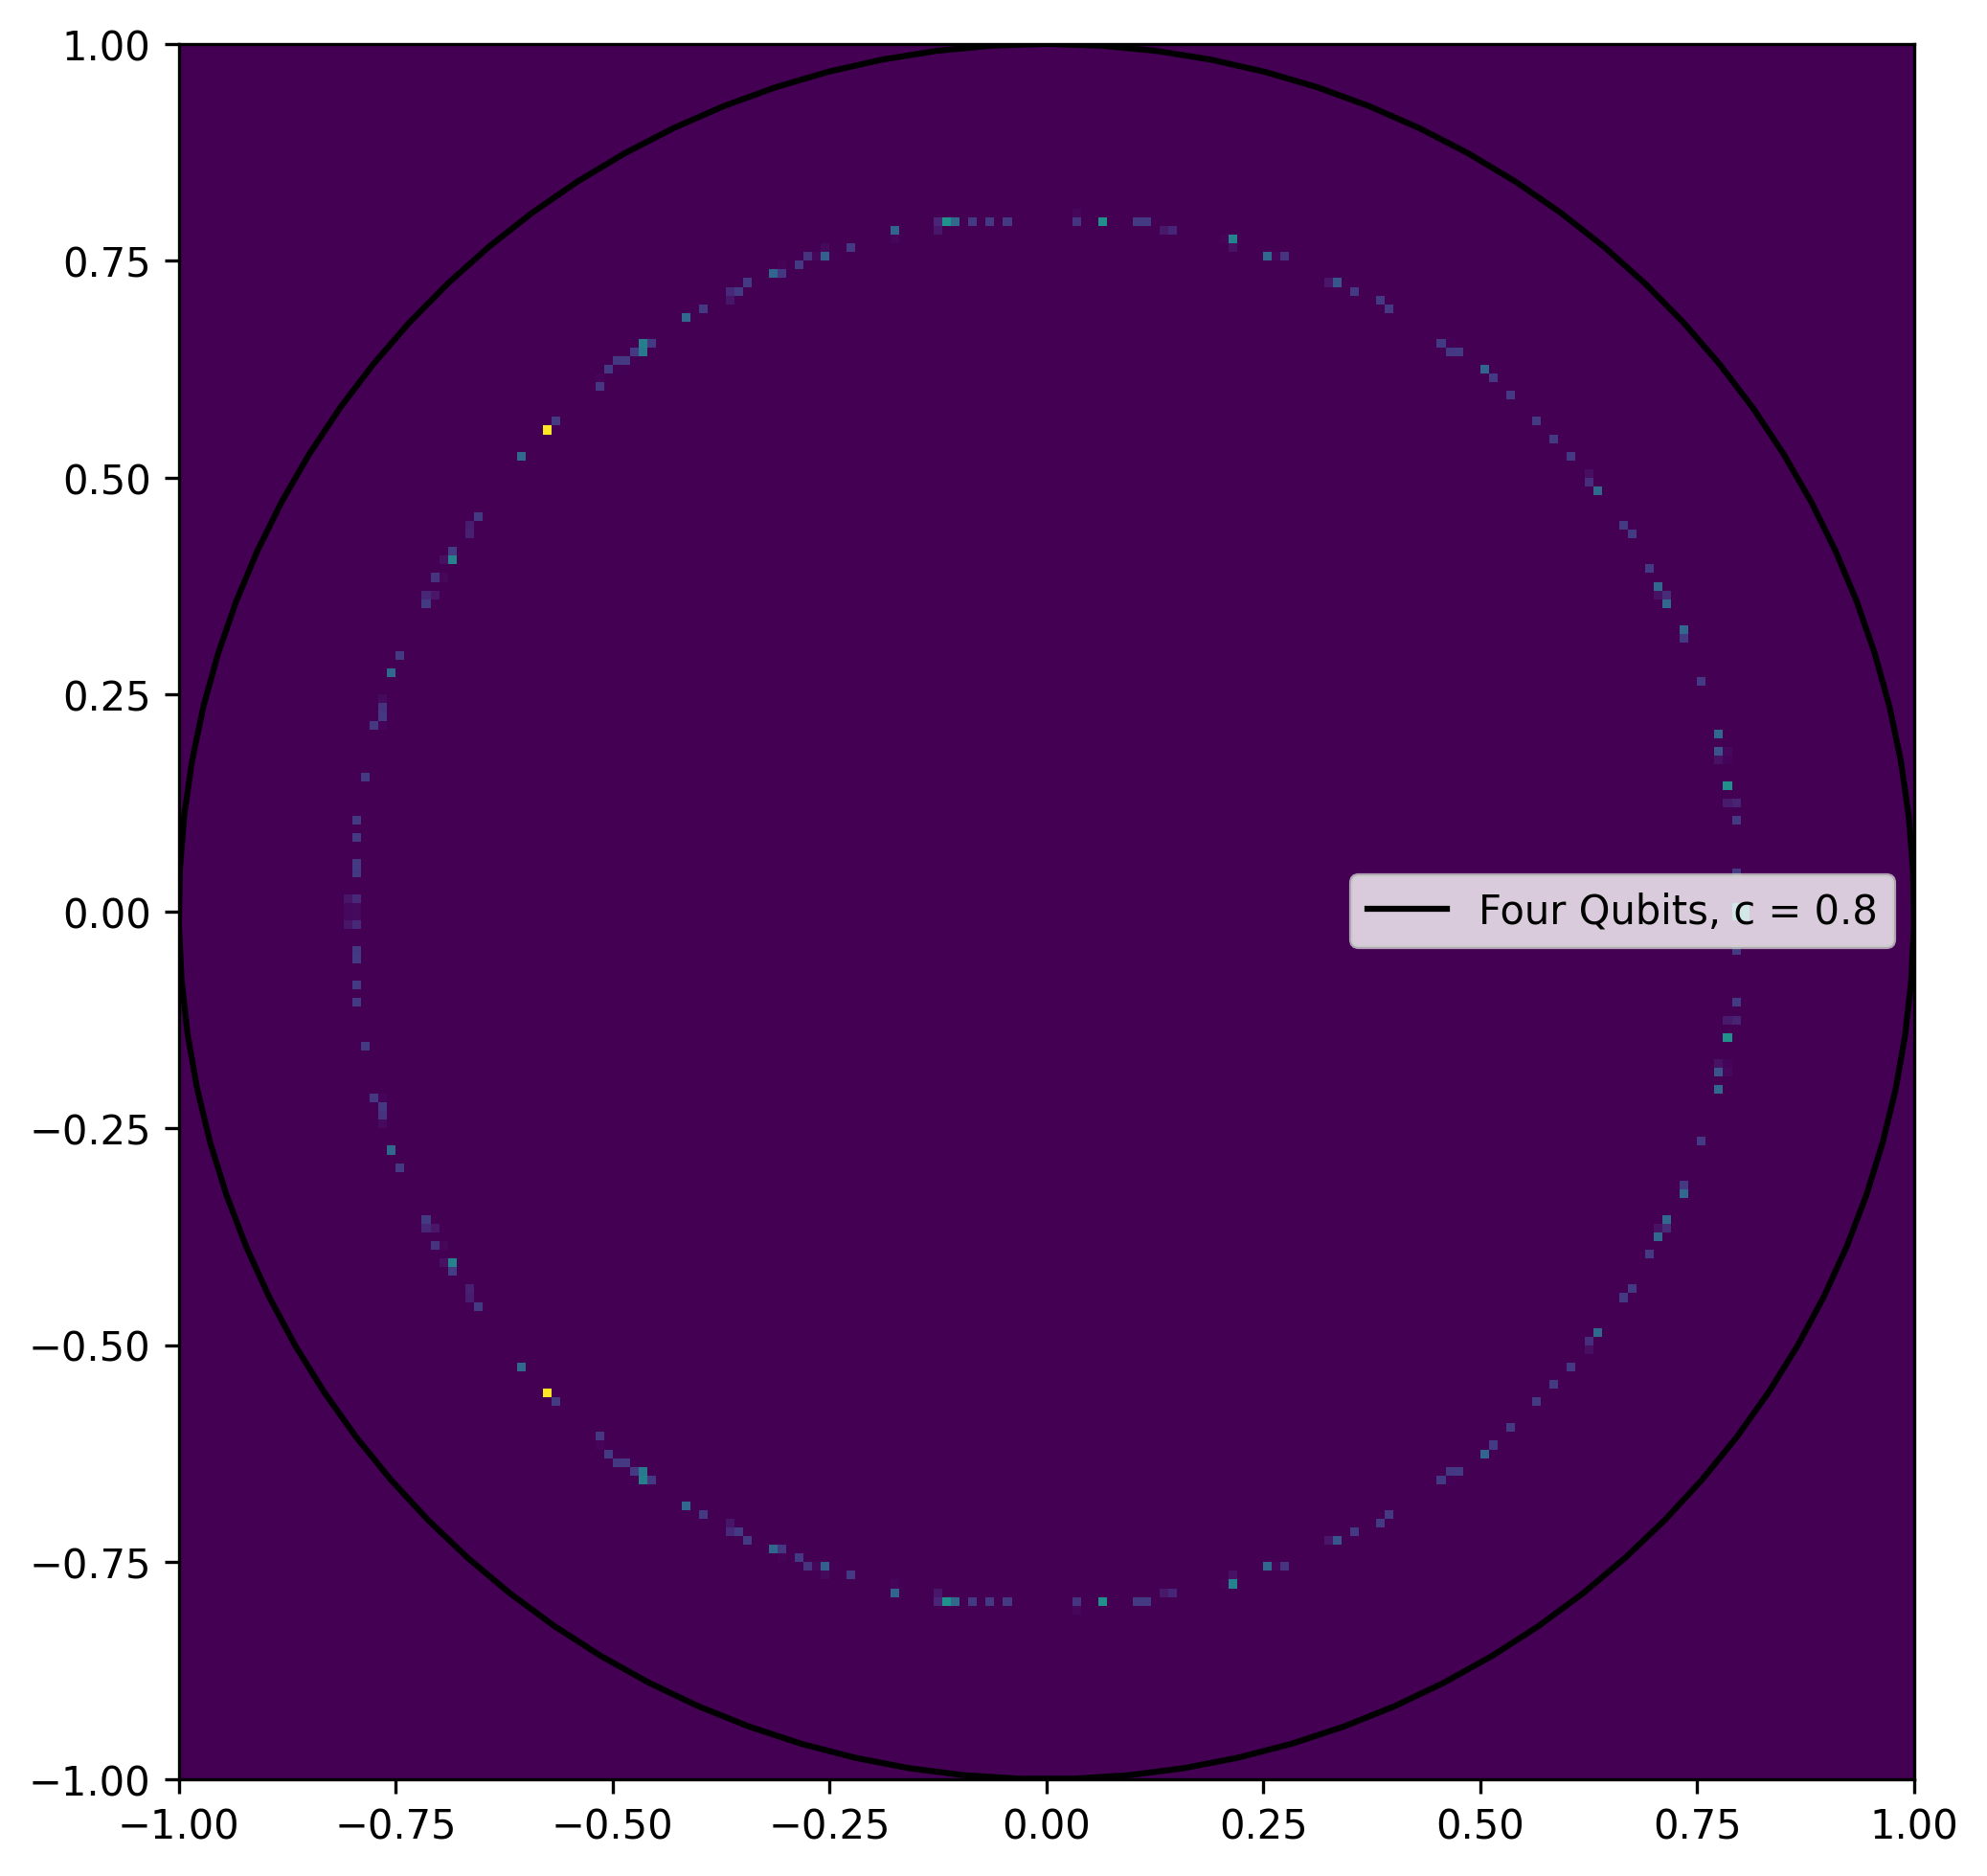

In [28]:
n = 4
circuit = qft(n)

U = Operator(circuit).data
random.seed(42)
np.random.seed(42)
spectrum1 = generate_spectrum_mixed(U = U, 
                                    c = 0.8, 
                                    reps = 100)

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.hist2d(*spectrum1, 
            range = [[-1, 1], [-1, 1]], 
            bins = [200, 200],
            # norm = clr.LogNorm,
           )

plt.plot(*circle, "k")
plt.legend(["Four Qubits, c = 0.8"])
plt.show()

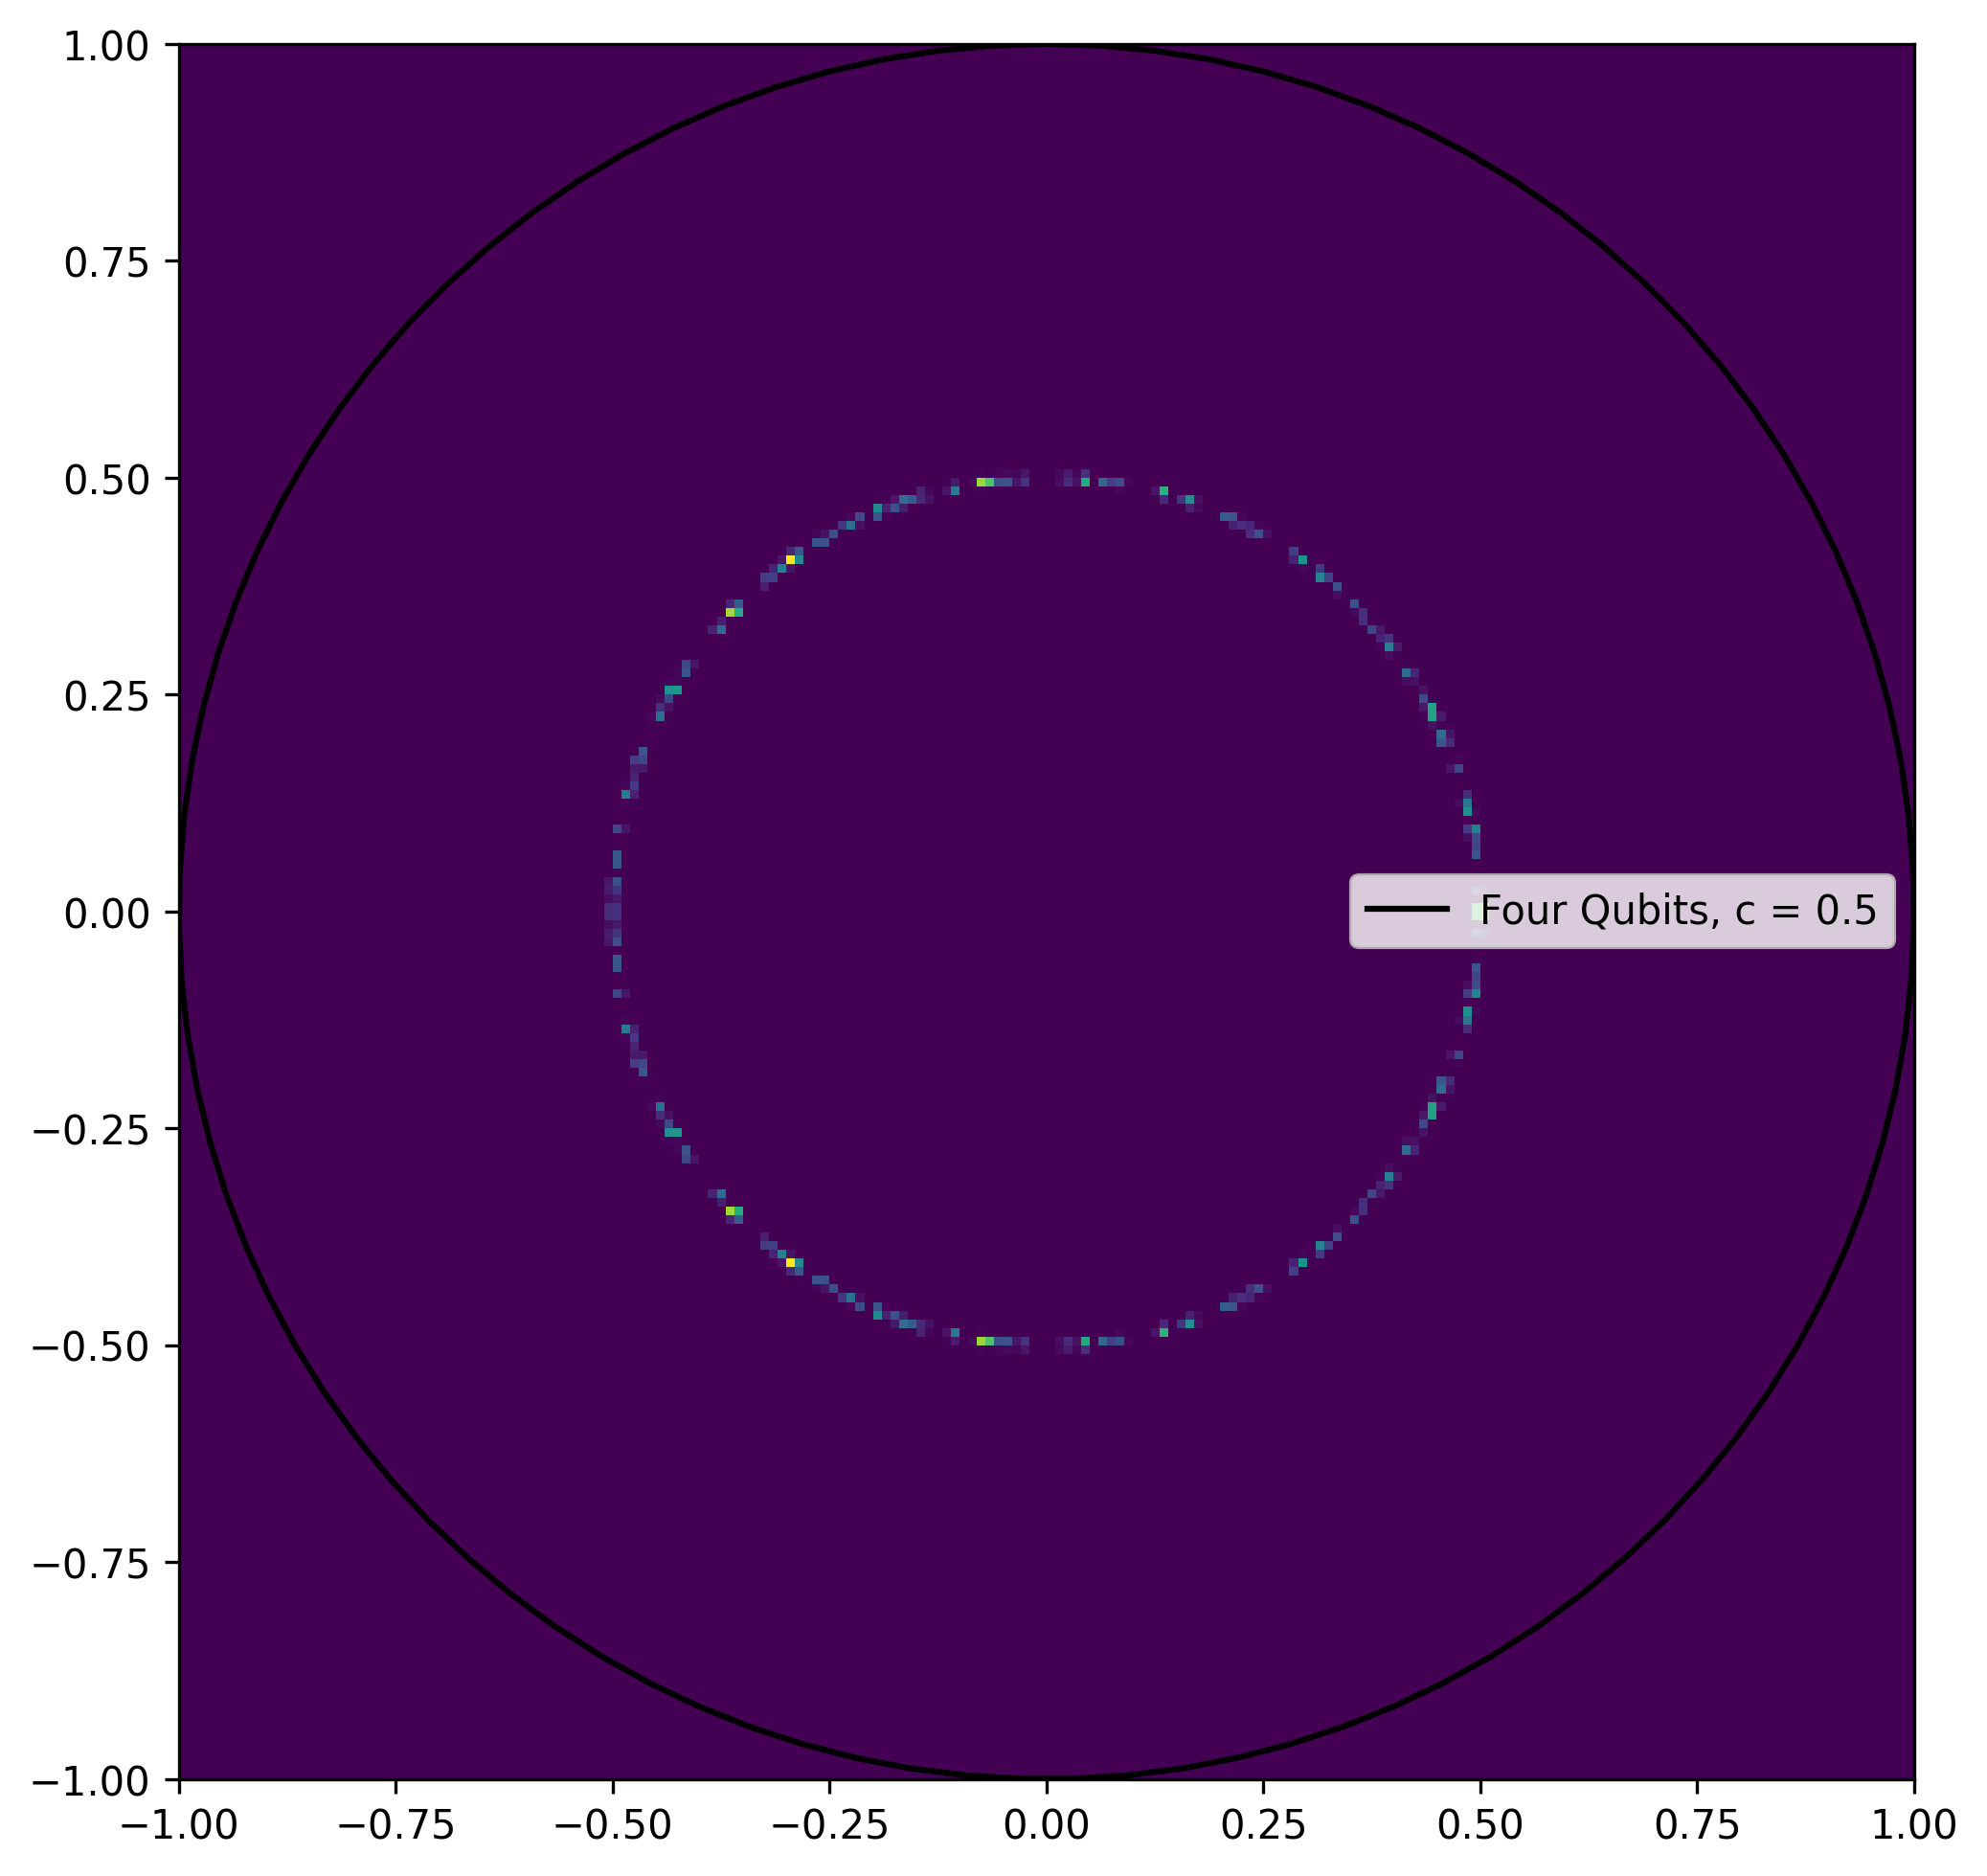

In [29]:
n = 4
circuit = qft(n)

U = Operator(circuit).data
random.seed(42)
np.random.seed(42)
spectrum1 = generate_spectrum_mixed(U = U, 
                                    c = 0.5, 
                                    reps = 100)

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.hist2d(*spectrum1, 
            range = [[-1, 1], [-1, 1]], 
            bins = [200, 200],
            # norm = clr.LogNorm,
           )

plt.plot(*circle, "k")
plt.legend(["Four Qubits, c = 0.5"])
plt.show()

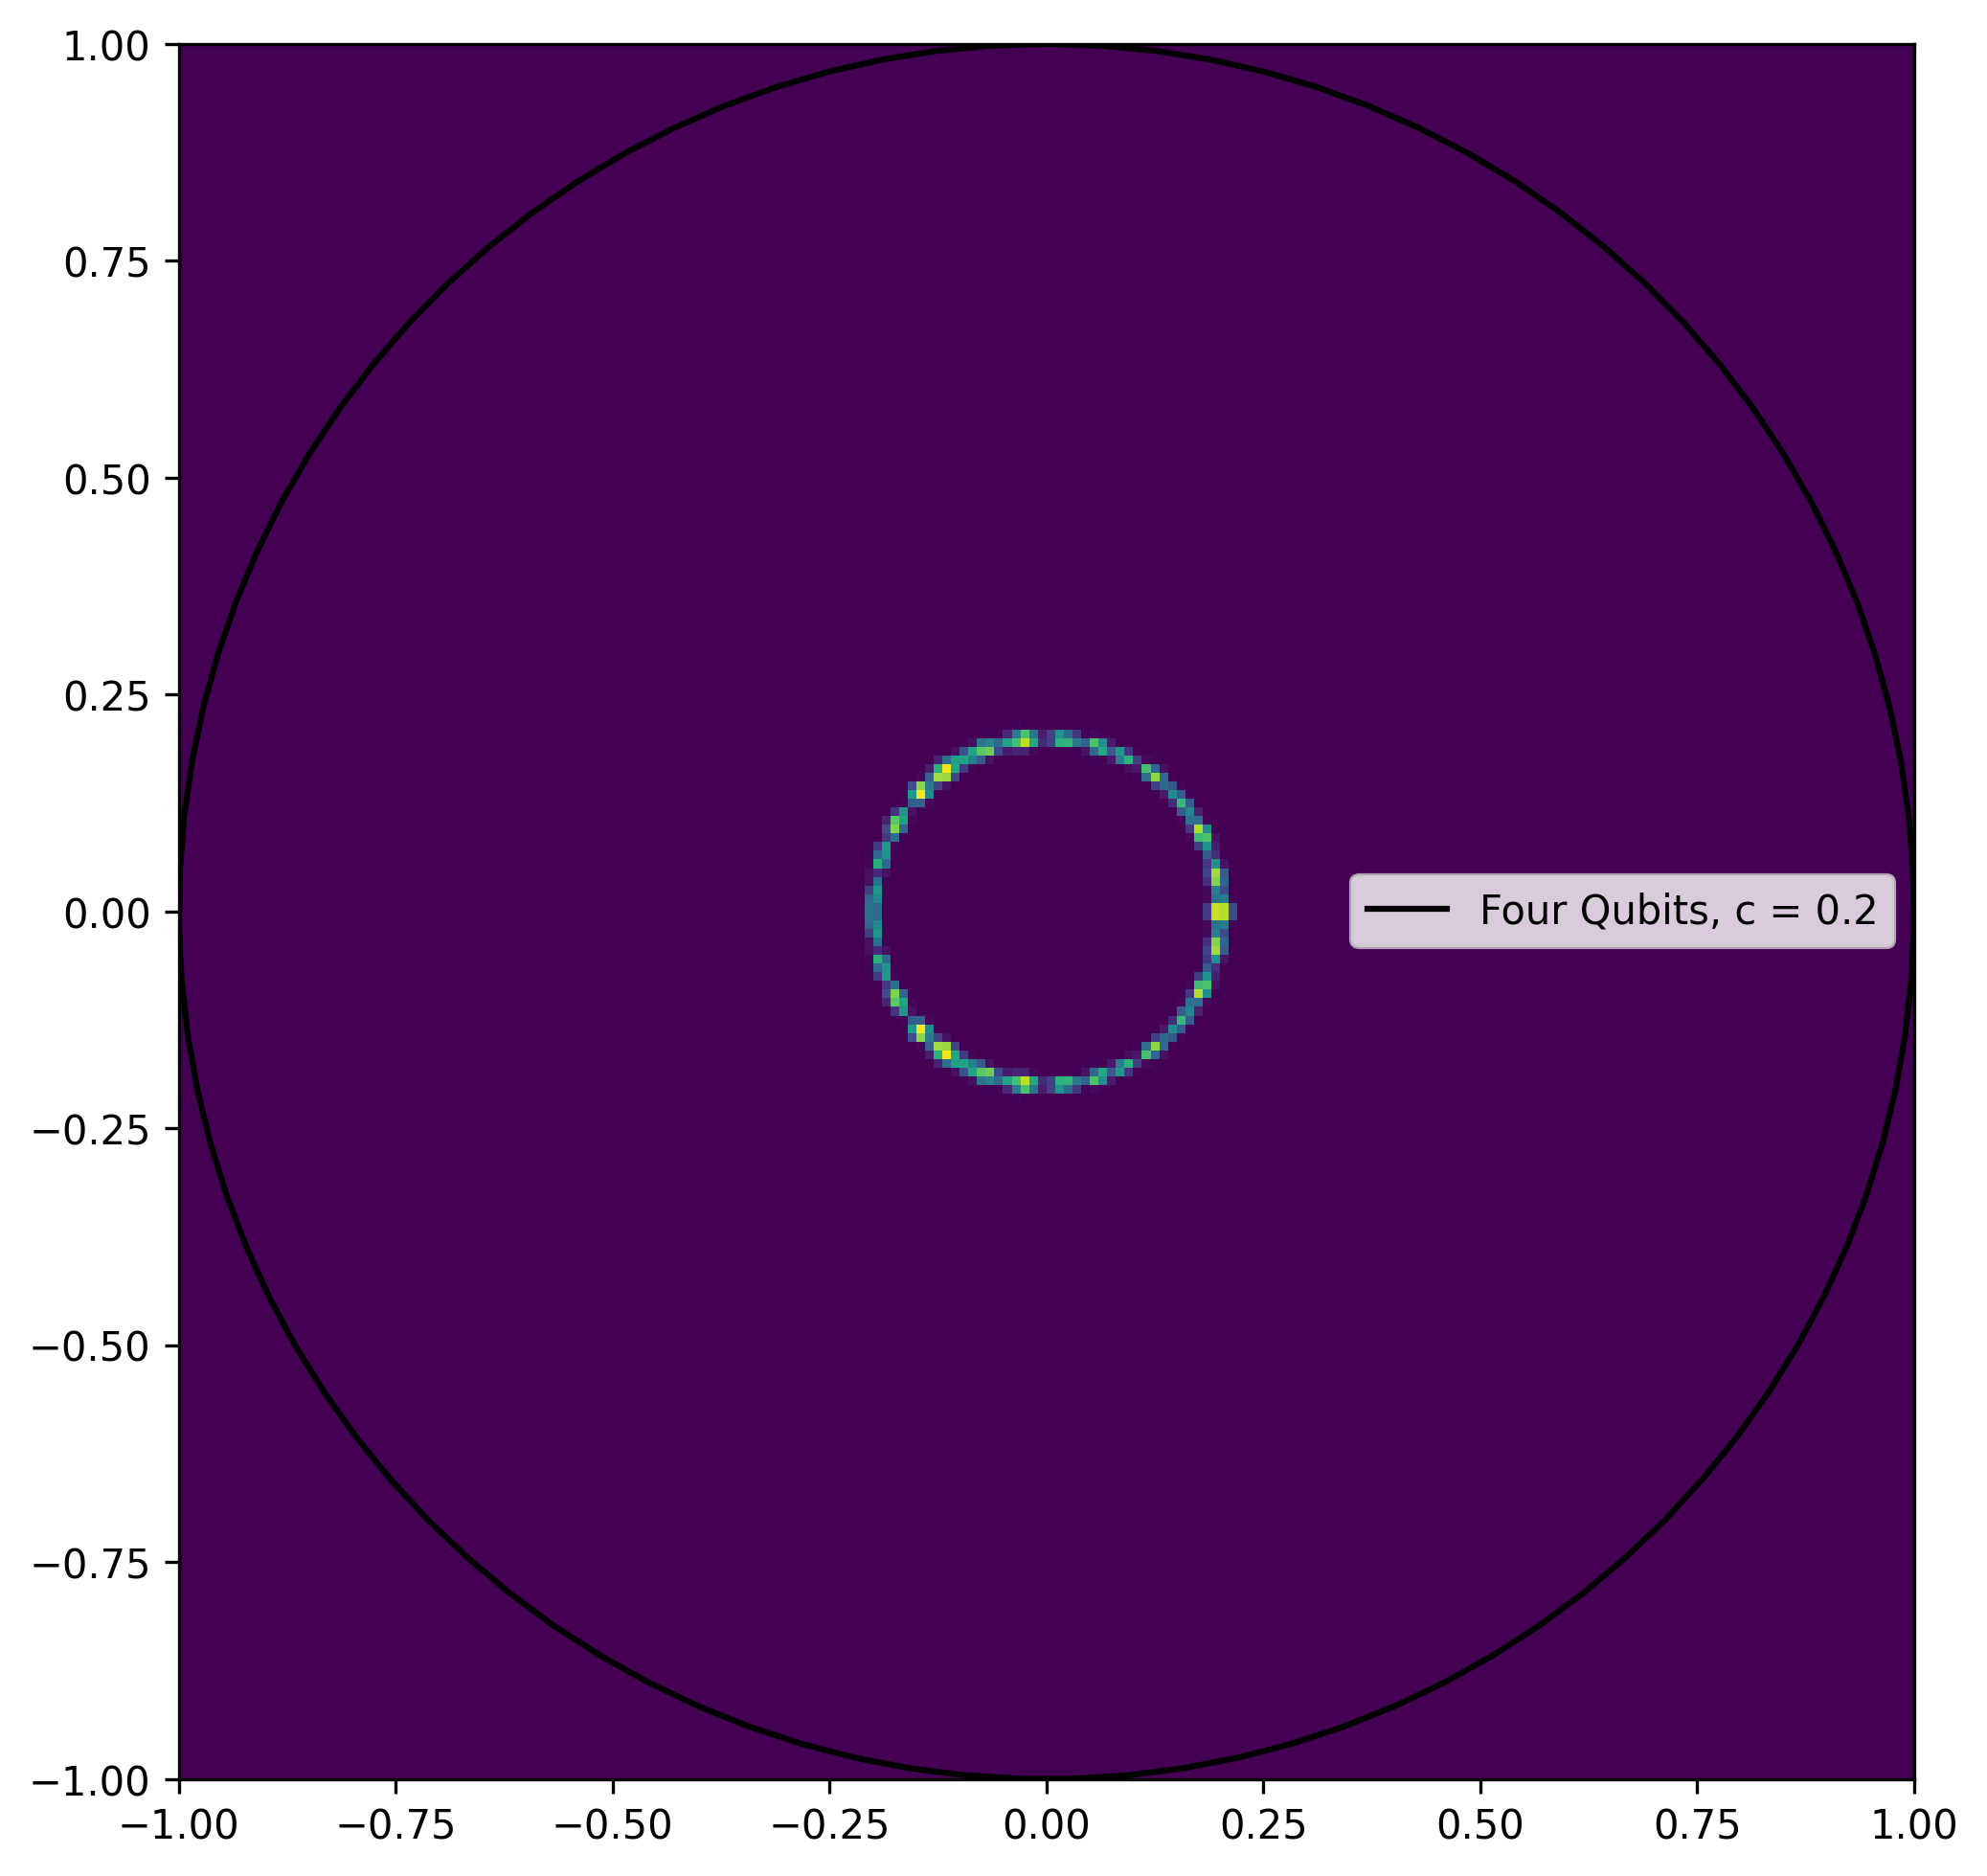

In [30]:
n = 4
circuit = qft(n)

U = Operator(circuit).data
random.seed(42)
np.random.seed(42)
spectrum1 = generate_spectrum_mixed(U = U, 
                                    c = 0.2, 
                                    reps = 100)

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.hist2d(*spectrum1, 
            range = [[-1, 1], [-1, 1]], 
            bins = [200, 200],
            # norm = clr.LogNorm,
           )

plt.plot(*circle, "k")
plt.legend(["Four Qubits, c = 0.2"])
plt.show()

### Five Qubits

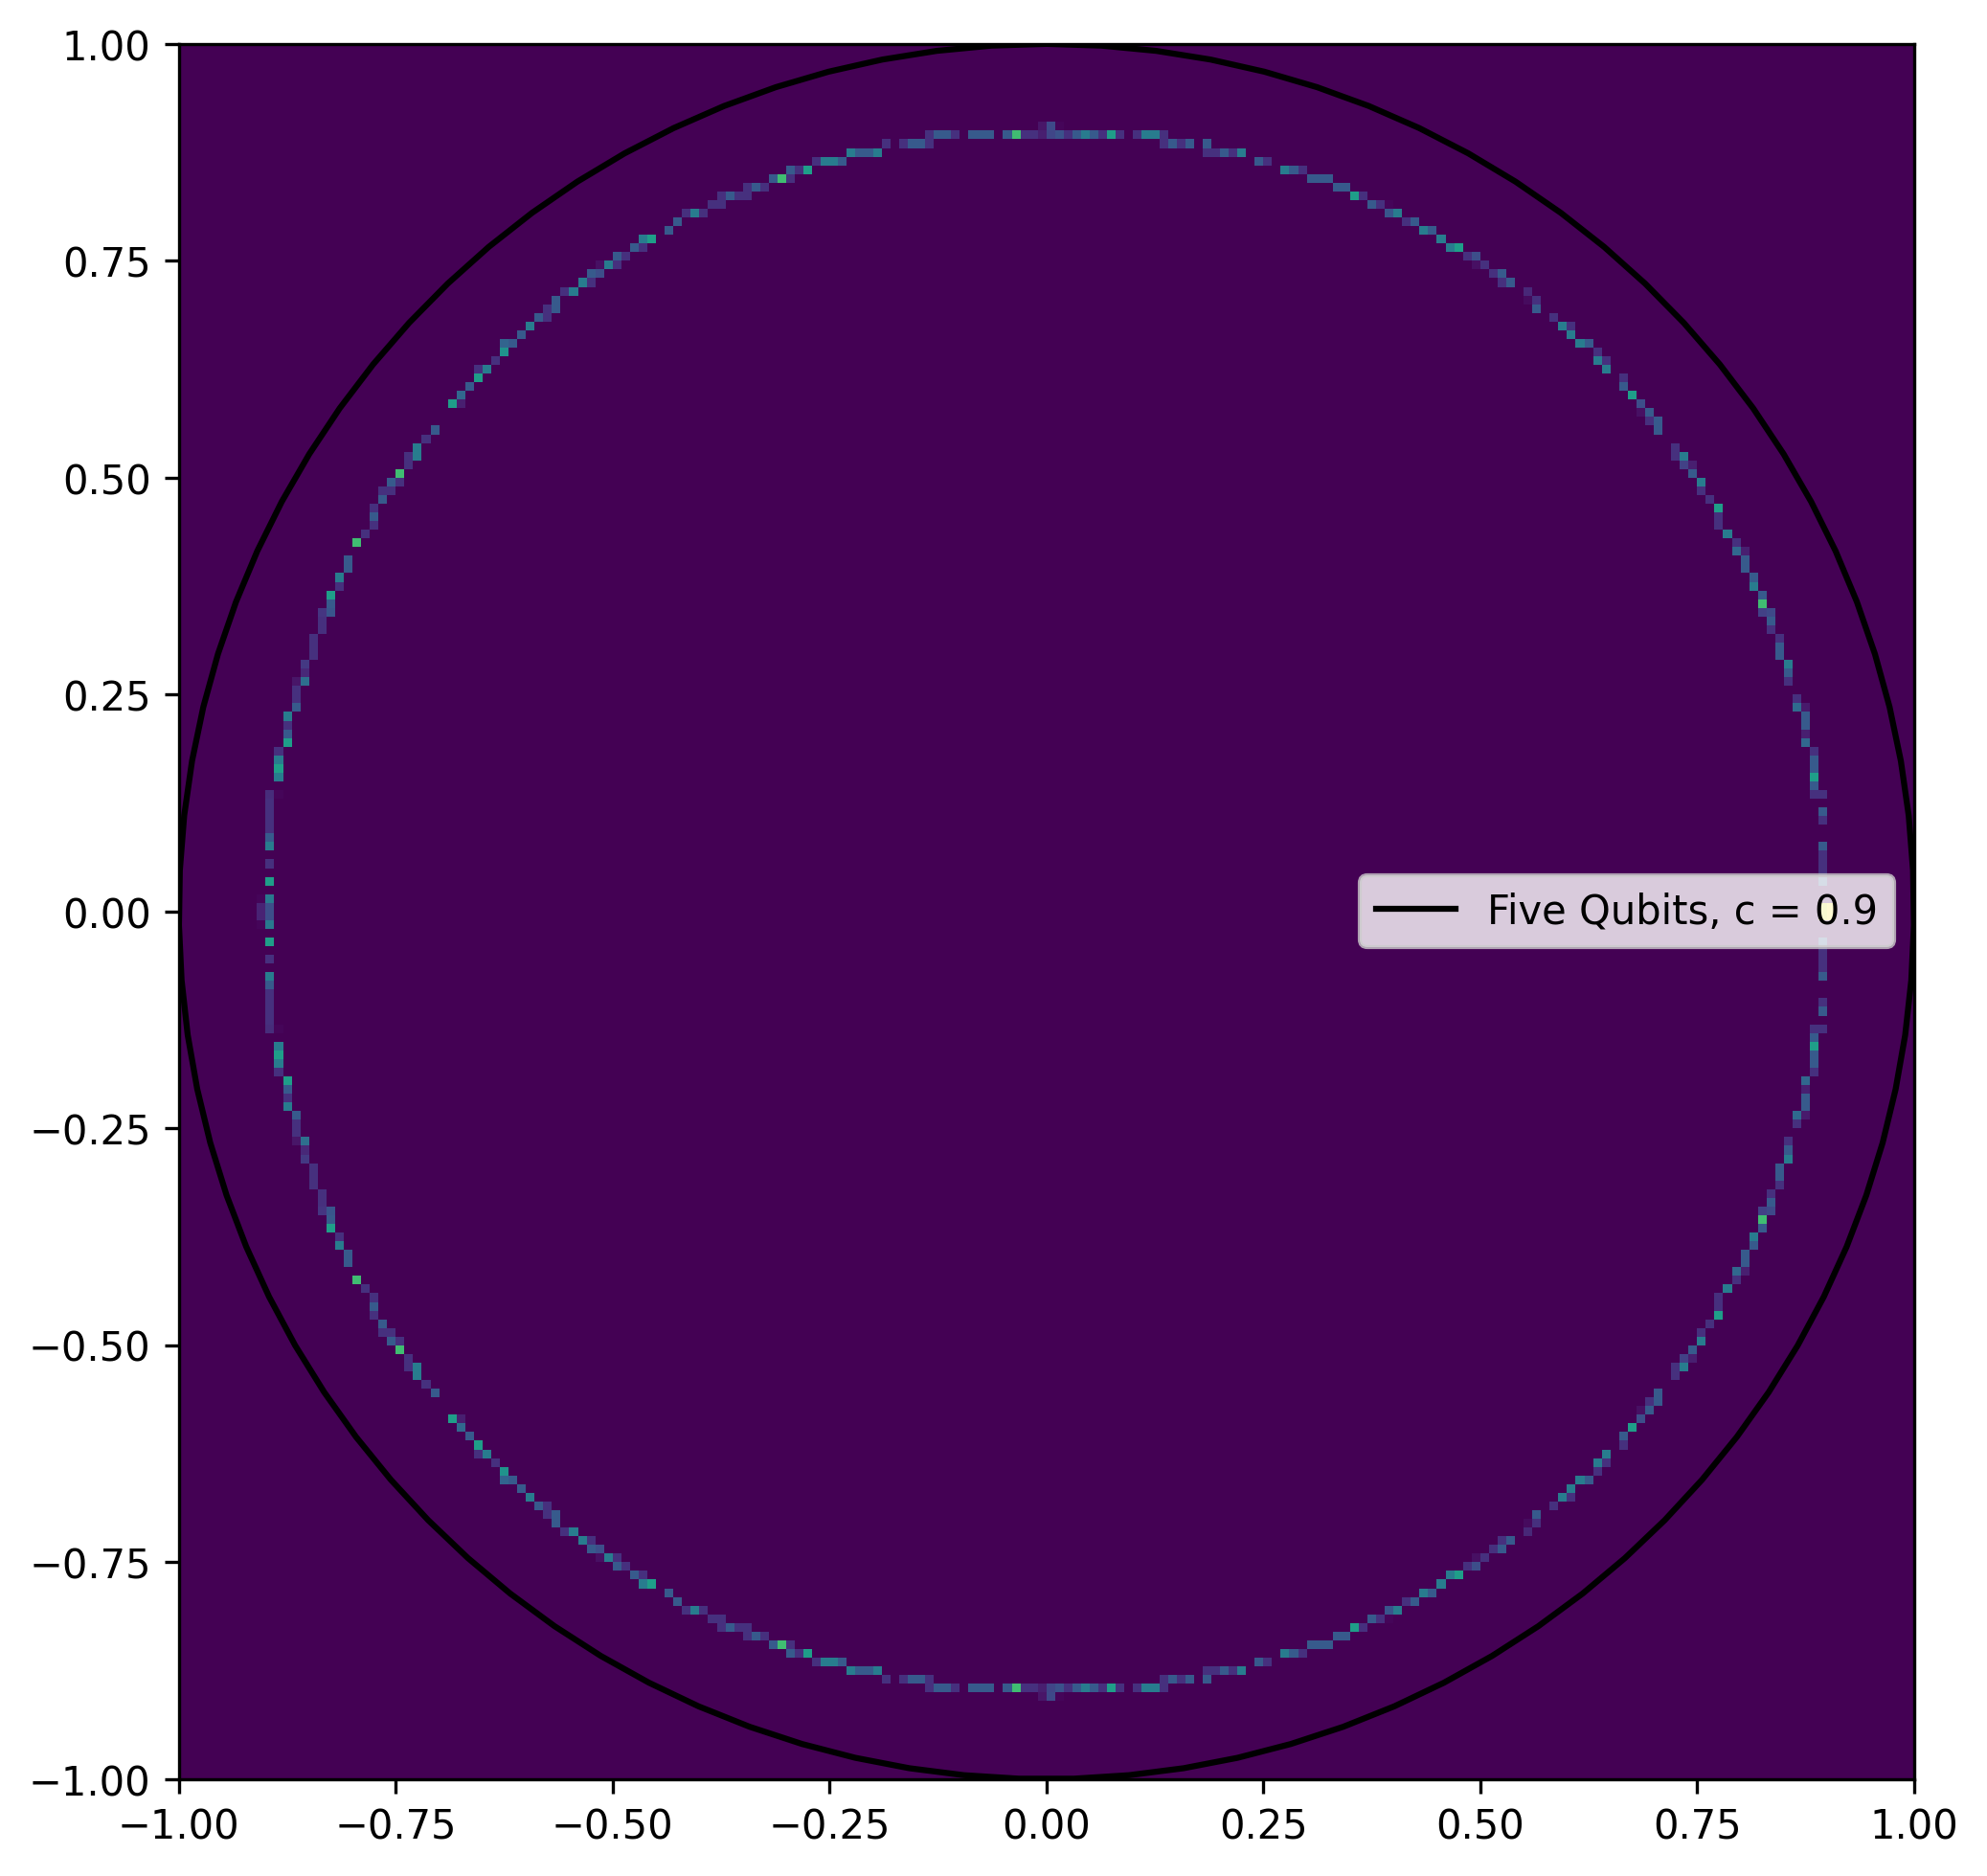

In [31]:
n = 5
circuit = qft(n)

U = Operator(circuit).data
random.seed(42)
np.random.seed(42)
spectrum1 = generate_spectrum_mixed(U = U, 
                                    c = 0.9, 
                                    reps = 10)

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.hist2d(*spectrum1, 
            range = [[-1, 1], [-1, 1]], 
            bins = [200, 200],
            # norm = clr.LogNorm,
           )

plt.plot(*circle, "k")
plt.legend(["Five Qubits, c = 0.9"])
plt.show()

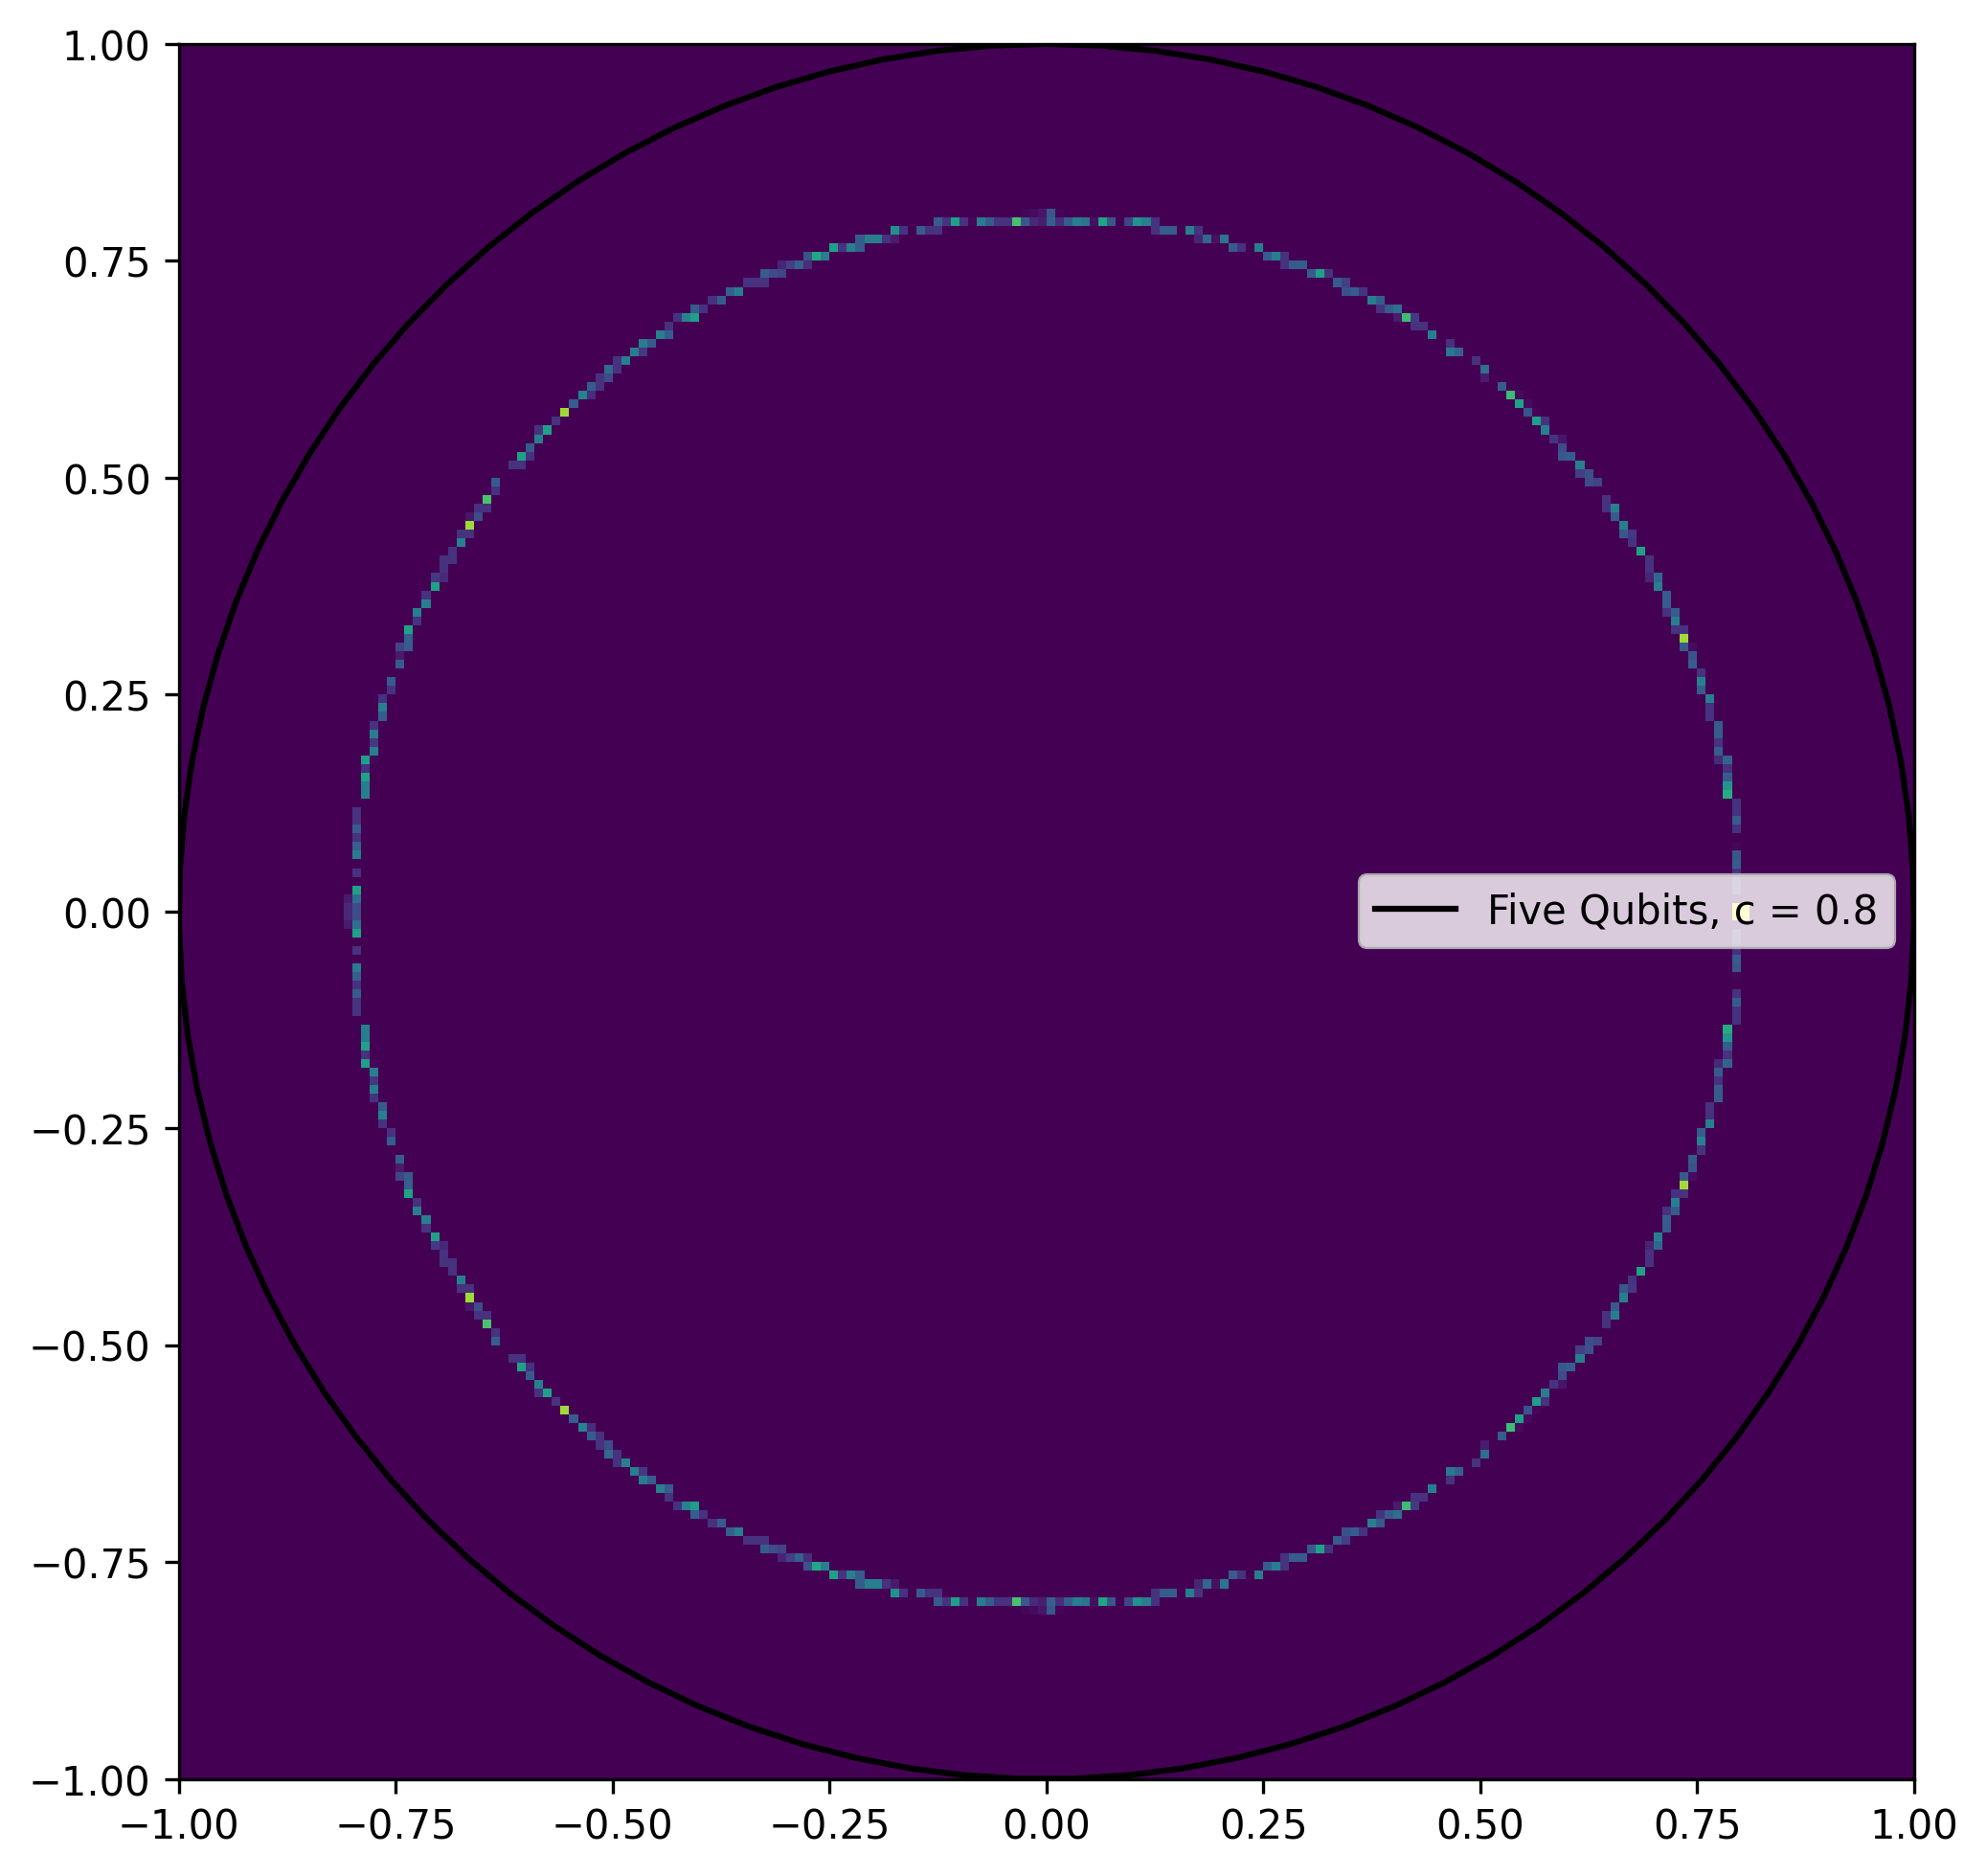

In [32]:
n = 5
circuit = qft(n)

U = Operator(circuit).data
random.seed(42)
np.random.seed(42)
spectrum1 = generate_spectrum_mixed(U = U, 
                                    c = 0.8, 
                                    reps = 10)

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.hist2d(*spectrum1, 
            range = [[-1, 1], [-1, 1]], 
            bins = [200, 200],
            # norm = clr.LogNorm,
           )

plt.plot(*circle, "k")
plt.legend(["Five Qubits, c = 0.8"])
plt.show()

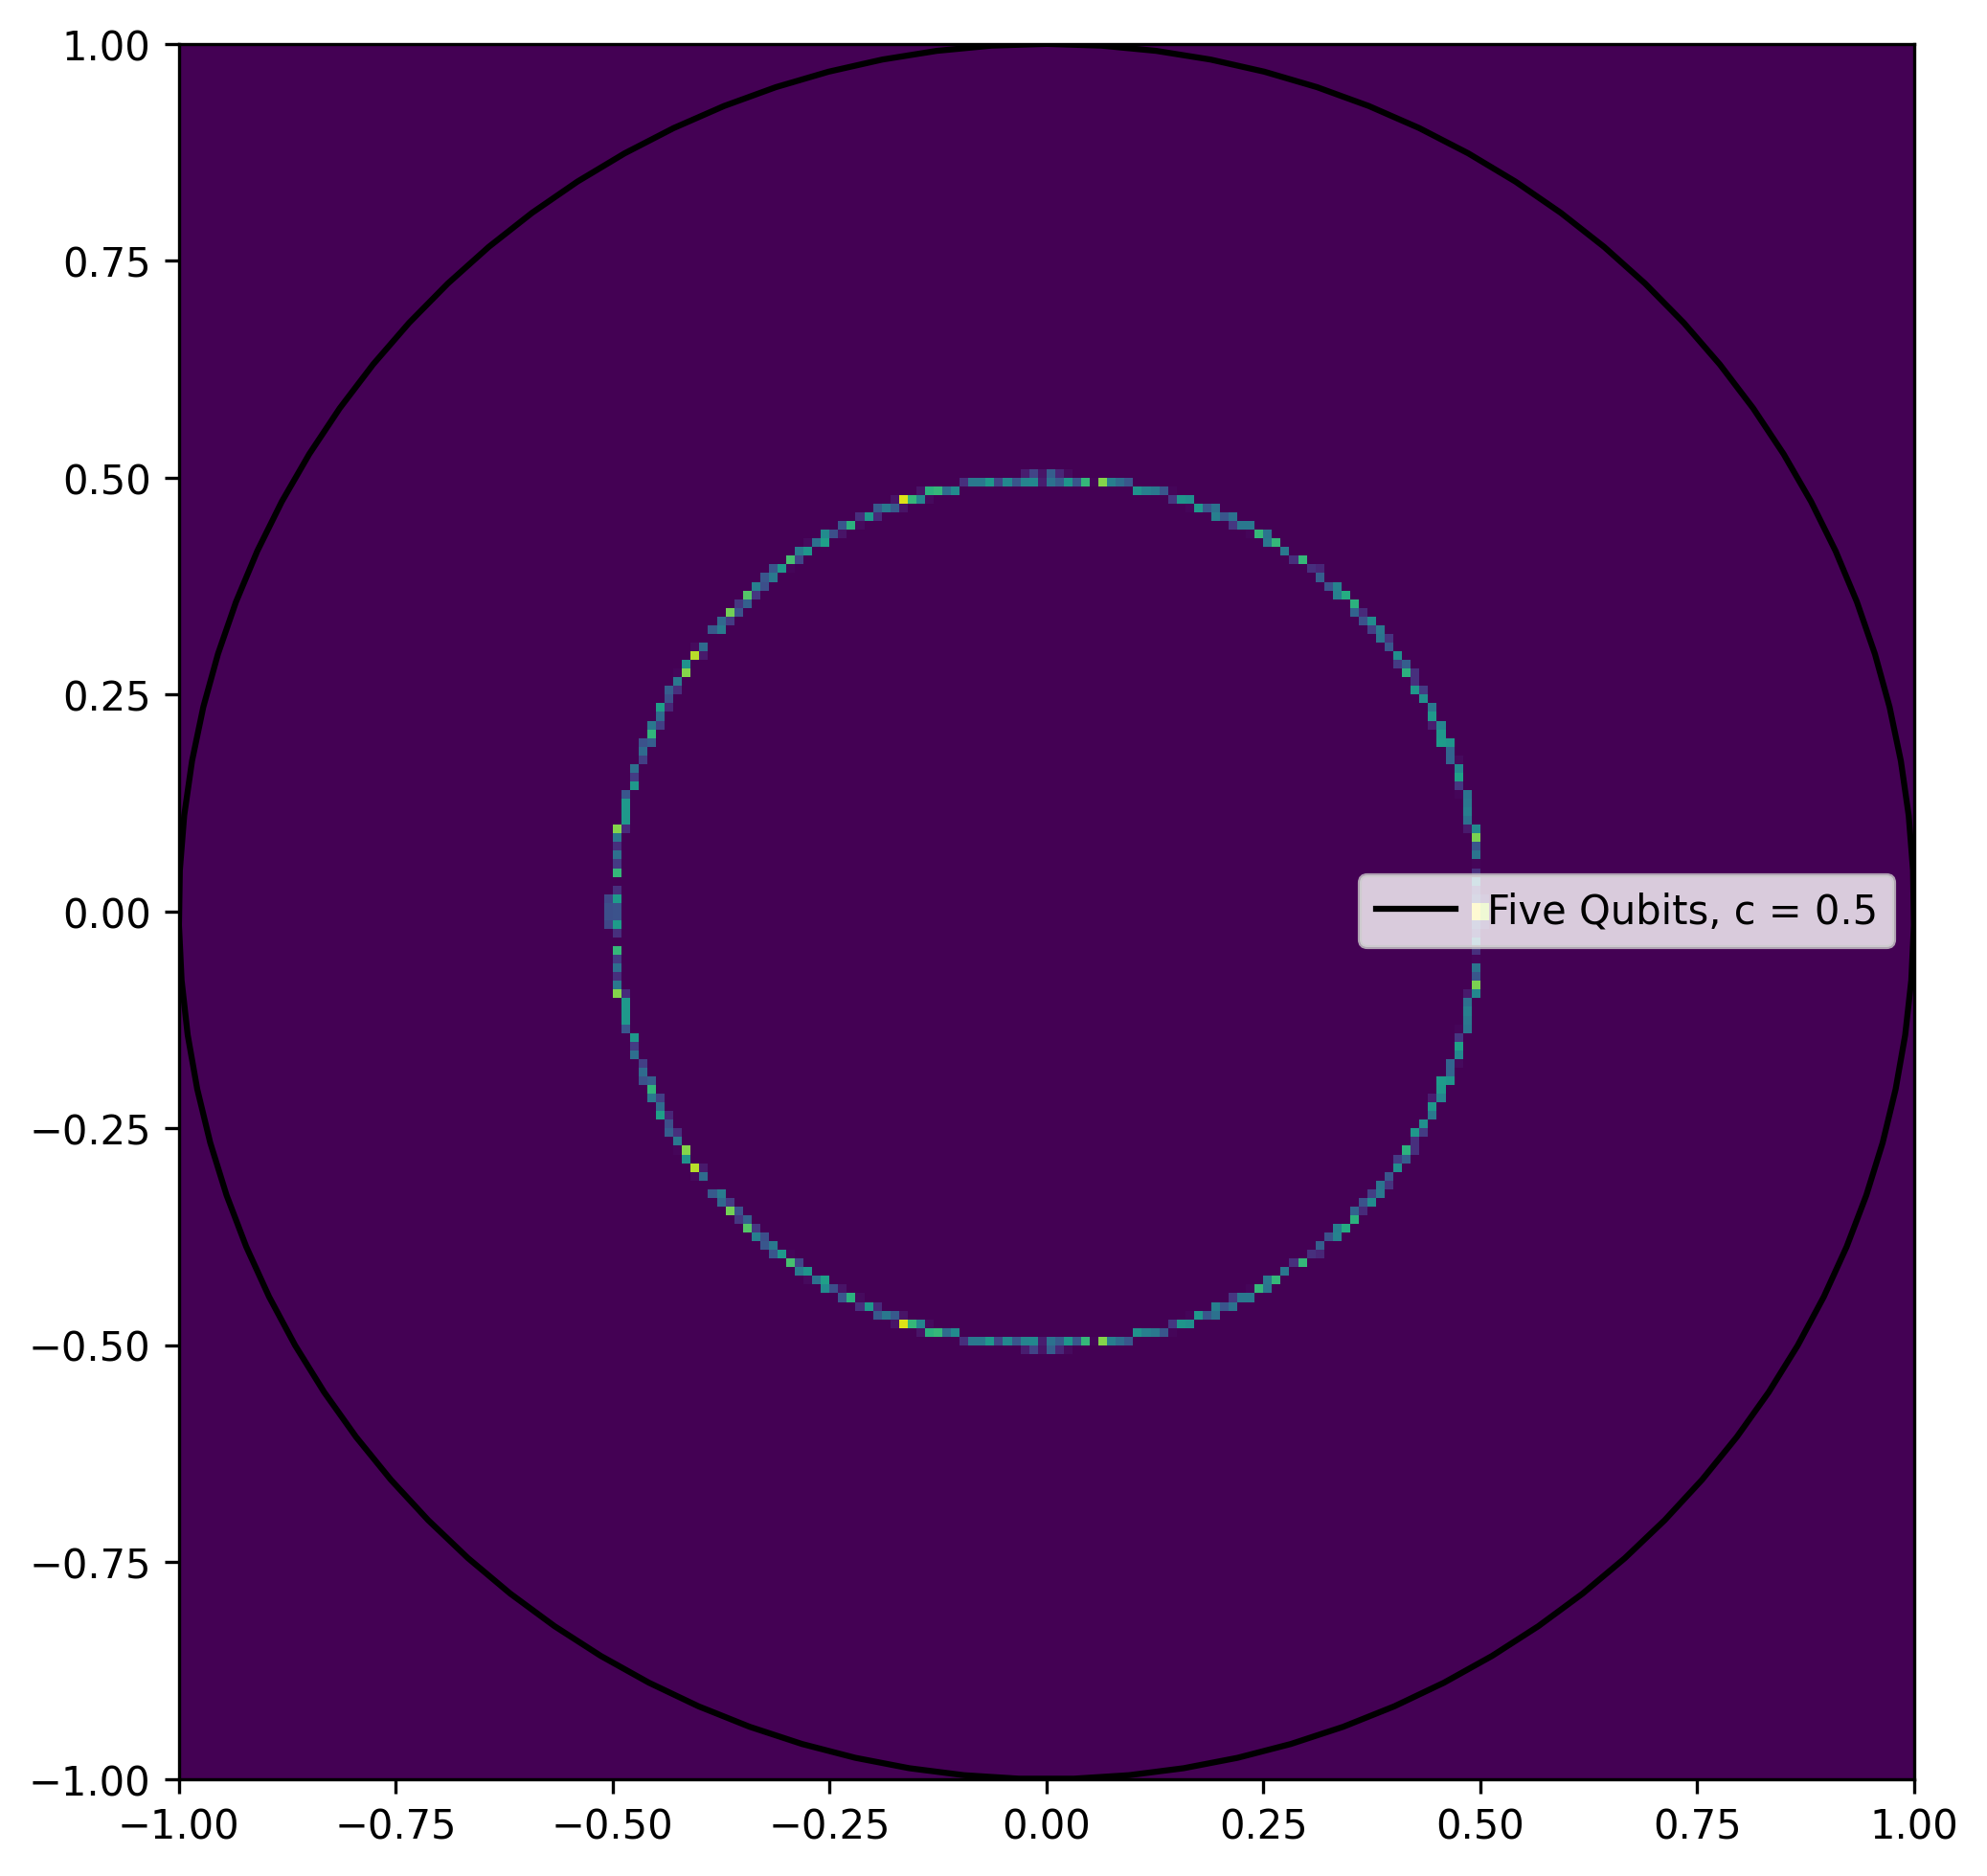

In [33]:
n = 5
circuit = qft(n)

U = Operator(circuit).data
random.seed(42)
np.random.seed(42)
spectrum1 = generate_spectrum_mixed(U = U, 
                                    c = 0.5, 
                                    reps = 10)

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.hist2d(*spectrum1, 
            range = [[-1, 1], [-1, 1]], 
            bins = [200, 200],
            # norm = clr.LogNorm,
           )

plt.plot(*circle, "k")
plt.legend(["Five Qubits, c = 0.5"])
plt.show()

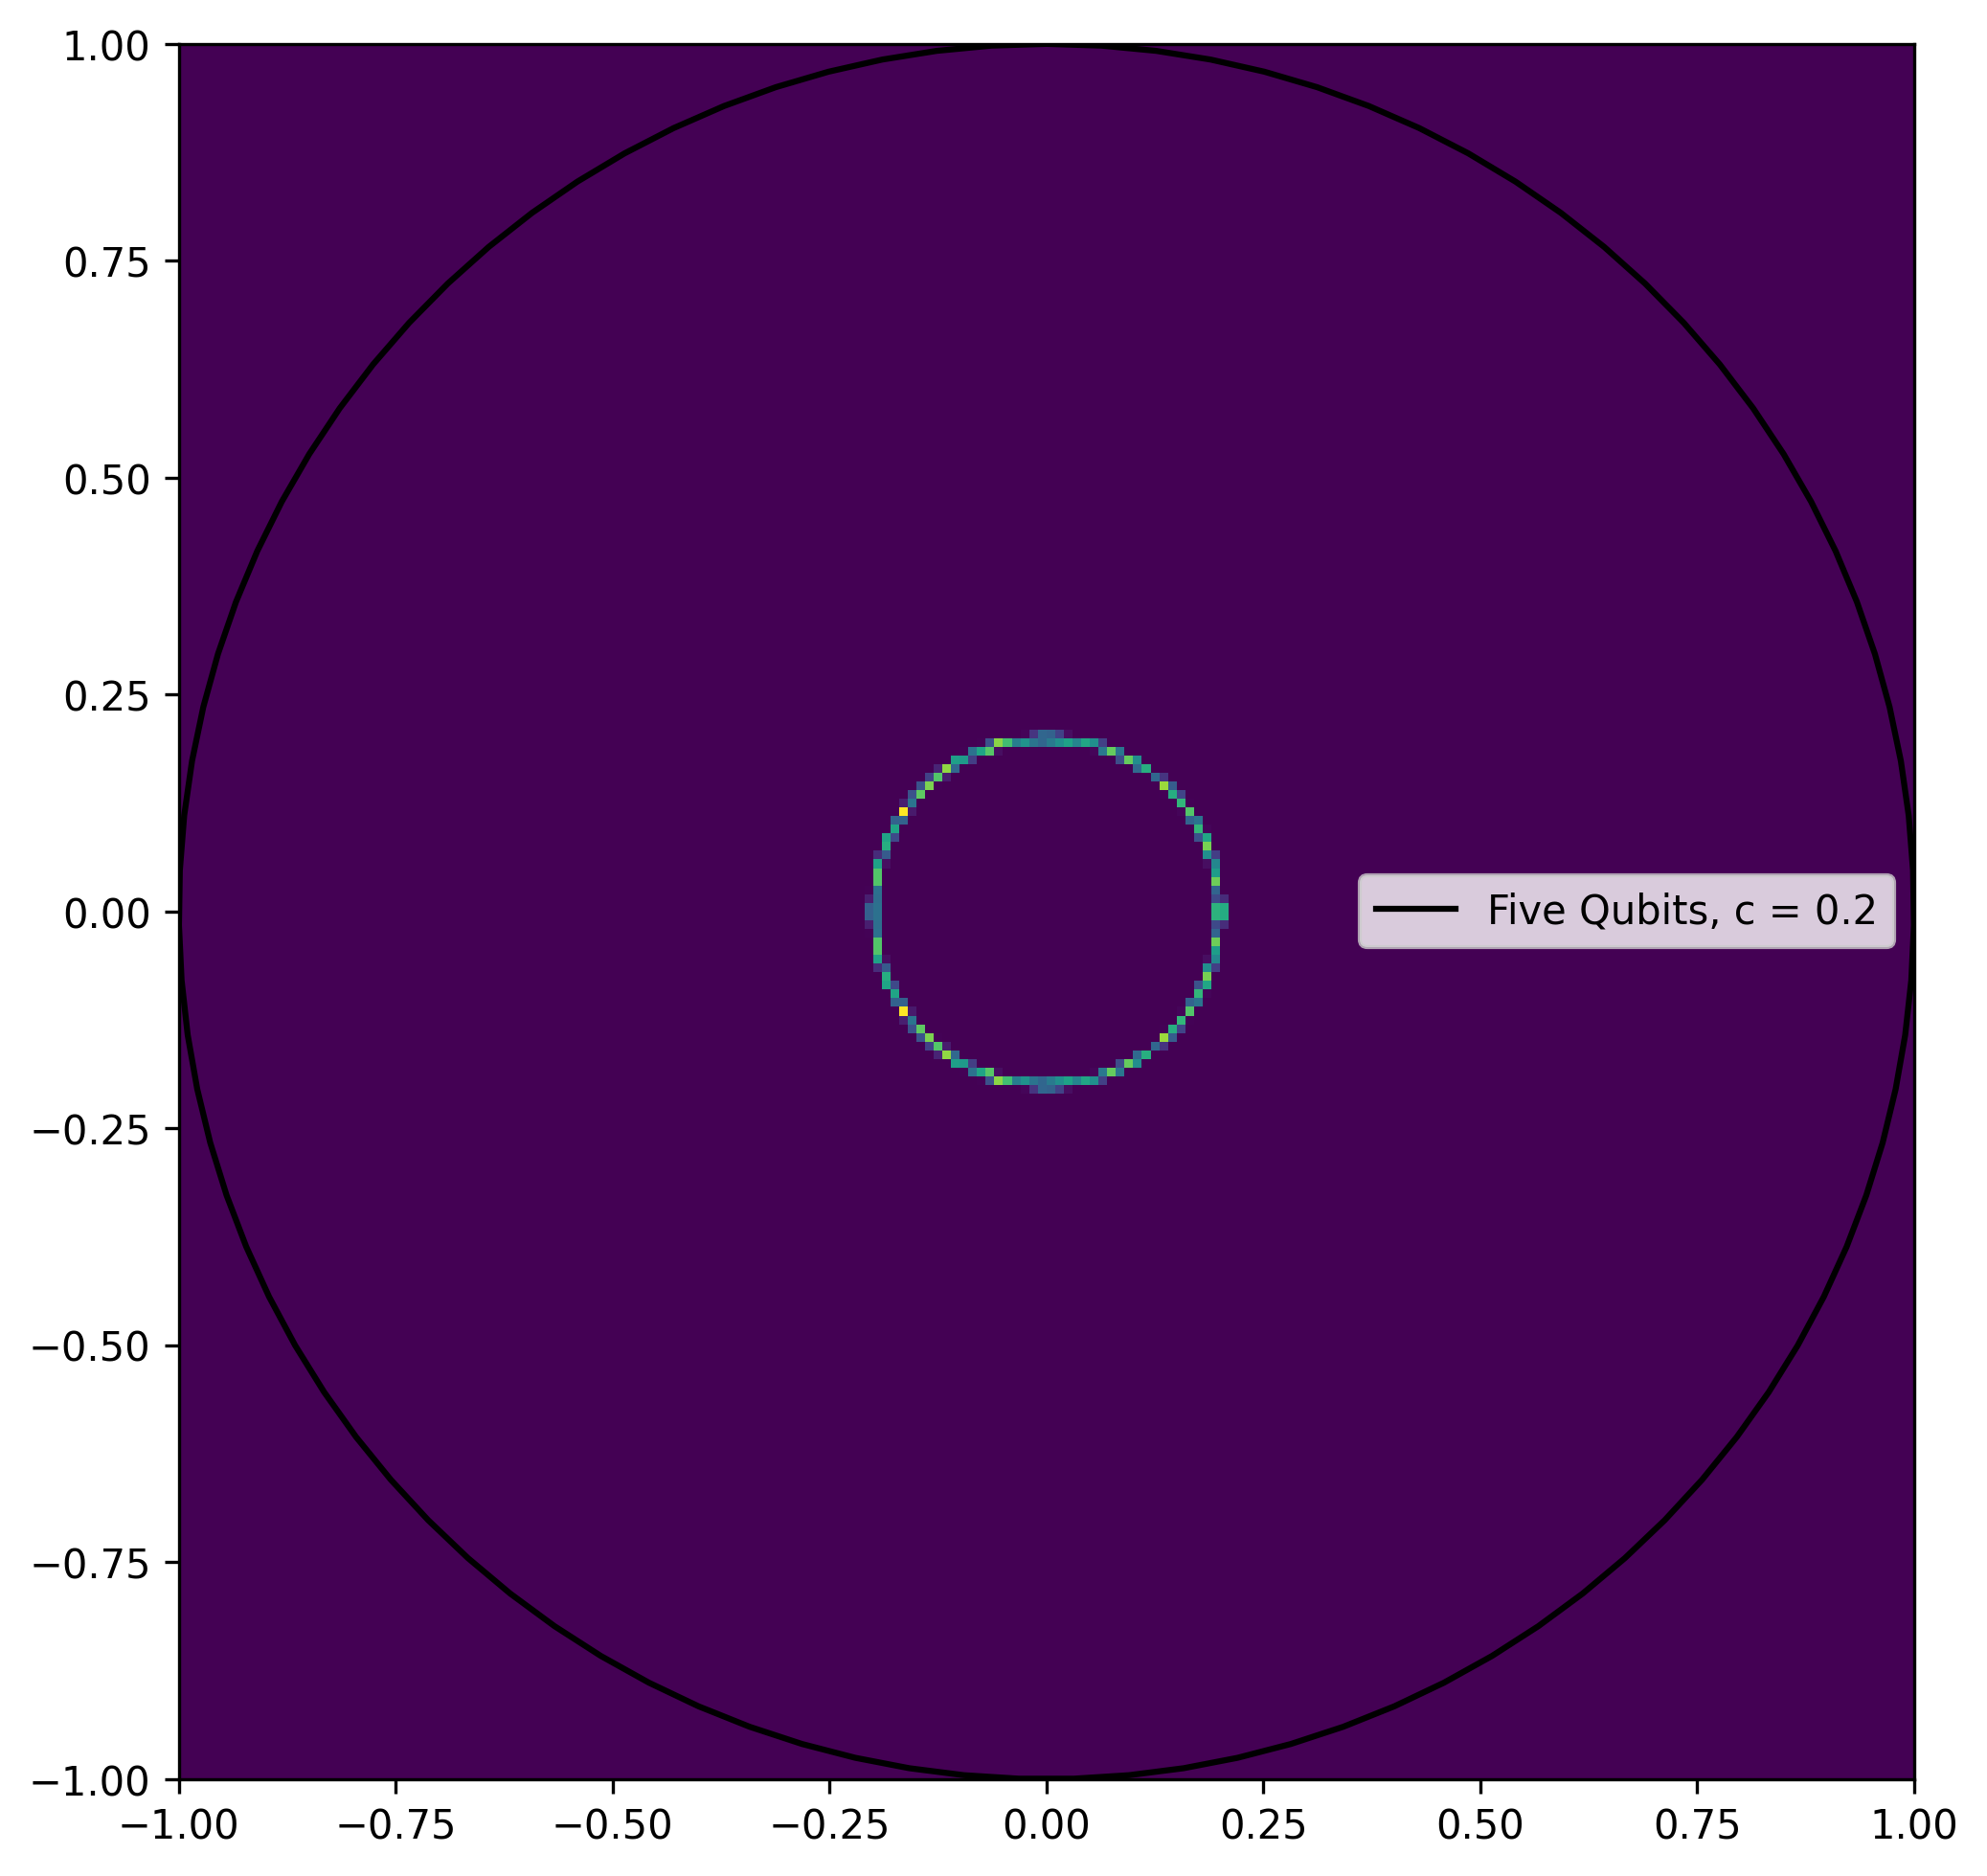

In [34]:
n = 5
circuit = qft(n)

U = Operator(circuit).data
random.seed(42)
np.random.seed(42)
spectrum1 = generate_spectrum_mixed(U = U, 
                                    c = 0.2, 
                                    reps = 10)

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.hist2d(*spectrum1, 
            range = [[-1, 1], [-1, 1]], 
            bins = [200, 200],
            # norm = clr.LogNorm,
           )

plt.plot(*circle, "k")
plt.legend(["Five Qubits, c = 0.2"])
plt.show()

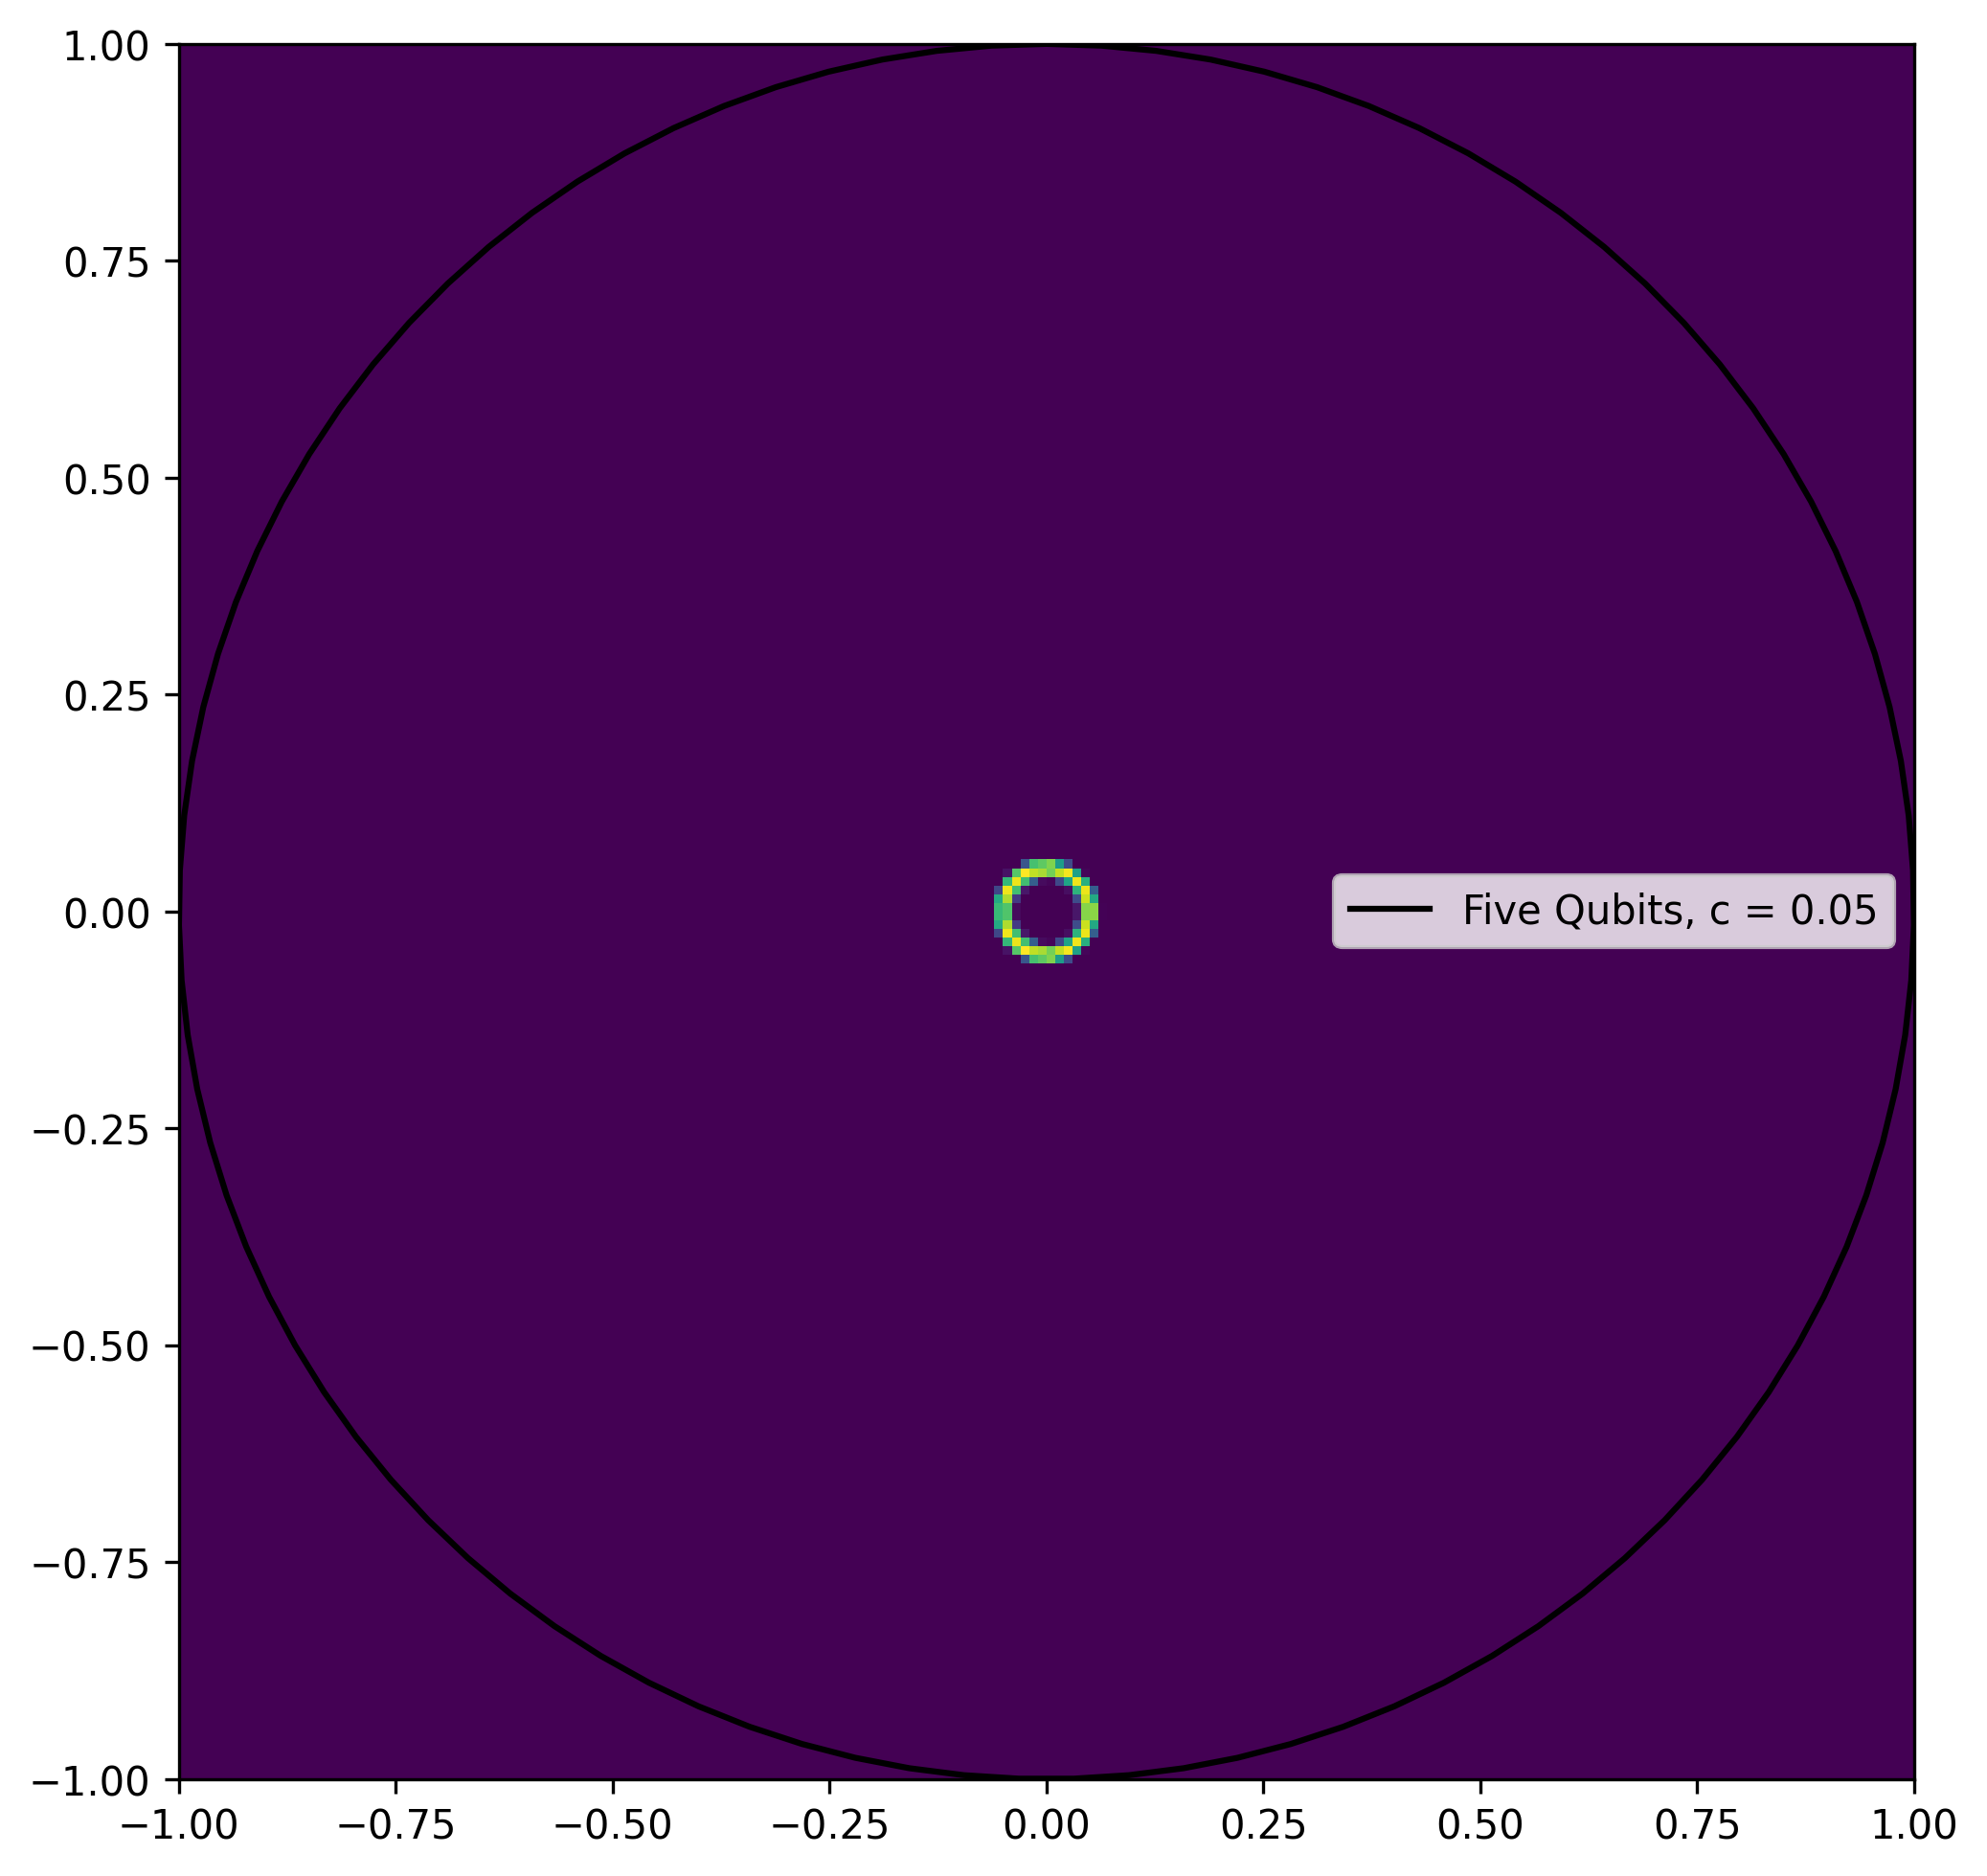

In [35]:
n = 5
circuit = qft(n)

U = Operator(circuit).data
random.seed(42)
np.random.seed(42)
spectrum1 = generate_spectrum_mixed(U = U, 
                                    c = 0.05, 
                                    reps = 10)

fig=plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.hist2d(*spectrum1, 
            range = [[-1, 1], [-1, 1]], 
            bins = [200, 200],
            # norm = clr.LogNorm,
           )

plt.plot(*circle, "k")
plt.legend(["Five Qubits, c = 0.05"])
plt.show()